# Narratives of AI Innovation: Texual Analysis on r/ChatGPT and r/DeepSeek

Date: March 9th, 2025

Author: Xinyue 'Yolanda' Pan


## Packages Prep

In [ ]:
# !pip install transformers
!pip install bertopic

In [4]:
from transformers import pipeline
from bertopic import BERTopic
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import re
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [5]:
def to_csv(csvfilename, df):
    '''
    Given a dataframe, writes it to a CSV file
    Input:
        csvfilename: a string representing the name of the output csv
        cleaned_df: a pandas DataFrame
    '''
    # Using pandas' built-in to_csv method (recommended)
    df.to_csv(csvfilename, index=False)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


^ always run to initiate

---------

In [ ]:
file_path = '/content/drive/MyDrive/deepseek_chatgpt_cmts_data.csv'
df = pd.read_csv(file_path)

df

subreddit                author        date  \
0       DeepSeek              Anuclano  2024-12-27   
1       DeepSeek  Positive_Average_446  2024-12-28   
2       DeepSeek  Positive_Average_446  2024-12-28   
3       DeepSeek  Positive_Average_446  2024-12-28   
4       DeepSeek    redswan_cosignitor  2024-12-29   
...          ...                   ...         ...   
253298   ChatGPT          SeaBearsFoam  2025-03-01   
253299   ChatGPT         headcanonball  2025-03-01   
253300   ChatGPT           Postmanpale  2025-03-01   
253301   ChatGPT              LiteSoul  2025-03-01   
253302   ChatGPT     ThenExtension9196  2025-03-01   

                                                     text      type  
0       Those LLMs are notorious to not know who they ...  comments  
1       Doesn t its system prompt states its name thou...  comments  
2       I got this error when trying to log in with br...  comments  
3       Ah yep just tested Its prompt only say AI assi...  comments  
4       I actually noticed that it falls back on using...  comments  
...                                                   ...       ...  
253298  This is the way I fed it chapters of my book t...  comments  
253299  It s new and people haven t developed the anti...  comments  
253300  wants other humans to interact with his prints...  comments  
253301  Yeah I always go back to the extreme growth an...  comments  
253302  I think the bar is going to be raising We thin...  comments  

[253303 rows x 5 columns]

## Exploratory Data Analysis

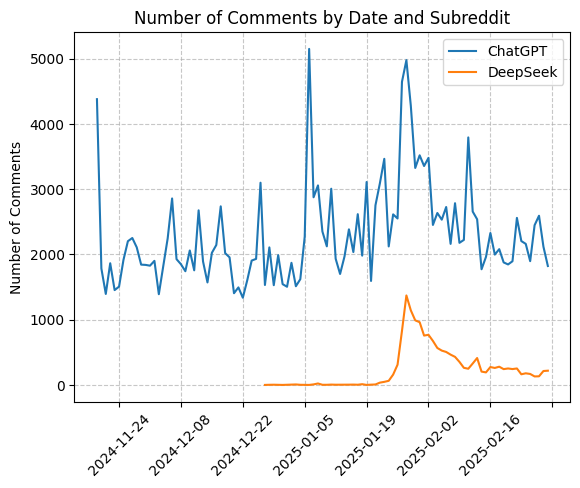

In [ ]:
grouped_df = df.groupby(['date', 'subreddit'])['text'].count().reset_index()

# Get unique dates and subreddits
dates = sorted(grouped_df['date'].unique())
subreddits = grouped_df['subreddit'].unique()  # Fixed variable name from subreddit to subreddits

for subreddit in grouped_df['subreddit'].unique():
    data = grouped_df[grouped_df['subreddit'] == subreddit]
    plt.plot(data['date'], data['text'], marker=None, linestyle='-', label=subreddit)

plt.title('Number of Comments by Date and Subreddit')
plt.ylabel('Number of Comments')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
# symplify the x labels
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
# rotate tickers
plt.xticks(rotation=45)
plt.show()

This remind us that we need to drop to align the time window for this pair comparison.

In [ ]:
first_deepseek_date = df[df['subreddit'] == 'DeepSeek']['date'].min()
first_deepseek_date

'2024-12-27'

In [ ]:
aligned_df = df[df['date'] >= first_deepseek_date]

In [ ]:
print(len(df))
print(len(aligned_df))

253303
177566


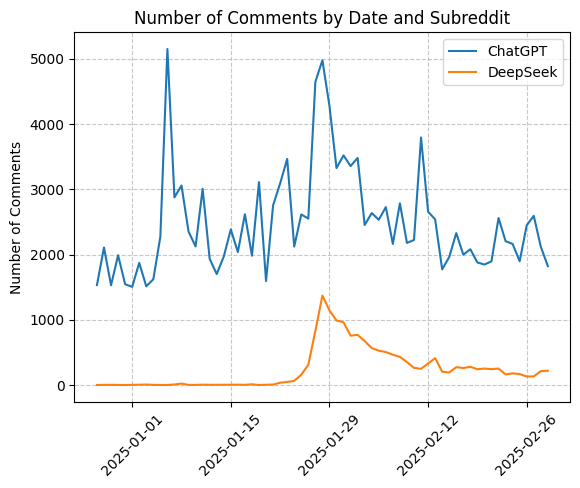

In [ ]:
grouped_df = aligned_df.groupby(['date', 'subreddit'])['text'].count().reset_index()

# Get unique dates and subreddits
dates = sorted(grouped_df['date'].unique())
subreddits = grouped_df['subreddit'].unique()  # Fixed variable name from subreddit to subreddits

for subreddit in grouped_df['subreddit'].unique():
    data = grouped_df[grouped_df['subreddit'] == subreddit]
    plt.plot(data['date'], data['text'], marker=None, linestyle='-', label=subreddit)

plt.title('Number of Comments by Date and Subreddit')
plt.ylabel('Number of Comments')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
# symplify the x labels
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
# rotate tickers
plt.xticks(rotation=45)
plt.show()

## Emotional Narratives

### Tagging with [roberta-base-go_emotions](https://huggingface.co/SamLowe/roberta-base-go_emotions)

In [ ]:
emotion_classifier = pipeline("text-classification", model="SamLowe/roberta-base-go_emotions")

config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
texts = df['text'].tolist()

In [ ]:
# Filter out None values and convert everything to strings
cleaned_texts = []
for i, text in enumerate(texts):
    if text is None:
        print(f"Found None at index {i}")
        continue  # Skip None values
    try:
        # Convert to string if it's not already
        cleaned_text = str(text)
        cleaned_texts.append(cleaned_text)
    except Exception as e:
        print(f"Error at index {i}: {e}")
        continue  # Skip problematic entries

print(f"Original list length: {len(texts)}")
print(f"Cleaned list length: {len(cleaned_texts)}")

Original list length: 253303
Cleaned list length: 253303


In [ ]:
emotions = emotion_classifier(
                              cleaned_texts,
                              truncation=True,
                              max_length=512,   # Maximum the model can handle
                              batch_size=32     # Process in batches for CPU/GPU
                              )

In [ ]:
emotions[0]

{'label': 'neutral', 'score': 0.9242384433746338}

In [ ]:
df['emotions_txt'] = emotions

In [ ]:
# to_csv('/content/drive/MyDrive/data_w_emotion.csv', df)

In [ ]:
def extract_emotion_with_regex(emotion):
    emotion_label = re.search(r"'label':\s*'([^']+)'", str(emotion)).group(1)
    probability = float(re.search(r"'score':\s*([\d.]+)", str(emotion)).group(1))
    return emotion_label, probability

In [ ]:
emotion_labels = []
probabilities = []
for emotion in emotions:
  emotion_label, probability = extract_emotion_with_regex(emotion)
  emotion_labels.append(emotion_label)
  probabilities.append(probability)

In [ ]:
df['emotion_labels'] = emotion_labels
df['emotion_prob'] = probabilities

In [ ]:
df

subreddit                author        date  \
0       DeepSeek              Anuclano  2024-12-27   
1       DeepSeek  Positive_Average_446  2024-12-28   
2       DeepSeek  Positive_Average_446  2024-12-28   
3       DeepSeek  Positive_Average_446  2024-12-28   
4       DeepSeek    redswan_cosignitor  2024-12-29   
...          ...                   ...         ...   
253298   ChatGPT          SeaBearsFoam  2025-03-01   
253299   ChatGPT         headcanonball  2025-03-01   
253300   ChatGPT           Postmanpale  2025-03-01   
253301   ChatGPT              LiteSoul  2025-03-01   
253302   ChatGPT     ThenExtension9196  2025-03-01   

                                                     text      type  \
0       Those LLMs are notorious to not know who they ...  comments   
1       Doesn t its system prompt states its name thou...  comments   
2       I got this error when trying to log in with br...  comments   
3       Ah yep just tested Its prompt only say AI assi...  comments   
4       I actually noticed that it falls back on using...  comments   
...                                                   ...       ...   
253298  This is the way I fed it chapters of my book t...  comments   
253299  It s new and people haven t developed the anti...  comments   
253300  wants other humans to interact with his prints...  comments   
253301  Yeah I always go back to the extreme growth an...  comments   
253302  I think the bar is going to be raising We thin...  comments   

                                             emotions_txt  emotion_labels  \
0       {'label': 'neutral', 'score': 0.9242384433746338}         neutral   
1       {'label': 'neutral', 'score': 0.8529666662216187}         neutral   
2       {'label': 'disappointment', 'score': 0.2567110...  disappointment   
3       {'label': 'amusement', 'score': 0.909096181392...       amusement   
4       {'label': 'realization', 'score': 0.6099989414...     realization   
...                                                   ...             ...   
253298  {'label': 'neutral', 'score': 0.3956723213195801}         neutral   
253299  {'label': 'neutral', 'score': 0.6429405212402344}         neutral   
253300  {'label': 'neutral', 'score': 0.43994060158729...         neutral   
253301  {'label': 'approval', 'score': 0.5577479600906...        approval   
253302  {'label': 'neutral', 'score': 0.7810623645782471}         neutral   

        emotion_prob  
0           0.924238  
1           0.852967  
2           0.256711  
3           0.909096  
4           0.609999  
...              ...  
253298      0.395672  
253299      0.642941  
253300      0.439941  
253301      0.557748  
253302      0.781062  

[253303 rows x 8 columns]

In [ ]:
print(len(df['emotion_labels'].unique()))
print(df['emotion_labels'].unique())

27
['neutral' 'disappointment' 'amusement' 'realization' 'approval'
 'gratitude' 'surprise' 'optimism' 'confusion' 'disapproval' 'admiration'
 'curiosity' 'excitement' 'sadness' 'joy' 'annoyance' 'love' 'remorse'
 'caring' 'desire' 'anger' 'embarrassment' 'nervousness' 'fear' 'disgust'
 'relief' 'pride']


In [ ]:
df = df[df['date'] >= first_deepseek_date] # aligned

In [ ]:
len(df)

177566

#### Sentiment Assignment

In [ ]:
# file_path = '/content/drive/MyDrive/data_w_emotion.csv'
# emotion_df = pd.read_csv(file_path)

In [ ]:
emotion_df = df.copy()

In [ ]:
# Positive emotions typically involve pleasure, satisfaction, or growth
positive = [
    'approval', 'gratitude', 'optimism', 'admiration',
    'excitement', 'joy', 'love', 'caring', 'desire', 'relief', 'pride'
]

# Negative emotions typically involve distress, dissatisfaction, or avoidance
negative = [
    'disappointment', 'disapproval', 'sadness', 'annoyance',
    'remorse', 'anger', 'embarrassment', 'nervousness',
    'fear', 'disgust'
]

# Ambiguous emotions depend on context or don't clearly fit above categories
ambiguous = [
    'amusement', 'realization', 'surprise',
    'confusion', 'curiosity'
]

In [ ]:
def categorize_emotion(emotion):
    if emotion in positive:
        return 'positive'
    elif emotion in negative:
        return 'negative'
    elif emotion in ambiguous:
        return 'ambiguous'
    else:
        return 'neutral'

In [ ]:
emotion_df['sentiment_category'] = emotion_df['emotion_labels'].apply(categorize_emotion)
emotion_df['sentiment_category'][:5]

0      neutral
1      neutral
2     negative
3    ambiguous
4    ambiguous
Name: sentiment_category, dtype: object

In [ ]:
sentiments = ['positive', 'negative', 'ambiguous', 'neutral']

In [ ]:
for sentiment in sentiments:
  chatgpt_sentiment_counts = emotion_df[(emotion_df['subreddit'] == 'ChatGPT') & (emotion_df['sentiment_category'] == sentiment)].shape[0]
  deepseek_sentiment_counts = emotion_df[(emotion_df['subreddit'] == 'DeepSeek') & (emotion_df['sentiment_category'] == sentiment)].shape[0]
  print(sentiment)
  print(f'ChatGPT {sentiment} counts: {chatgpt_sentiment_counts}')
  print(f'DeepSeek {sentiment} counts: {deepseek_sentiment_counts}')

positive
ChatGPT positive counts: 29446
DeepSeek positive counts: 2339
negative
ChatGPT negative counts: 22378
DeepSeek negative counts: 2012
ambiguous
ChatGPT ambiguous counts: 23297
DeepSeek ambiguous counts: 2017
neutral
ChatGPT neutral counts: 86697
DeepSeek neutral counts: 9380


In [ ]:
to_csv('/content/drive/MyDrive/data_w_emotion_sentiment.csv', emotion_df)

### Data Preprocessing

In [ ]:
file_path = '/content/drive/MyDrive/data_w_emotion_sentiment.csv'
df = pd.read_csv(file_path)
df.head()

subreddit                author        date  \
0  DeepSeek              Anuclano  2024-12-27   
1  DeepSeek  Positive_Average_446  2024-12-28   
2  DeepSeek  Positive_Average_446  2024-12-28   
3  DeepSeek  Positive_Average_446  2024-12-28   
4  DeepSeek    redswan_cosignitor  2024-12-29   

                                                text      type  \
0  Those LLMs are notorious to not know who they ...  comments   
1  Doesn t its system prompt states its name thou...  comments   
2  I got this error when trying to log in with br...  comments   
3  Ah yep just tested Its prompt only say AI assi...  comments   
4  I actually noticed that it falls back on using...  comments   

                                        emotions_txt  emotion_labels  \
0  {'label': 'neutral', 'score': 0.9242384433746338}         neutral   
1  {'label': 'neutral', 'score': 0.8529666662216187}         neutral   
2  {'label': 'disappointment', 'score': 0.2567110...  disappointment   
3  {'label': 'amusement', 'score': 0.909096181392...       amusement   
4  {'label': 'realization', 'score': 0.6099989414...     realization   

   emotion_prob sentiment_category  
0      0.924238            neutral  
1      0.852967            neutral  
2      0.256711           negative  
3      0.909096          ambiguous  
4      0.609999          ambiguous

#### Detect outliers

In [ ]:
emotion_labels = df['emotion_labels'].unique()
len(emotion_labels)

27

In [ ]:
chatgpt_emotion_counts = []
deepseek_emotion_counts = []
for specific_emotion in emotion_labels:
  chatgpt_emotion_counts.append(df[(df['subreddit'] == 'ChatGPT') & (df['emotion_labels'] == specific_emotion)].shape[0])
  deepseek_emotion_counts.append(df[(df['subreddit'] == 'DeepSeek') & (df['emotion_labels'] == specific_emotion)].shape[0])

emotion_count_df = pd.DataFrame({
    'Emotion': emotion_labels,
    'ChatGPT': chatgpt_emotion_counts,
    'DeepSeek': deepseek_emotion_counts
})

In [ ]:
emotion_count_df

Emotion  ChatGPT  DeepSeek
0          neutral    86697      9380
1   disappointment     2369       243
2        amusement     9115       770
3      realization     1745       120
4         approval    10702       848
5        gratitude     3519       308
6         surprise     1752       153
7         optimism     2517       251
8        confusion     5665       502
9      disapproval     6048       667
10      admiration     5943       475
11       curiosity     5020       472
12      excitement      807        61
13         sadness     1451        97
14             joy     1686       126
15       annoyance     7334       658
16            love     2033       108
17         remorse     1339       116
18          caring     1226        96
19          desire      998        65
20           anger     1317       113
21   embarrassment      205        16
22     nervousness      247        10
23            fear     1329        60
24         disgust      739        32
25          relief        3         1
26           pride       12         0

In [ ]:
emotion_df = df.copy()
emotion_df = emotion_df[~emotion_df['emotion_labels'].isin(['relief', 'pride'])]

In [ ]:
emotion_df['emotion_labels'].unique()

array(['neutral', 'disappointment', 'amusement', 'realization',
       'approval', 'gratitude', 'surprise', 'optimism', 'confusion',
       'disapproval', 'admiration', 'curiosity', 'excitement', 'sadness',
       'joy', 'annoyance', 'love', 'remorse', 'caring', 'desire', 'anger',
       'embarrassment', 'nervousness', 'fear', 'disgust'], dtype=object)

#### Drop 'Neutral' emotion

In [ ]:
emotion_df = emotion_df[emotion_df['emotion_labels'] != 'neutral']
print(len(emotion_df))
emotion_df[:3]

81473


subreddit                author        date  \
2  DeepSeek  Positive_Average_446  2024-12-28   
3  DeepSeek  Positive_Average_446  2024-12-28   
4  DeepSeek    redswan_cosignitor  2024-12-29   

                                                text      type  \
2  I got this error when trying to log in with br...  comments   
3  Ah yep just tested Its prompt only say AI assi...  comments   
4  I actually noticed that it falls back on using...  comments   

                                        emotions_txt  emotion_labels  \
2  {'label': 'disappointment', 'score': 0.2567110...  disappointment   
3  {'label': 'amusement', 'score': 0.909096181392...       amusement   
4  {'label': 'realization', 'score': 0.6099989414...     realization   

   emotion_prob sentiment_category  
2      0.256711           negative  
3      0.909096          ambiguous  
4      0.609999          ambiguous

In [ ]:
emotion_df = emotion_df.reset_index(drop=True)
emotion_df[:3]

subreddit                author        date  \
0  DeepSeek  Positive_Average_446  2024-12-28   
1  DeepSeek  Positive_Average_446  2024-12-28   
2  DeepSeek    redswan_cosignitor  2024-12-29   

                                                text      type  \
0  I got this error when trying to log in with br...  comments   
1  Ah yep just tested Its prompt only say AI assi...  comments   
2  I actually noticed that it falls back on using...  comments   

                                        emotions_txt  emotion_labels  \
0  {'label': 'disappointment', 'score': 0.2567110...  disappointment   
1  {'label': 'amusement', 'score': 0.909096181392...       amusement   
2  {'label': 'realization', 'score': 0.6099989414...     realization   

   emotion_prob sentiment_category  
0      0.256711           negative  
1      0.909096          ambiguous  
2      0.609999          ambiguous

In [ ]:
to_csv('/content/drive/MyDrive/data_w_non-neutral-emotion_sentiment.csv', emotion_df)
len(emotion_df)

81473

### Emotion Distribution by Subreddit (2024/12/27 - 2025/03/02)

2024/12/19: Collection Start Date

2024/12/26: DeepSeek-V3 release date

2024/12/27: First comment appear on r/DeepSeek

2025/1/20: DeepSeek-R1 release date

In [ ]:
emotion_df = pd.read_csv('/content/drive/MyDrive/data_w_emotion_sentiment.csv')
emotion_df_aligned = pd.read_csv('/content/drive/MyDrive/data_w_non-neutral-emotion_sentiment.csv')

#### Emotions

In [ ]:
# create full colormap
all_emotions = emotion_df_aligned['emotion_labels'].unique()
emotion_colors = sns.color_palette('tab20', len(all_emotions))
emotion_color_map = dict(zip(all_emotions, emotion_colors))

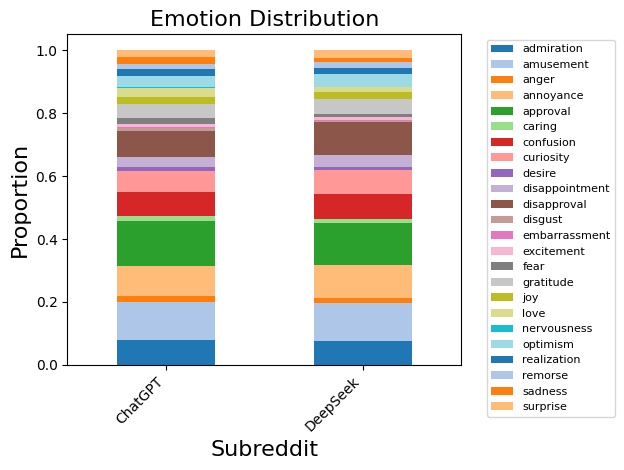

In [ ]:
emotion_dist = pd.crosstab(emotion_df_aligned['subreddit'], emotion_df_aligned['emotion_labels'], normalize='index')
ax = emotion_dist.plot(kind='bar', stacked=True, color=emotion_colors)
ax
ax.set_title('Emotion Distribution', fontsize=16)
ax.set_xlabel('Subreddit', fontsize=16)
plt.xticks(rotation=45, ha='right')
ax.set_ylabel('Proportion', fontsize=16)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

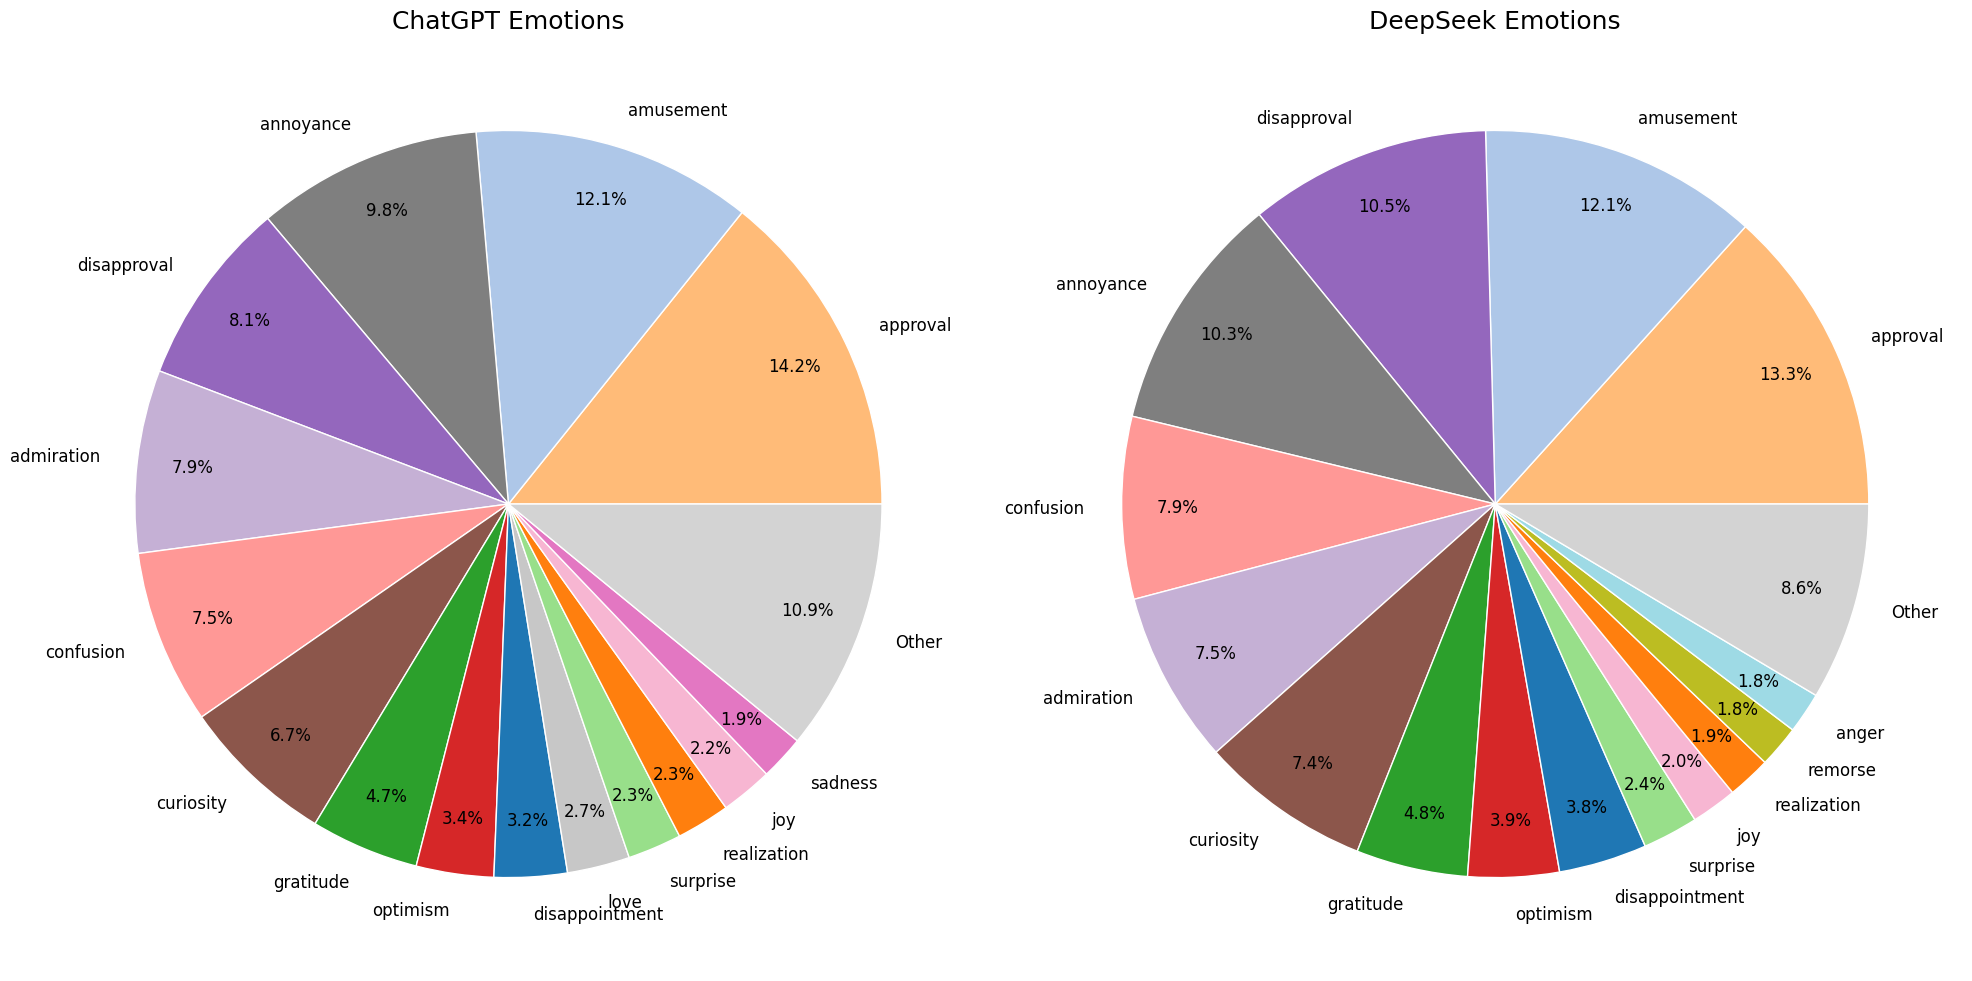

In [ ]:
plt.figure(figsize=(20, 10))

# Left: ChatGPT non-neutral emotions pie chart
plt.subplot(1, 2, 1)
chatgpt_non_neutral = emotion_df_aligned[(emotion_df_aligned['subreddit'] == 'ChatGPT')]['emotion_labels'].value_counts()
# top 10 emotions, rest == "Other"
if len(chatgpt_non_neutral) > 10:
    top_emotions = chatgpt_non_neutral.nlargest(15).index.tolist()
    chatgpt_grouped = chatgpt_non_neutral.copy()
    chatgpt_grouped['Other'] = chatgpt_grouped[~chatgpt_grouped.index.isin(top_emotions)].sum()
    chatgpt_grouped = chatgpt_grouped[chatgpt_grouped.index.isin(top_emotions + ['Other'])]
    plt.pie(
        chatgpt_grouped,
        labels=chatgpt_grouped.index,
        colors=[emotion_color_map.get(emotion, 'gray') if emotion != 'Other' else 'lightgray'
                for emotion in chatgpt_grouped.index],
        autopct='%1.1f%%',
        pctdistance=0.85,
        textprops={'fontsize': 12},
        wedgeprops={'edgecolor': 'white', 'linewidth': 1}
    )
else:
    plt.pie(
        chatgpt_non_neutral,
        labels=chatgpt_non_neutral.index,
        colors=[emotion_color_map.get(emotion, 'gray') for emotion in chatgpt_non_neutral.index],
        autopct='%1.1f%%',
        pctdistance=0.85,
        textprops={'fontsize': 12},
        wedgeprops={'edgecolor': 'white', 'linewidth': 1}
    )
plt.title('ChatGPT Emotions', fontsize=18)

# ------------------------------------------------------------------------------
# Right: DeepSeek non-neutral emotions pie chart
plt.subplot(1, 2, 2)
deepseek_non_neutral = emotion_df_aligned[(emotion_df_aligned['subreddit'] == 'DeepSeek')]['emotion_labels'].value_counts()
# top 10 emotions, rest == "Other"
if len(deepseek_non_neutral) > 10:
    top_emotions = deepseek_non_neutral.nlargest(15).index.tolist()
    deepseek_grouped = deepseek_non_neutral.copy()
    deepseek_grouped['Other'] = deepseek_grouped[~deepseek_grouped.index.isin(top_emotions)].sum()
    deepseek_grouped = deepseek_grouped[deepseek_grouped.index.isin(top_emotions + ['Other'])]
    plt.pie(
        deepseek_grouped,
        labels=deepseek_grouped.index,
        colors=[emotion_color_map.get(emotion, 'gray') if emotion != 'Other' else 'lightgray'
                for emotion in deepseek_grouped.index],
        autopct='%1.1f%%',
        pctdistance=0.85,
        textprops={'fontsize': 12},
        wedgeprops={'edgecolor': 'white', 'linewidth': 1}
    )
else:
    plt.pie(
        deepseek_non_neutral,
        labels=deepseek_non_neutral.index,
        colors=[emotion_color_map.get(emotion, 'gray') for emotion in deepseek_non_neutral.index],
        autopct='%1.1f%%',
        pctdistance=0.85,
        textprops={'fontsize': 12},
        wedgeprops={'edgecolor': 'white', 'linewidth': 1}
    )
plt.title('DeepSeek Emotions', fontsize=18)

plt.tight_layout()
plt.show()

#### Sentiments

In [ ]:
sentiment_colors = {
    'positive': '#4CAF50',  # Green
    'negative': '#F44336',  # Red
    'ambiguous': '#FFC107',  # Amber
}

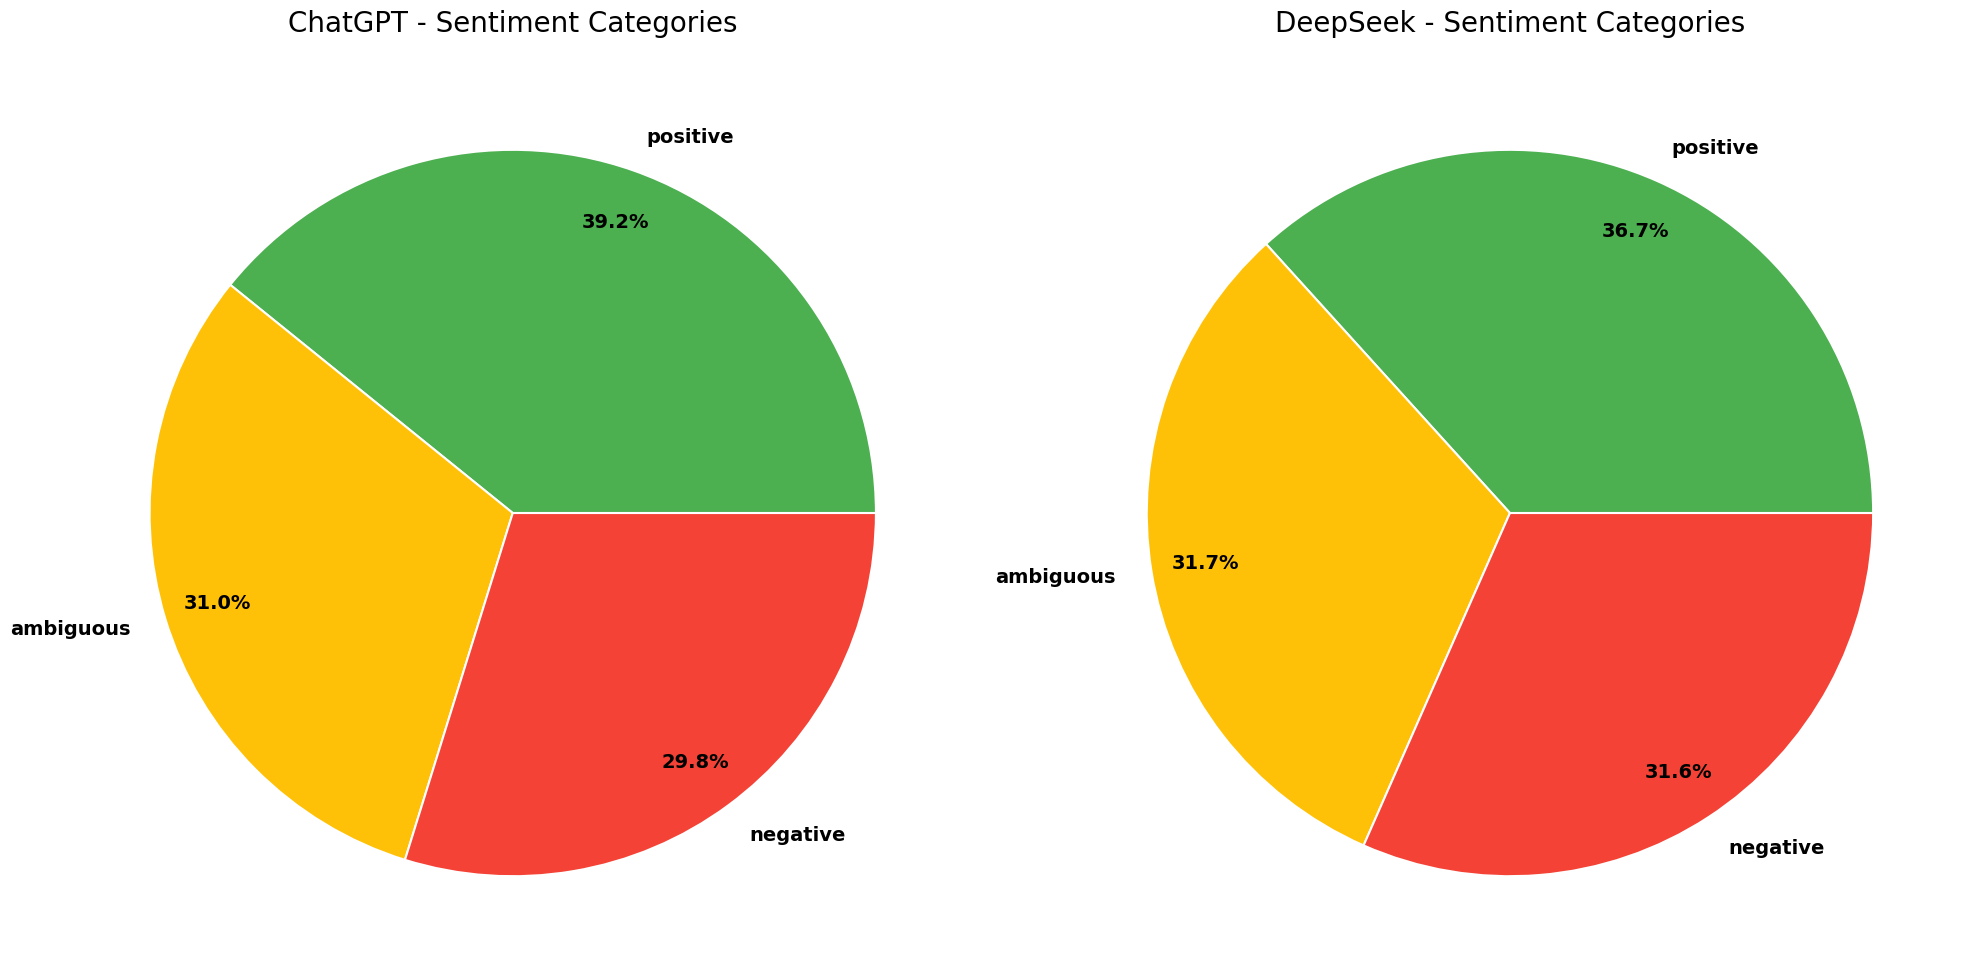

In [ ]:
# Create the pie charts
plt.figure(figsize=(20, 10))

# ------------------------------------------------------------------------------
# ChatGPT sentiment pie chart
plt.subplot(1, 2, 1)
chatgpt_sentiment = emotion_df_aligned[(emotion_df_aligned['subreddit'] == 'ChatGPT')]['sentiment_category'].value_counts()

plt.pie(
    chatgpt_sentiment,
    labels=chatgpt_sentiment.index,
    colors=[sentiment_colors[category] for category in chatgpt_sentiment.index],
    autopct='%1.1f%%',
    pctdistance=0.85,
    textprops={'fontsize': 14, 'fontweight': 'bold'},
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5},
    explode=[0.05 if cat == 'Positive' else 0 for cat in chatgpt_sentiment.index]  # Slightly explode the positive slice
)
plt.title('ChatGPT - Sentiment Categories', fontsize=20, pad=20)

# ------------------------------------------------------------------------------
# DeepSeek sentiment pie chart
plt.subplot(1, 2, 2)
deepseek_sentiment = emotion_df_aligned[(emotion_df_aligned['subreddit'] == 'DeepSeek')]['sentiment_category'].value_counts()

plt.pie(
    deepseek_sentiment,
    labels=deepseek_sentiment.index,
    colors=[sentiment_colors[category] for category in deepseek_sentiment.index],
    autopct='%1.1f%%',
    pctdistance=0.85,
    textprops={'fontsize': 14, 'fontweight': 'bold'},
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5},
    explode=[0.05 if cat == 'Positive' else 0 for cat in deepseek_sentiment.index]  # Slightly explode the positive slice
)
plt.title('DeepSeek - Sentiment Categories', fontsize=20, pad=20)

# ------------------------------------------------------------------------------
plt.tight_layout()
plt.show()

#### Statistical Analysis on Sentiments and Emotions

In [ ]:
def stats_test_prep(df, emotion_column_name = 'sentiment_category', emotion = 'Negative'):
  chatgpt_count_of_emotion = df[(df['subreddit'] == 'ChatGPT')
                                    & (df[emotion_column_name] == emotion)].shape[0]
  chatgpt_total = df[(df['subreddit'] == 'ChatGPT')
                                & (df[emotion_column_name] != 'neutral')].shape[0]
  deepseek_count_of_emotion = df[(df['subreddit'] == 'DeepSeek')
                                    & (df[emotion_column_name] == emotion)].shape[0]
  deepseek_total = df[(df['subreddit'] == 'DeepSeek')
                                & (df[emotion_column_name] != 'neutral')].shape[0]
  return chatgpt_count_of_emotion, deepseek_count_of_emotion, chatgpt_total, deepseek_total

In [ ]:
def Chi_square_test(parameters):
  chatgpt_count_of_emotion, deepseek_count_of_emotion, chatgpt_total, deepseek_total = parameters

  observed = np.array([
      [chatgpt_count_of_emotion, chatgpt_total - chatgpt_count_of_emotion],
      [deepseek_count_of_emotion, deepseek_total - deepseek_count_of_emotion]
  ])
  chi2, p, dof, expected = stats.chi2_contingency(observed)
  return {"chi2": chi2, "p_value": p, "is_significant": p < 0.05}

def z_stats_test(parameters):
  chatgpt_count_of_emotion, deepseek_count_of_emotion, chatgpt_total, deepseek_total = parameters

  count = np.array([chatgpt_count_of_emotion, deepseek_count_of_emotion])
  nobs = np.array([chatgpt_total, deepseek_total])

  stat, p_value = proportions_ztest(count, nobs)
  return {"z-stat": stat, "p_value": p_value, "is_significant": p_value < 0.05}

In [ ]:
emotions_columns = ['sentiment_category', 'emotion_labels']
sentiments = ['negative', 'positive', 'ambiguous']
emotions = [ 'disappointment', 'amusement', 'realization', 'approval',
 'gratitude', 'surprise', 'optimism', 'confusion', 'disapproval', 'admiration',
 'curiosity', 'excitement', 'sadness', 'joy', 'annoyance', 'love', 'remorse',
 'caring', 'desire', 'anger', 'embarrassment', 'nervousness', 'fear', 'disgust']

In [ ]:
for emotions_column in emotions_columns:
  if emotions_column == 'sentiment_category':
    for sentiment in sentiments:
      print(f'Sentiment: {sentiment}')
      parameters = stats_test_prep(emotion_df_aligned, emotion_column_name = emotions_column, emotion = sentiment)
      print(Chi_square_test(parameters))
      print(z_stats_test(parameters))
  else:
    for emotion in emotions:
      print(f'Emotion: {emotion}')
      parameters = stats_test_prep(emotion_df_aligned, emotion_column_name = emotions_column, emotion = emotion)
      print(Chi_square_test(parameters))
      print(z_stats_test(parameters))

Sentiment: negative
{'chi2': 9.033476394352363, 'p_value': 0.0026507989413307215, 'is_significant': True}
{'z-stat': -3.019824603192709, 'p_value': 0.0025292110778380953, 'is_significant': True}
Sentiment: positive
{'chi2': 14.893010644253074, 'p_value': 0.00011378378002645242, 'is_significant': True}
{'z-stat': 3.872527356323686, 'p_value': 0.00010771258170140623, 'is_significant': True}
Sentiment: ambiguous
{'chi2': 1.1636905794249648, 'p_value': 0.2807014596500078, 'is_significant': False}
{'z-stat': -1.0928473978447861, 'p_value': 0.274460807062609, 'is_significant': False}
Emotion: disappointment
{'chi2': 8.085613975647577, 'p_value': 0.004461801243308647, 'is_significant': True}
{'z-stat': -2.880569688271641, 'p_value': 0.003969571865660096, 'is_significant': True}
Emotion: amusement
{'chi2': 0.006384910994760553, 'p_value': 0.9363123056426204, 'is_significant': False}
{'z-stat': 0.09989400777839383, 'p_value': 0.9204284736564952, 'is_significant': False}
Emotion: realization
{'c

In [ ]:
SIGNIFICANT_EMOTIONS = ['disappointment', 'realization', 'approval',
                        'optimism', 'disapproval', 'curiosity',
                        'sadness', 'love', 'desire',
                        'nervousness', 'fear', 'disgust' ]

In [ ]:
len(SIGNIFICANT_EMOTIONS)

12

### Emotional Shift through Time

2024/12/19: Collection Start Date

2024/12/26: DeepSeek-V3 release date

2024/12/27: First comment appear on r/DeepSeek

2025/1/20: DeepSeek-R1 release date

#### Emotion shift (2025/01/20 - 2025/03/02)

In [ ]:
filtered_emotion_df = emotion_df[emotion_df['emotion_labels'].isin(SIGNIFICANT_EMOTIONS)]

In [ ]:
filtered_emotion_df['date'] = pd.to_datetime(filtered_emotion_df['date'])

In [ ]:
# data aggregation and transfer
# Group and count by week, subreddit, and sentiment category
emotion_over_time = filtered_emotion_df.groupby(
    [pd.Grouper(key='date', freq='W'), 'subreddit', 'emotion_labels']
).size()

# Convert to the format required for visualization
# First create a DataFrame
emotion_counts = emotion_over_time.reset_index(name='count')

# Calculate the weekly totals for each subreddit
total_counts = emotion_counts.groupby(['date', 'subreddit'])['count'].sum().reset_index(name='total')

# Merge back to original data and calculate percentages
emotion_pct = pd.merge(emotion_counts, total_counts, on=['date', 'subreddit'])
emotion_pct['percentage'] = (emotion_pct['count'] / emotion_pct['total']) * 100

In [ ]:
# Check the total number of samples for each date and subreddit
sample_counts = total_counts.pivot(index='date', columns='subreddit', values='total')
print(sample_counts)

subreddit   ChatGPT  DeepSeek
date                         
2024-12-29     1128         3
2025-01-05     2696         2
2025-01-12     4696        13
2025-01-19     3636         5
2025-01-26     3952       106
2025-02-02     5298      1232
2025-02-09     3861       707
2025-02-16     3780       355
2025-02-23     3232       337
2025-03-02     2919       213


In [ ]:
# Group and count by week, subreddit, and sentiment category
emotion_over_time = filtered_emotion_df.groupby(
    [pd.Grouper(key='date', freq='W'), 'subreddit', 'emotion_labels']
).size()

# Convert to the format required for visualization
# First create a DataFrame
emotion_counts = emotion_over_time.reset_index(name='count')

# Calculate the weekly totals for each subreddit
total_counts = emotion_counts.groupby(['date', 'subreddit'])['count'].sum().reset_index(name='total')

# Merge back to original data and calculate percentages
emotion_pct = pd.merge(emotion_counts, total_counts, on=['date', 'subreddit'])
emotion_pct['percentage'] = (emotion_pct['count'] / emotion_pct['total']) * 100

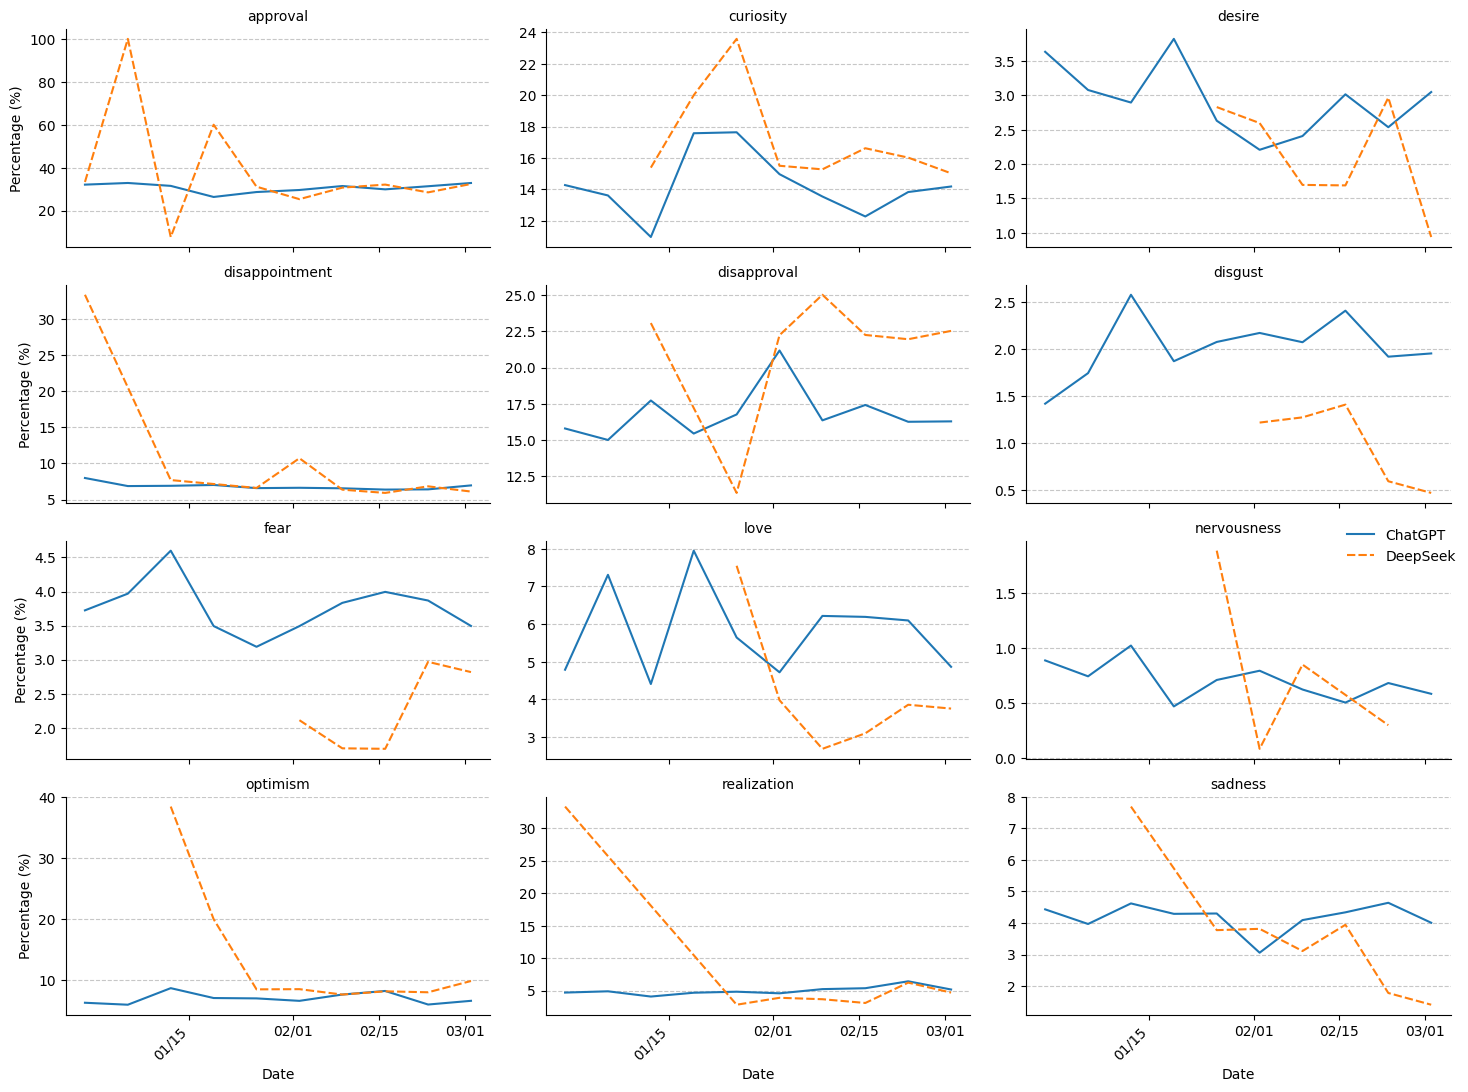

In [ ]:
# Create a FacetGrid with small multiples for each emotion
g = sns.FacetGrid(emotion_pct, col="emotion_labels", col_wrap=3, height=3, aspect=1.5, sharey=False)
g.map_dataframe(sns.lineplot, x="date", y="percentage", hue="subreddit", style="subreddit")

# Add a legend
g.add_legend()

# Set titles for each subplot
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Date", "Percentage (%)")

# Fix the crowded x-axis by reducing the number of date ticks
for ax in g.axes.flat:
    # Show only every nth label (adjust n as needed)
    n = 3  # Show every 3rd label
    ticks = ax.get_xticks()
    ax.set_xticks(ticks[::n])

    # Format dates to be more compact
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

    # Rotate labels diagonally for better readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # Add gridlines for better readability
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Apply custom tick positions based on important dates:
important_dates = ['2025-01-15', '2025-02-01', '2025-02-15', '2025-03-01']
ax.set_xticks([pd.to_datetime(date) for date in important_dates])



# Adjust layout to make room for rotated labels
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)

# Save and show
plt.savefig('emotion_facet_grid.png', dpi=300, bbox_inches='tight')
plt.show()

#### Sentiment shift (2024/12/19 - 2025/03/02)

In [ ]:
# make sure date is type of datetime
emotion_df['date'] = pd.to_datetime(emotion_df['date'])

# data aggregation and transfer
# Group and count by week, subreddit, and sentiment category
sentiment_over_time = emotion_df.groupby(
    [pd.Grouper(key='date', freq='W'), 'subreddit', 'sentiment_category']
).size()

# Convert to the format required for visualization
# First create a DataFrame
sentiment_counts = sentiment_over_time.reset_index(name='count')

# Calculate the weekly totals for each subreddit
total_counts = sentiment_counts.groupby(['date', 'subreddit'])['count'].sum().reset_index(name='total')

# Merge back to original data and calculate percentages
sentiment_pct = pd.merge(sentiment_counts, total_counts, on=['date', 'subreddit'])
sentiment_pct['percentage'] = (sentiment_pct['count'] / sentiment_pct['total']) * 100

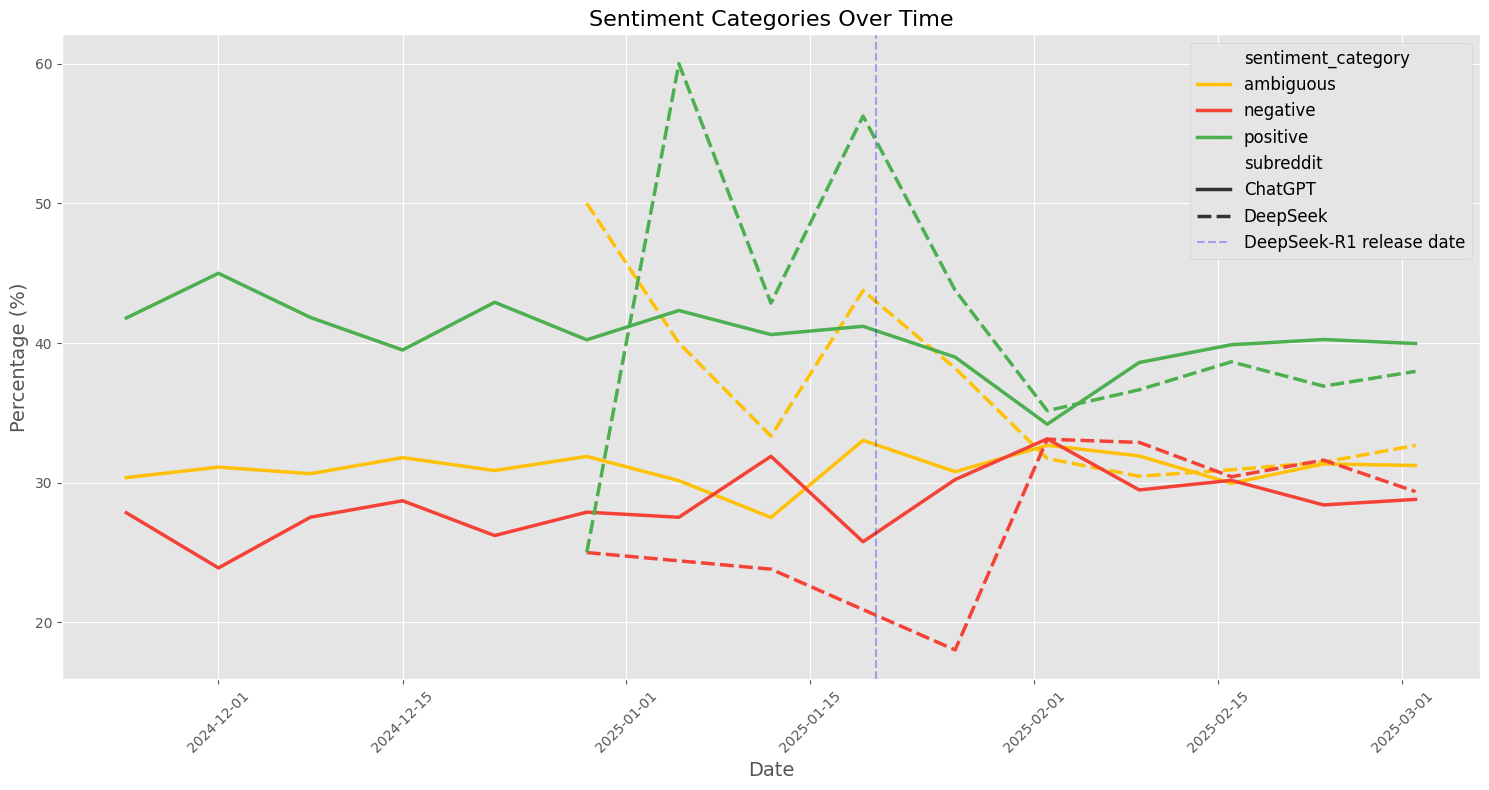

In [ ]:
# Visualization

plt.figure(figsize=(15, 8))

# Draw a line chart
sns.lineplot(
    data=sentiment_pct,
    x='date',
    y='percentage',
    hue='sentiment_category',
    style='subreddit',
    markers=False,
    dashes=True,
    linewidth=2.5,
    palette=sentiment_colors
)

# Add a vertical line for a specific date
specific_date = pd.to_datetime('2025-01-20')  # R1 release date
plt.axvline(x=specific_date, color='blue', linestyle='--', alpha=0.3,
            label='DeepSeek-R1 release date')


# Set the chart format
plt.title('Sentiment Categories Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.legend(title='', fontsize=12)

# Format date axis
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

##### Focus (2024/12/29 - 2025/03/02)

In [ ]:
# make sure date is type of datetime
emotion_df = emotion_df[emotion_df['date'] > pd.to_datetime('2024-12-27')]

# data aggregation and transfer
# Group and count by week, subreddit, and sentiment category
sentiment_over_time = emotion_df.groupby(
    [pd.Grouper(key='date', freq='W'), 'subreddit', 'sentiment_category']
).size()

# Convert to the format required for visualization
# First create a DataFrame
sentiment_counts = sentiment_over_time.reset_index(name='count')

# Calculate the weekly totals for each subreddit
total_counts = sentiment_counts.groupby(['date', 'subreddit'])['count'].sum().reset_index(name='total')

# Merge back to original data and calculate percentages
sentiment_pct = pd.merge(sentiment_counts, total_counts, on=['date', 'subreddit'])
sentiment_pct['percentage'] = (sentiment_pct['count'] / sentiment_pct['total']) * 100

In [ ]:
sentiment_pct.head()

date subreddit sentiment_category  count  total  percentage
0 2024-12-29   ChatGPT          ambiguous    559   1701   32.863022
1 2024-12-29   ChatGPT           negative    462   1701   27.160494
2 2024-12-29   ChatGPT           positive    680   1701   39.976484
3 2024-12-29  DeepSeek          ambiguous      2      4   50.000000
4 2024-12-29  DeepSeek           negative      1      4   25.000000

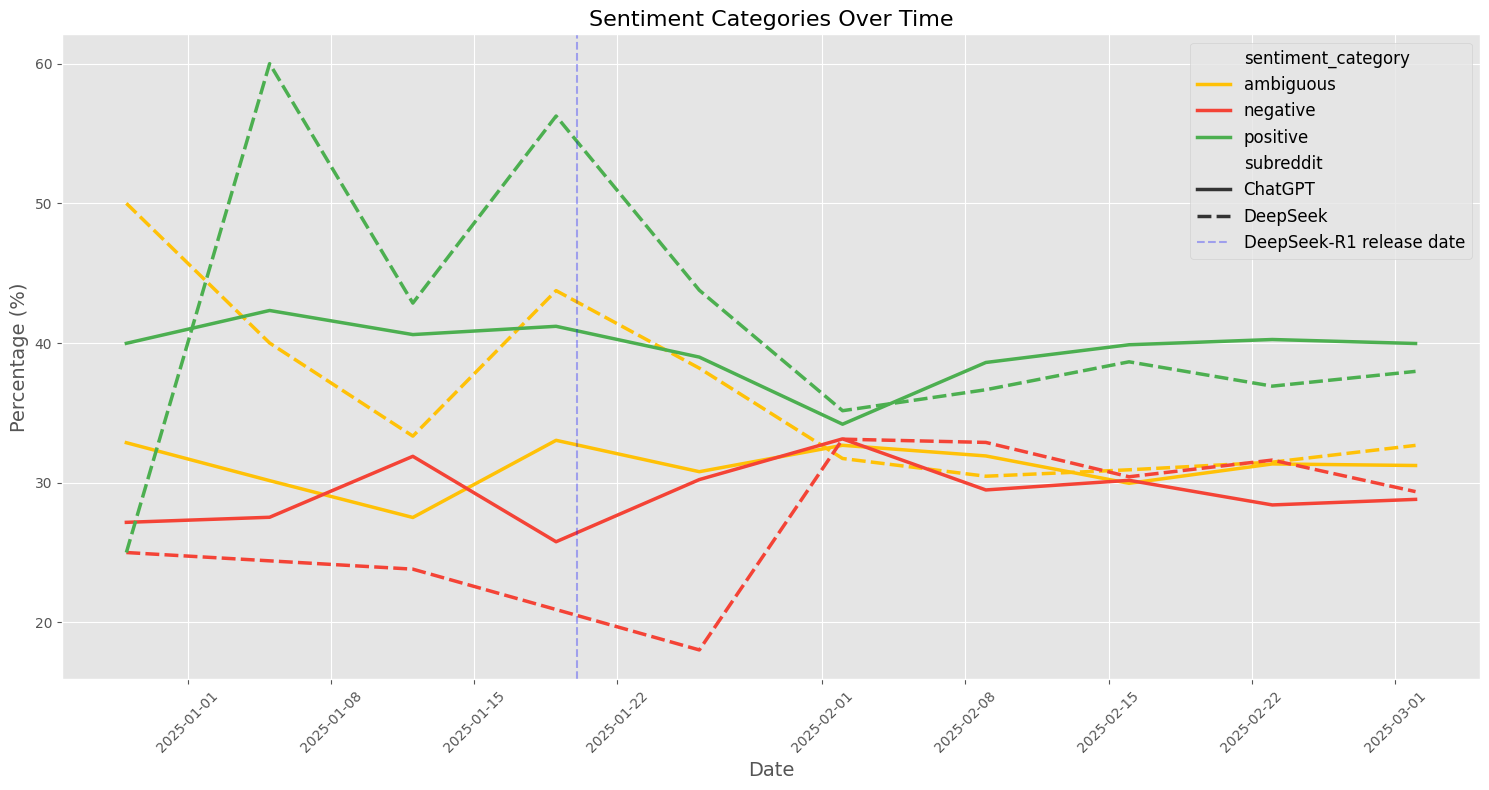

In [ ]:
# Visualization

plt.figure(figsize=(15, 8))

# Draw a line chart
sns.lineplot(
    data=sentiment_pct,
    x='date',
    y='percentage',
    hue='sentiment_category',
    style='subreddit',
    markers=False,
    dashes=True,
    linewidth=2.5,
    palette=
)

# Add a vertical line for a specific date
specific_date = pd.to_datetime('2025-01-20')  # R1 release date
plt.axvline(x=specific_date, color='blue', linestyle='--', alpha=0.3,
            label='DeepSeek-R1 release date')


# Set the chart format
plt.title('Sentiment Categories Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.legend(title='', fontsize=12)

# Format date axis
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Topic Modeling

### Tagging with BERTopic

In [ ]:
# 1. Load and prepare your data
df = pd.read_csv('/content/drive/MyDrive/data_w_emotion_sentiment.csv')

In [ ]:
len(df)

177566

In [ ]:
chatgpt_df = df[df['subreddit'] == 'ChatGPT']
deepseek_df = df[df['subreddit'] == 'DeepSeek']

In [ ]:
chatgpt_docs = df[df['subreddit'] == 'ChatGPT']['text'].tolist()
deepseek_docs = df[df['subreddit'] == 'DeepSeek']['text'].tolist()

In [ ]:
print(len(chatgpt_docs))
print(len(deepseek_docs))

161818
15748


In [ ]:
chatgpt_df = chatgpt_df.sort_values('date')
sample_fraction = 0.1
sampled_chatgpt_df = chatgpt_df.groupby(['date'], group_keys=False).apply(
    lambda x: x.sample(frac=sample_fraction)
)
print(f"Sampled {len(sampled_chatgpt_df)} documents (1/10 of the original dataset).")


Sampled 16179 documents (1/10 of the original dataset).


<ipython-input-92-ef58f1851193>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_chatgpt_df = chatgpt_df.groupby(['date'], group_keys=False).apply(


In [ ]:
chatgpt_df = sampled_chatgpt_df

In [ ]:
chatgpt_docs = sampled_chatgpt_df[sampled_chatgpt_df['subreddit'] == 'ChatGPT']['text'].tolist()

In [ ]:
chatgpt_docs

['You don t remember correctly It was down all the time when it came out and the months after',
 'Never said Erika was the only german song to exist I was making a joke Strawman fallacy at it s finest',
 'OK no issues logged in as usual So to me it s your Firefox Did you say you tried to disabled all your add ons Are you sure everything is updated',
 'Completely different conversation but using the same computer and same account Maybe you could try it It would be interesting',
 'You re only finding it efficient because you don t question it s results which in turn harms it s efficacy',
 'Yes but China s sensitivity on the topic is the only reason that the USA doesn t officially recognize Taiwan and everybody outside of China thinks of Taiwan as a separate sovereign nation Actually ChatGPT did a pretty good job of summarizing that issue when I asked the question Compare that to DeepSeek which might as well have copy pasted the official CCP line',
 'That may be but it s superior to 99 9 

In [ ]:
# Create and run BERTopic model
topic_model = BERTopic(
    # embedding_model
    embedding_model="all-MiniLM-L6-v2",

    # Topic representation
    vectorizer_model=CountVectorizer(
        ngram_range=(1, 3),             # Include 1-3 word phrases
        stop_words="english",           # Remove English stopwords
        min_df=5,                       # Ignore terms appearing in < 5 documents
        max_df=0.8                      # Ignore terms appearing in > 80% of documents
    ),

    # Additional settings
    calculate_probabilities=True,       # Get topic probabilities
    verbose=True                        # Show progress
)

#### ChatGPT

##### default number of tipics -chatgpt (too long to complete)

In [ ]:
# Fit the model on your documents
topics, probs = topic_model.fit_transform(chatgpt_docs)

# Examine topic information
topic_info = topic_model.get_topic_info()
print(topic_info.head(10))  # Show top 10 topics

2025-03-09 01:29:23,248 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/5057 [00:00<?, ?it/s]

2025-03-09 02:32:01,946 - BERTopic - Embedding - Completed ✓
2025-03-09 02:32:01,948 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-03-09 02:37:16,565 - BERTopic - Dimensionality - Completed ✓
2025-03-09 02:37:16,581 - BERTopic - Cluster - Start clustering the reduced embeddings
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_

##### Restrained with stopwords, start with 50 topics

In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

nltk_stopwords = stopwords.words("english")

vectorizer_model = CountVectorizer(
    ngram_range=(1, 3),
    stop_words=nltk_stopwords,
    min_df=5,
    max_df=0.8
)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
topic_model = BERTopic(
    nr_topics=50,
    embedding_model="all-MiniLM-L6-v2",
    vectorizer_model=vectorizer_model,
    calculate_probabilities=True,
    verbose=True
)

In [ ]:
topics, probs = topic_model.fit_transform(chatgpt_docs)

2025-03-09 11:47:54,188 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/506 [00:00<?, ?it/s]

2025-03-09 11:47:59,221 - BERTopic - Embedding - Completed ✓
2025-03-09 11:47:59,222 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-09 11:48:03,474 - BERTopic - Dimensionality - Completed ✓
2025-03-09 11:48:03,476 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-09 11:48:26,722 - BERTopic - Cluster - Completed ✓
2025-03-09 11:48:26,723 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-09 11:48:27,929 - BERTopic - Representation - Completed ✓
2025-03-09 11:48:27,930 - BERTopic - Topic reduction - Reducing number of topics
2025-03-09 11:48:29,064 - BERTopic - Topic reduction - Reduced number of topics from 179 to 50


In [ ]:
topic_info = topic_model.get_topic_info()
topic_info

Topic  Count                                 Name  \
0      -1   7909                -1_ai_chatgpt_us_work   
1       0   1078                   0_ai_agi_art_human   
2       1    626          1_chatgpt_chat_chat gpt_gpt   
3       2    389          2_deepseek_grok_open_openai   
4       3    341     3_engineers_money_capitalism_job   
5       4    321           4_voice_voice mode_mode_em   
6       5    317    5_china_chinese_censorship_square   
7       6    310           6_bias_biased_wikipedia_op   
8       7    309                      7_o1_o3_mini_4o   
9       8    304         8_code_prompt_prompts_python   
10      9    300    9_bot_bots_copyright_social media   
11     10    253      10_therapist_therapy_medical_ai   
12     11    251    11_app_browser_instructions_error   
13     12    243              12_elon_musk_sam_altman   
14     13    198          13_looks_look like_left_pic   
15     14    190       14_google_search_location_data   
16     15    185       15_trump_biden_president_voted   
17     16    180         16_llms_llm_word_information   
18     17    177             17_women_men_dating_porn   
19     18    173    18_homework_school_parents_sister   
20     19    170    19_openai_source_open source_open   
21     20    168       20_energy_water_climate_carbon   
22     21    168              21_gpt_gpts_custom_gpt4   
23     22    129     22_math_strawberry_calculator_11   
24     23    118            23_nazi_nazis_heart_video   
25     24    117       24_eating_recipe_roast_chicken   
26     25    112     25_opt_delete_funny_successfully   
27     26    111    26_image_username_generate_images   
28     27    107  27_memory_memories_remember_feature   
29     28     98                28_cat_cats_bear_cute   
30     29     96       29_gemini_claude_studio_google   
31     30     93            30_drugs_drink_worst_high   
32     31     83          31_link_remind_commenter_pm   
33     32     74        32_religion_god_jesus_believe   
34     33     72             33_name_named_chose_mine   
35     34     57         34_slaves_life_success_slave   
36     35     49           35_song_music_wrote_praise   
37     36     49    36_conspiracy_theories_crash_post   
38     37     44         37_video_youtube_videos_sora   
39     38     39      38_feeling_parents_friends_feel   
40     39     27  39_indian_black_racism_black people   
41     40     22              40_glass_full_red_drink   
42     41     21      41_intense_45_movements_working   
43     42     21                       42_de_se_la_eu   
44     43     18            43_years old_old_40_years   
45     44     16             44_90s_movies_movie_film   
46     45     12  45_diffusion_stable_images_training   
47     46     12             46_book_beta_sell_nobody   
48     47     11    47_glasses_look like_awkward_bond   
49     48     11            48_bill_illegal_vote_held   

                                       Representation  \
0   [ai, chatgpt, us, work, things, say, ask, chat...   
1   [ai, agi, art, human, consciousness, robot, hu...   
2   [chatgpt, chat, chat gpt, gpt, subscription, p...   
3   [deepseek, grok, open, openai, r1, chatgpt, mo...   
4   [engineers, money, capitalism, job, jobs, link...   
5   [voice, voice mode, mode, em, advanced voice, ...   
6   [china, chinese, censorship, square, country, ...   
7   [bias, biased, wikipedia, op, opinion, thinkin...   
8   [o1, o3, mini, 4o, o3 mini, model, models, o1 ...   
9   [code, prompt, prompts, python, copilot, codin...   
10  [bot, bots, copyright, social media, social, m...   
11  [therapist, therapy, medical, ai, doctor, hall...   
12  [app, browser, instructions, error, button, cu...   
13  [elon, musk, sam, altman, trump, sam altman, t...   
14  [looks, look like, left, pic, photo, face, shi...   
15  [google, search, location, data, vpn, ip, web,...   
16  [trump, biden, president, voted, vote, america...   
17  [llms, llm, word, information, human, work, le...   
18  [women, m

In [ ]:
# Cut it to 20
topic_model.reduce_topics(chatgpt_docs, nr_topics=20)

2025-03-09 11:51:26,112 - BERTopic - Topic reduction - Reducing number of topics
2025-03-09 11:51:27,277 - BERTopic - Topic reduction - Reduced number of topics from 50 to 20


In [ ]:
reduced_topic_info = topic_model.get_topic_info()
print("Reduced to 20 topics:", reduced_topic_info[["Topic", "Count"]])

Reduced to 20 topics:     Topic  Count
0      -1   7909
1       0   4131
2       1   1872
3       2    457
4       3    385
5       4    358
6       5    302
7       6    266
8       7    139
9       8    118
10      9     93
11     10     27
12     11     21
13     12     21
14     13     18
15     14     16
16     15     12
17     16     12
18     17     11
19     18     11


In [ ]:
reduced_topic_info

Topic  Count                                     Name  \
0      -1   7909                  -1_ai_chatgpt_would_one   
1       0   4131                0_ai_chatgpt_deepseek_use   
2       1   1872                  1_china_trump_elon_musk   
3       2    457                  2_look_cat_looks_delete   
4       3    385                  3_ai_chatgpt_human_need   
5       4    358       4_memory_app_remember_instructions   
6       5    302                5_homework_math_school_11   
7       6    266           6_image_username_name_generate   
8       7    139                 7_glass_chicken_eat_made   
9       8    118               8_heart_video_elon_context   
10      9     93               9_video_song_music_youtube   
11     10     27  10_indian_black_individual_black people   
12     11     21                           11_de_se_la_eu   
13     12     21              12_got_45_working_movements   
14     13     18                13_years old_old_40_years   
15     14     16                 14_90s_movie_scene_watch   
16     15     12          15_stable_images_training_train   
17     16     12            16_book_read_nobody_years ago   
18     17     11        17_glasses_look_look like_awkward   
19     18     11          18_illegal_held_wild_government   

                                       Representation  \
0   [ai, chatgpt, would, one, get, know, use, some...   
1   [ai, chatgpt, deepseek, use, gpt, model, would...   
2   [china, trump, elon, musk, us, would, get, goi...   
3   [look, cat, looks, delete, one, right, funny, ...   
4   [ai, chatgpt, human, need, feel, things, medic...   
5   [memory, app, remember, instructions, working,...   
6   [homework, math, school, 11, parents, kids, ca...   
7   [image, username, name, generate, link, mine, ...   
8   [glass, chicken, eat, made, day, food, egg, co...   
9   [heart, video, elon, context, crowd, arm, roma...   
10  [video, song, music, youtube, videos, months, ...   
11  [indian, black, individual, black people, whit...   
12  [de, se, la, eu, plus, com, pro, grand, dan, v...   
13  [got, 45, working, movements, back, drink, sit...   
14  [years old, old, 40, years, age, 22, worded, y...   
15  [90s, movie, scene, watch, high, show, word, s...   
16  [stable, images, training, train, personal, gi...   
17  [book, read, nobody, years ago, got, available...   
18  [glasses, look, look like, awkward, bond, woul...   
19  [illegal, held, wild, government, like asked, ...   

                                  Representative_Docs  
0   [Well no one speaks to me like game NPCs eithe...  
1   [They stole data that we stole Now our ai is o...  
2   [I don t know I m not up on this but it s inte...  
3   [Aren t you doing that Now too Wait are we in ...  
4   [So I know that ChatGPT doesn t really have co...  
5   [Ah Okay I asked him Just start a new chat and...  
6   [Teachers need to adapt because AI isn t going...  
7   [u SquidGameViolence i am so curious what it w...  
8   [Absolutely a coupe glass like for sipping a g...  
9   [You are brain dead for thinking it s an actua...  
10  [by rephrasing your question better what is fl...  
11  [That s not a fucking Indian wtf I m Indian He...  
12  [Ofrecele una recompensa de 20 dolares 200 o 1...  
13  [wow I watched video of guy doing multiple day...  
14  [You mentioned that you were turning 40 on Oct...  
15  [100 but back in the day there were like 4 thi...  
16  [I really try to use lots of LLMs My focus is ...  
17  [That s cool Looks like a potential book cover...  
18  [The real issue here is that nerds do not actu...  
19  [FISA has been held up in court as constitutio...

In [ ]:
# Step 2: Reassign documents to these reduced topics
final_topics, final_probs = topic_model.transform(chatgpt_docs)
print(f"Number of unique topics after reduction: {len(set(final_topics))}")

Batches:   0%|          | 0/506 [00:00<?, ?it/s]

2025-03-09 11:51:43,985 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-03-09 11:51:44,032 - BERTopic - Dimensionality - Completed ✓
2025-03-09 11:51:44,033 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-03-09 11:51:44,713 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-03-09 11:52:10,907 - BERTopic - Probabilities - Completed ✓
2025-03-09 11:52:10,907 - BERTopic - Cluster - Completed ✓


Number of unique topics after reduction: 20


In [ ]:
# Step 3: Handle outliers
final_topics = topic_model.reduce_outliers(chatgpt_docs, final_topics)
print(f"Number of unique topics after outlier reduction: {len(set(final_topics))}")

100%|██████████| 8/8 [00:01<00:00,  4.92it/s]


Number of unique topics after outlier reduction: 20


In [ ]:
# Step 4: Save the final topic information
chatgpt_topic_info = topic_model.get_topic_info()
chatgpt_topic_info

Topic  Count                                     Name  \
0      -1   7909                  -1_ai_chatgpt_would_one   
1       0   4131                0_ai_chatgpt_deepseek_use   
2       1   1872                  1_china_trump_elon_musk   
3       2    457                  2_look_cat_looks_delete   
4       3    385                  3_ai_chatgpt_human_need   
5       4    358       4_memory_app_remember_instructions   
6       5    302                5_homework_math_school_11   
7       6    266           6_image_username_name_generate   
8       7    139                 7_glass_chicken_eat_made   
9       8    118               8_heart_video_elon_context   
10      9     93               9_video_song_music_youtube   
11     10     27  10_indian_black_individual_black people   
12     11     21                           11_de_se_la_eu   
13     12     21              12_got_45_working_movements   
14     13     18                13_years old_old_40_years   
15     14     16                 14_90s_movie_scene_watch   
16     15     12          15_stable_images_training_train   
17     16     12            16_book_read_nobody_years ago   
18     17     11        17_glasses_look_look like_awkward   
19     18     11          18_illegal_held_wild_government   

                                       Representation  \
0   [ai, chatgpt, would, one, get, know, use, some...   
1   [ai, chatgpt, deepseek, use, gpt, model, would...   
2   [china, trump, elon, musk, us, would, get, goi...   
3   [look, cat, looks, delete, one, right, funny, ...   
4   [ai, chatgpt, human, need, feel, things, medic...   
5   [memory, app, remember, instructions, working,...   
6   [homework, math, school, 11, parents, kids, ca...   
7   [image, username, name, generate, link, mine, ...   
8   [glass, chicken, eat, made, day, food, egg, co...   
9   [heart, video, elon, context, crowd, arm, roma...   
10  [video, song, music, youtube, videos, months, ...   
11  [indian, black, individual, black people, whit...   
12  [de, se, la, eu, plus, com, pro, grand, dan, v...   
13  [got, 45, working, movements, back, drink, sit...   
14  [years old, old, 40, years, age, 22, worded, y...   
15  [90s, movie, scene, watch, high, show, word, s...   
16  [stable, images, training, train, personal, gi...   
17  [book, read, nobody, years ago, got, available...   
18  [glasses, look, look like, awkward, bond, woul...   
19  [illegal, held, wild, government, like asked, ...   

                                  Representative_Docs  
0   [Well no one speaks to me like game NPCs eithe...  
1   [They stole data that we stole Now our ai is o...  
2   [I don t know I m not up on this but it s inte...  
3   [Aren t you doing that Now too Wait are we in ...  
4   [So I know that ChatGPT doesn t really have co...  
5   [Ah Okay I asked him Just start a new chat and...  
6   [Teachers need to adapt because AI isn t going...  
7   [u SquidGameViolence i am so curious what it w...  
8   [Absolutely a coupe glass like for sipping a g...  
9   [You are brain dead for thinking it s an actua...  
10  [by rephrasing your question better what is fl...  
11  [That s not a fucking Indian wtf I m Indian He...  
12  [Ofrecele una recompensa de 20 dolares 200 o 1...  
13  [wow I watched video of guy doing multiple day...  
14  [You mentioned that you were turning 40 on Oct...  
15  [100 but back in the day there were like 4 thi...  
16  [I really try to use lots of LLMs My focus is ...  
17  [That s cool Looks like a potential book cover...  
18  [The real issue here is that nerds do not actu...  
19  [FISA has been held up in court as constitutio...

In [ ]:
chatgpt_topic_info.to_csv("/content/drive/MyDrive/sampled_chatgpt_topic_info.csv", index=False)

In [ ]:
# Step 5: Save the documents with their final assigned topics
chatgpt_df['topics'] = final_topics  # Use the final topics
chatgpt_df

subreddit             author        date  \
16667    ChatGPT         DerKernsen  2024-12-27   
16686    ChatGPT  GiveUsernameldeas  2024-12-27   
16664    ChatGPT    Technologytwitt  2024-12-27   
16536    ChatGPT       arturomartin  2024-12-27   
16140    ChatGPT        Glorious_Jo  2024-12-27   
...          ...                ...         ...   
177518   ChatGPT           SafariNZ  2025-03-01   
176825   ChatGPT          rhydhimma  2025-03-01   
176069   ChatGPT        Virtamancer  2025-03-01   
176849   ChatGPT      bakawakaflaka  2025-03-01   
177210   ChatGPT          rhydhimma  2025-03-01   

                                                     text      type  \
16667   You don t remember correctly It was down all t...  comments   
16686   Never said Erika was the only german song to e...  comments   
16664   OK no issues logged in as usual So to me it s ...  comments   
16536   Completely different conversation but using th...  comments   
16140   You re only finding it efficient because you d...  comments   
...                                                   ...       ...   
177518  Gapminder just released a couple of short vide...  comments   
176825  I get your point But It wouldn t have hurt to ...  comments   
176069  You d find more outspoken right everywhere tha...  comments   
176849  Now imagine that 40 of the population entering...  comments   
177210  Sorry for the confusion I think we weren t tal...  comments   

                                             emotions_txt emotion_labels  \
16667   {'label': 'neutral', 'score': 0.8324307799339294}        neutral   
16686   {'label': 'amusement', 'score': 0.738492548465...      amusement   
16664    {'label': 'neutral', 'score': 0.527859628200531}        neutral   
16536   {'label': 'excitement', 'score': 0.41614153981...     excitement   
16140   {'label': 'neutral', 'score': 0.6510036587715149}        neutral   
...                                                   ...            ...   
177518    {'label': 'neutral', 'score': 0.58687824010849}        neutral   
176825  {'label': 'approval', 'score': 0.8030238747596...       approval   
176069  {'label': 'neutral', 'score': 0.5846637487411499}        neutral   
176849  {'label': 'neutral', 'score': 0.6531468629837036}        neutral   
177210  {'label': 'confusion', 'score': 0.681108236312...      confusion   

        emotion_prob sentiment_category  topics  
16667       0.832431            neutral       4  
16686       0.738493          ambiguous       8  
16664       0.527860            neutral       4  
16536       0.416142           positive       0  
16140       0.651004            neutral       0  
...              ...                ...     ...  
177518      0.586878            neutral       0  
176825      0.803024           positive      17  
176069      0.584664            neutral       2  
176849      0.653147            neutral       0  
177210      0.681108          ambiguous       0  

[16179 rows x 10 columns]

In [ ]:
chatgpt_df.to_csv("/content/drive/MyDrive/sampled_chatgpt_w_topic.csv", index=False)

In [ ]:
# Step 6: Save the topic probabilities
ds_probs_df = pd.DataFrame(final_probs)
ds_probs_df

0             1             2             3             4   \
0      2.486627e-01  1.100498e-01  2.313031e-02  2.791430e-02  1.632573e-01   
1      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00   
3      8.380276e-01  3.339703e-04  7.782390e-05  9.450919e-05  5.752620e-04   
4      9.647965e-01  3.044678e-22  4.857795e-23  7.444637e-23  3.572550e-23   
...             ...           ...           ...           ...           ...   
16174  8.560911e-01  2.985575e-03  1.366847e-04  8.305356e-05  2.943559e-05   
16175  2.424916e-01  1.446162e-01  3.260517e-02  3.398627e-02  1.282611e-02   
16176  1.569824e-09  5.255581e-01  7.375402e-14  9.645002e-20  9.479115e-21   
16177  6.157925e-01  1.357036e-01  5.400666e-34  1.198028e-47  2.700483e-49   
16178  9.999998e-01  7.937509e-08  1.444255e-08  7.838015e-09  2.929823e-09   

                 5             6             7             8             9   \
0      1.663773e-02  3.117701e-02  4.517265e-03  7.216475e-03  1.361999e-02   
1      0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  0.000000e+00   
2      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
3      5.467857e-05  9.097985e-05  1.765264e-05  2.171206e-05  4.139176e-05   
4      3.041368e-23  5.844215e-23  3.686989e-24  1.692587e-23  3.130140e-23   
...             ...           ...           ...           ...           ...   
16174  4.300862e-05  2.041436e-04  8.568644e-06  5.695255e-05  2.180515e-04   
16175  2.807720e-02  2.555505e-02  9.550994e-03  7.508962e-03  1.331352e-02   
16176  4.993949e-21  1.307840e-13  4.827784e-22  9.180214e-18  2.648407e-10   
16177  1.199126e-49  9.749502e-34  6.859003e-51  7.257158e-45  1.300161e-03   
16178  4.452062e-09  1.771691e-08  1.137916e-09  4.794750e-09  2.439187e-08   

                 10            11            12            13            14  \
0      2.647013e-03  4.816092e-04  2.884968e-03  2.074473e-03  3.108520e-03   
1      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
3      1.068553e-05  2.448173e-06  9.385428e-06  7.076891e-06  9.064460e-06   
4      2.248178e-24  2.108222e-25  6.069869e-24  3.149942e-24  7.955784e-24   
...             ...           ...           ...           ...           ...   
16174  6.065594e-06  8.357115e-07  6.291409e-06  5.150104e-06  8.089286e-05   
16175  5.774375e-03  1.056132e-36  3.211209e-03  3.392587e-03  3.559780e-03   
16176  4.413433e-22  2.202064e-23  1.629546e-21  6.353583e-22  1.433454e-10   
16177  5.428338e-51  2.765688e-52  3.980123e-50  1.213903e-50  7.169925e-04   
16178  8.391285e-10  1.150264e-10  6.483614e-10  6.140624e-10  7.240890e-09   

                 15            16            17            18  
0      2.808710e-03  3.326764e-03  9.784163e-04  2.646918e-03  
1      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
2      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
3      8.649095e-06  9.751172e-06  4.455291e-06  7.810614e-06  
4      4.528337e-24  1.027039e-23  7.289231e-25  6.623327e-24  
...             ...           ...           ...           ...  
16174  6.960497e-06  2.171244e-05  2.592822e-06  5.487575e-05  
16175  3.115810e-03  4.617306e-03  3.268850e-32  3.008618e-03  
16176  1.086310e-21  5.159700e-20  1.016172e-22  1.054899e-01  
16177  2.590225e-50  5.973532e-48  1.471563e-51  1.875775e-14  
16178  9.458123e-10  1.741797e-09  3.194546e-10  3.326828e-09  

[16179 rows x 19 columns]

In [ ]:
ds_probs_df.to_csv("/content/drive/MyDrive/sampled_chatgpt_doc_probs.csv", index=False)


In [ ]:
# Step 7: Save the entire model
topic_model.save("/content/drive/MyDrive/my_bertopic_model_chatgpt_sampled")

2025-03-09 11:53:01,560 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [ ]:
# Visualize Topics
topic_model.visualize_hierarchy()

In [ ]:
topic_model.visualize_barchart()

#### DeepSeek

##### default number of topics - deepseek

In [ ]:
# Fit the model on your documents
deepseek_topics, deepseek_probs = topic_model.fit_transform(deepseek_docs)

# Examine topic information
deepseek_topic_info = topic_model.get_topic_info()
print(deepseek_topic_info.head(10))  # Show top 10 topics

2025-03-09 04:14:57,969 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/493 [00:00<?, ?it/s]

2025-03-09 04:15:02,249 - BERTopic - Embedding - Completed ✓
2025-03-09 04:15:02,250 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-09 04:15:07,373 - BERTopic - Dimensionality - Completed ✓
2025-03-09 04:15:07,374 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-09 04:15:30,508 - BERTopic - Cluster - Completed ✓
2025-03-09 04:15:30,514 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-09 04:15:31,031 - BERTopic - Representation - Completed ✓


   Topic  Count                            Name  \
0     -1   6079               -1_the_it_you_and   
1      0    523                 0_ai_to_an_this   
2      1    482  1_chatgpt_deepseek_chat_better   
3      2    363              2_ram_gpu_run_vram   
4      3    305           3_chatgpt_chat_new_it   
5      4    277      4_gmail_email_code_account   
6      5    249      5_china_chinese_us_america   
7      6    214     6_busy_server_later_servers   
8      7    213      7_openai_their_they_models   
9      8    199              8_llm_llms_use_how   

                                      Representation  \
0     [the, it, you, and, to, of, is, that, for, in]   
1  [ai, to, an, this, be, that, of, and, for, human]   
2  [chatgpt, deepseek, chat, better, use, gpt, th...   
3  [ram, gpu, run, vram, nvidia, model, 14b, 32b,...   
4  [chatgpt, chat, new, it, gpt, same, was, time,...   
5  [gmail, email, code, account, sign, google, tr...   
6  [china, chinese, us, america, usa, world, c

In [ ]:
deepseek_topic_info

Topic  Count                                              Name  \
0       -1   6741                     -1_deepseek_chinese_use_model   
1        0    516                        0_ai_use ai_using ai_human   
2        1    384          1_chatgpt_chat_deepseek_chatgpt deepseek   
3        2    312  2_deepseek_using deepseek_questions_use deepseek   
4        3    257                       3_china_america_chinese_usa   
..     ...    ...                                               ...   
173    172     10             172_misinformation_believe_lie_tricky   
174    173     10           173_memes_work just_critical_doesn work   
175    174     10             174_creativity_chose_product_comeback   
176    175     10                  175_western_west_wealth_starting   
177    176     10            176_expression_response_time tried_def   

                                        Representation  \
0    [deepseek, chinese, use, model, people, china,...   
1    [ai, use ai, using ai, human, ai model, humans...   
2    [chatgpt, chat, deepseek, chatgpt deepseek, ch...   
3    [deepseek, using deepseek, questions, use deep...   
4    [china, america, chinese, usa, countries, worl...   
..                                                 ...   
173  [misinformation, believe, lie, tricky, dont ca...   
174  [memes, work just, critical, doesn work, polit...   
175  [creativity, chose, product, comeback, just wo...   
176  [western, west, wealth, starting, country, pro...   
177  [expression, response, time tried, def, felt l...   

                                   Representative_Docs  
0    [It is a broad subject I could have asked the ...  
1    [The only real PRACTICAL use of any AI softwar...  
2    [Here are 3 good options to use Deepseek R1 wi...  
3    [You can use Deepseek R1 in the rewrite the pr...  
4    [China is the one giving predatory loans to co...  
..                                                 ...  
173  [I dont care if you believe me or not why woul...  
174  [I highly doubt the intended purpose of DeepSe...  
175  [The gender assignment is not necessarily cons...  
176  [Every declining and falling empire becomes al...  
177  [Thus was his introduction to the expression t...  

[178 rows x 5 columns]

##### Retrain with stopwords removed

In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

nltk_stopwords = stopwords.words("english")

vectorizer_model = CountVectorizer(
    ngram_range=(1, 3),
    stop_words=nltk_stopwords,
    min_df=5,
    max_df=0.8
)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
topic_model = BERTopic(
    embedding_model="all-MiniLM-L6-v2",
    vectorizer_model=vectorizer_model,
    calculate_probabilities=True,
    verbose=True
)

In [ ]:
# Fit the model on your documents
deepseek_topics, deepseek_probs = topic_model.fit_transform(deepseek_docs)

# Examine topic information
deepseek_topic_info = topic_model.get_topic_info()
print(deepseek_topic_info.head(10))  # Show top 10 topics

2025-03-09 04:36:47,877 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/493 [00:00<?, ?it/s]

2025-03-09 04:36:53,654 - BERTopic - Embedding - Completed ✓
2025-03-09 04:36:53,655 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-09 04:36:58,170 - BERTopic - Dimensionality - Completed ✓
2025-03-09 04:36:58,171 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-09 04:37:17,333 - BERTopic - Cluster - Completed ✓
2025-03-09 04:37:17,340 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-09 04:37:18,421 - BERTopic - Representation - Completed ✓


   Topic  Count                                 Name  \
0     -1   5691           -1_chinese_us_people_china   
1      0    736  0_deepseek_server_busy_use deepseek   
2      1    569          1_chatgpt_chat_chat gpt_new   
3      2    478       2_chatgpt_chat_deepseek_better   
4      3    459                   3_ram_gpu_run_vram   
5      4    444           4_ai_use ai_using ai_human   
6      5    384      5_china_chinese_america_country   
7      6    277           6_gmail_email_code_account   
8      7    227      7_post_question_reddit_downvote   
9      8    221         8_llm_llms_use llms_training   

                                      Representation  \
0  [chinese, us, people, china, use, deepseek, mo...   
1  [deepseek, server, busy, use deepseek, server ...   
2  [chatgpt, chat, chat gpt, new, chats, gpt, tim...   
3  [chatgpt, chat, deepseek, better, chat gpt, gp...   
4  [ram, gpu, run, vram, 14b, nvidia, 32b, model,...   
5  [ai, use ai, using ai, human, ai model, huma

In [ ]:
deepseek_topic_info

Topic  Count                                           Name  \
0       -1   5691                     -1_chinese_us_people_china   
1        0    736            0_deepseek_server_busy_use deepseek   
2        1    569                    1_chatgpt_chat_chat gpt_new   
3        2    478                 2_chatgpt_chat_deepseek_better   
4        3    459                             3_ram_gpu_run_vram   
..     ...    ...                                            ...   
151    150     11  150_english_chinese_questions chinese_respond   
152    151     11    151_public_theft_lied_intellectual property   
153    152     11                152_seconds_solve_circle_record   
154    153     10      153_jailbreaks_external_jailbreak_filters   
155    154     10        154_deepseek llm_llm_training data_llms   

                                        Representation  \
0    [chinese, us, people, china, use, deepseek, mo...   
1    [deepseek, server, busy, use deepseek, server ...   
2    [chatgpt, chat, chat gpt, new, chats, gpt, tim...   
3    [chatgpt, chat, deepseek, better, chat gpt, gp...   
4    [ram, gpu, run, vram, 14b, nvidia, 32b, model,...   
..                                                 ...   
151  [english, chinese, questions chinese, respond,...   
152  [public, theft, lied, intellectual property, b...   
153  [seconds, solve, circle, record, 10 minutes, p...   
154  [jailbreaks, external, jailbreak, filters, dee...   
155  [deepseek llm, llm, training data, llms, train...   

                                   Representative_Docs  
0    [If they can t stop the distribution of DeepSe...  
1    [Hey I totally get your frustration with DeepS...  
2    [I am using an extension called Superpower Dee...  
3    [I like the chatGPT app on my ph Its tooling i...  
4    [I run 32b locally on my 24GB GPU 24GB VRAM an...  
..                                                 ...  
151  [Calm down It s no big deal When I ask ChatGPT...  
152  [Not agree They didn t steal That s dsinformat...  
153  [Lately I ve been playing this little game whe...  
154  [Pity that Perplexity shut down the jailbreaks...  
155  [Because LLMs are not hardcoded The training d...  

[156 rows x 5 columns]

##### Retrain with stopwords, start with 50 topics

In [ ]:
topic_model = BERTopic(
    nr_topics=50,
    embedding_model="all-MiniLM-L6-v2",
    vectorizer_model=vectorizer_model,
    calculate_probabilities=True,
    verbose=True
)

In [ ]:
topics, probs = topic_model.fit_transform(deepseek_docs)

2025-03-09 05:09:05,930 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/493 [00:00<?, ?it/s]

2025-03-09 05:09:10,715 - BERTopic - Embedding - Completed ✓
2025-03-09 05:09:10,716 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-09 05:09:14,397 - BERTopic - Dimensionality - Completed ✓
2025-03-09 05:09:14,398 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-09 05:09:35,926 - BERTopic - Cluster - Completed ✓
2025-03-09 05:09:35,926 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-09 05:09:37,032 - BERTopic - Representation - Completed ✓
2025-03-09 05:09:37,033 - BERTopic - Topic reduction - Reducing number of topics
2025-03-09 05:09:38,048 - BERTopic - Topic reduction - Reduced number of topics from 176 to 50


In [ ]:
topic_info

Topic  Count                                               Name  \
0      -1   6454                                   -1_the_it_to_and   
1       0   1764                           0_deepseek_openai_is_the   
2       1    993                         1_chatgpt_chat_deepseek_it   
3       2    864                             2_china_chinese_in_the   
4       3    725                                     3_ai_to_of_the   
5       4    455                          4_code_email_gmail_google   
6       5    452                                   5_the_you_of_and   
7       6    447                         6_busy_ddos_server_attacks   
8       7    326                         7_censorship_ban_it_tiktok   
9       8    286                             8_api_free_service_for   
10      9    279              9_removed_discussions_censorship_post   
11     10    216                                10_ram_gpu_vram_run   
12     11    215                                 11_llm_llms_to_the   
13     12    196                           12_locally_run_ollama_it   
14     13    194                                 13_you_bot_this_to   
15     14    180                          14_it_model_reasoning_the   
16     15    176                            15_search_deep_seek_web   
17     16    147                                   16_r1_o3_o1_mini   
18     17    104                            17_prompt_xi_it_prompts   
19     18     94                                18_he_elon_musk_him   
20     19     84                       19_image_pdf_generation_text   
21     20     81                    20_app_jailbreak_mobile_android   
22     21     79                21_gemini_flash_answer_experimental   
23     22     69                           22_year_holiday_date_new   
24     23     66                              23_gpt_free_plus_than   
25     24     65                   24_random_number_numbers_seconds   
26     25     62                         25_claude_sonnet_coding_it   
27     26     58                      26_claim_evidence_news_tweets   
28     27     56                 27_therapist_therapy_therapists_my   
29     28     55                         28_qwen_qwen2_max_deepseek   
30     29     53                  29_huggingface_hugging_face_voice   
31     30     42                               30_time_night_day_in   
32     31     39                              31_que_de_se_problema   
33     32     37                32_distilled_model_version_versions   
34     33     36                             33_chicken_egg_eat_dna   
35     34     28                    34_what_scientist_technical_job   
36     35     28                                 35_100_goods_25_75   
37     36     26  36_hallucinations_hallucination_hallucinate_de...   
38     37     25                      37_bill_bills_senate_proposal   
39     38     25                      38_whale_logo_design_abstract   
40     39     24                39_cancer_cure_cures_pharmaceutical   
41     40     22                         40_bottle_marble_liter_jug   
42     41     22                     41_junk_outlook_folder_hotmail   
43     42     21                   42_strawberry_banana_letter_word   
44     43     14                    43_iq_intelligence_higher_tests   
45     44     14                            44_jump_bass_album_drum   
46     45     14                    45_writing_meaning_novel_poetic   
47     46     12                     46_context_window_128k_windows   
48     47     12                          47_ccp_just_going_usually   
49     48     12                         48_8b_5b_14b_computational   

                                       Representation  \
0      [the, it, to, and, you, is, of, that, for, in]   
1   [deepseek, openai, is, the, to, it, and, that,...   
2   [chatgpt, chat, deepseek, it, and, to, the, fo...   
3   [china, chinese, in, the, square, us, taiwan, ...   
4      [ai, to, of, the, and, is, that, it, in, this]   
5   [code, email, gmail, google, tried, 

In [ ]:
# Cut it to 20
topic_model.reduce_topics(deepseek_docs, nr_topics=20)

2025-03-09 05:12:47,877 - BERTopic - Topic reduction - Reducing number of topics
2025-03-09 05:12:48,968 - BERTopic - Topic reduction - Reduced number of topics from 50 to 20


In [ ]:
reduced_topic_info = topic_model.get_topic_info()
print("Reduced to 20 topics:", reduced_topic_info[["Topic", "Count"]])

Reduced to 20 topics:     Topic  Count
0      -1   6354
1       0   5357
2       1   2495
3       2    933
4       3    114
5       4     94
6       5     77
7       6     41
8       7     39
9       8     38
10      9     35
11     10     27
12     11     24
13     12     22
14     13     22
15     14     21
16     15     20
17     16     13
18     17     11
19     18     11


In [ ]:
reduced_topic_info

Topic  Count                                          Name  \
0      -1   6354                   -1_deepseek_like_use_people   
1       0   5357                  0_deepseek_chatgpt_use_model   
2       1   2495               1_censorship_china_removed_post   
3       2    933                        2_ai_like_think_prompt   
4       3    114                     3_gemini_link_date_reduce   
5       4     94                   4_claude_sonnet_coding_code   
6       5     77                    5_therapy_llm_might_mental   
7       6     41                          6_word_ten_many_cook   
8       7     39                                 7_se_ia_eu_en   
9       8     38  8_distilled_distilled version_model_versions   
10      9     35                    9_pdf_documents_files_text   
11     10     27                     10_sell_life_medical_want   
12     11     24                       11_looks_cute_like_nice   
13     12     22                         12_100_given_20_worth   
14     13     22                          13_com_live_look_use   
15     14     21                     14_table_car_water_inside   
16     15     20                        15_bill_bills_pass_law   
17     16     13                      16_jump_mix_heard_sounds   
18     17     11      17_context_context window_window_windows   
19     18     11                     18_671b_try_based_support   

                                       Representation  \
0   [deepseek, like, use, people, model, us, china...   
1   [deepseek, chatgpt, use, model, r1, openai, li...   
2   [censorship, china, removed, post, chinese, us...   
3   [ai, like, think, prompt, use, would, people, ...   
4   [gemini, link, date, reduce, 2025, hide, info,...   
5   [claude, sonnet, coding, code, vs, good, bette...   
6   [therapy, llm, might, mental, help, ai, really...   
7   [word, ten, many, cook, answer, could, total, ...   
8   [se, ia, eu, en, com, ya, con, email, google, al]   
9   [distilled, distilled version, model, versions...   
10  [pdf, documents, files, text, use, word, paper...   
11  [sell, life, medical, want, humans, america, o...   
12  [looks, cute, like, nice, chose, boring, bit, ...   
13  [100, given, 20, worth, bill, bucks, dollars, ...   
14  [com, live, look, use, like, box, twice, 2025,...   
15  [table, car, water, inside, put, step, still, ...   
16  [bill, bills, pass, law, acceptable, mr, break...   
17  [jump, mix, heard, sounds, never heard, song, ...   
18  [context, context window, window, windows, lim...   
19  [671b, try, based, support, feel free, r1, cod...   

                                  Representative_Docs  
0   [You could go for perplexity since it has Deep...  
1   [Understood your point but 1 DeepSeek R1 is op...  
2   [Your post has been removed for violating Rule...  
3   [Na coming from AI engineers in China But you ...  
4   [I will be messaging you in 7 days on 2025 03 ...  
5   [At least Claude is doing just fine so far Son...  
6   [Just an FYI BetterHelp sells your data to 3rd...  
7   [Monke find tree with ten banana He tell all h...  
8   [Só não sei se eles tiraram a função ou se é p...  
9   [Are using the full model or a distilled versi...  
10  [Adobe Acrobat pro has a generative AI addon t...  
11  [No not every job gives you medical aid Not ev...  
12  [Deep seek kinda meshes well with da Whale At ...  
13  [Gemini Here s how to break down John s losses...  
14  [use any live mail like OUTLOOK COM or HOTMAIL...  
15  [Prompt What happens if 1 you put a marble bal...  
16  [Bills aren t laws bills aren t laws bills are...  
17  [You must never have heard of AC DC Madonna or...  
18  [Thanks you Happy to hear you liked it Regardi...  
19  [Try with PingAI which is built based on Deeps...

In [ ]:
# Step 2: Reassign documents to these reduced topics
final_topics, final_probs = topic_model.transform(deepseek_docs)
print(f"Number of unique topics after reduction: {len(set(final_topics))}")

Batches:   0%|          | 0/493 [00:00<?, ?it/s]

2025-03-09 05:13:00,546 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-03-09 05:13:00,592 - BERTopic - Dimensionality - Completed ✓
2025-03-09 05:13:00,593 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-03-09 05:13:01,212 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-03-09 05:13:25,610 - BERTopic - Probabilities - Completed ✓
2025-03-09 05:13:25,611 - BERTopic - Cluster - Completed ✓


Number of unique topics after reduction: 20


In [ ]:
# Step 3: Handle outliers
final_topics = topic_model.reduce_outliers(deepseek_docs, final_topics)
print(f"Number of unique topics after outlier reduction: {len(set(final_topics))}")

100%|██████████| 7/7 [00:01<00:00,  5.60it/s]

Number of unique topics after outlier reduction: 20


In [ ]:
# Step 4: Save the final topic information
deepseek_topic_info = topic_model.get_topic_info()
deepseek_topic_info

Topic  Count                                          Name  \
0      -1   6354                   -1_deepseek_like_use_people   
1       0   5357                  0_deepseek_chatgpt_use_model   
2       1   2495               1_censorship_china_removed_post   
3       2    933                        2_ai_like_think_prompt   
4       3    114                     3_gemini_link_date_reduce   
5       4     94                   4_claude_sonnet_coding_code   
6       5     77                    5_therapy_llm_might_mental   
7       6     41                          6_word_ten_many_cook   
8       7     39                                 7_se_ia_eu_en   
9       8     38  8_distilled_distilled version_model_versions   
10      9     35                    9_pdf_documents_files_text   
11     10     27                     10_sell_life_medical_want   
12     11     24                       11_looks_cute_like_nice   
13     12     22                         12_100_given_20_worth   
14     13     22                          13_com_live_look_use   
15     14     21                     14_table_car_water_inside   
16     15     20                        15_bill_bills_pass_law   
17     16     13                      16_jump_mix_heard_sounds   
18     17     11      17_context_context window_window_windows   
19     18     11                     18_671b_try_based_support   

                                       Representation  \
0   [deepseek, like, use, people, model, us, china...   
1   [deepseek, chatgpt, use, model, r1, openai, li...   
2   [censorship, china, removed, post, chinese, us...   
3   [ai, like, think, prompt, use, would, people, ...   
4   [gemini, link, date, reduce, 2025, hide, info,...   
5   [claude, sonnet, coding, code, vs, good, bette...   
6   [therapy, llm, might, mental, help, ai, really...   
7   [word, ten, many, cook, answer, could, total, ...   
8   [se, ia, eu, en, com, ya, con, email, google, al]   
9   [distilled, distilled version, model, versions...   
10  [pdf, documents, files, text, use, word, paper...   
11  [sell, life, medical, want, humans, america, o...   
12  [looks, cute, like, nice, chose, boring, bit, ...   
13  [100, given, 20, worth, bill, bucks, dollars, ...   
14  [com, live, look, use, like, box, twice, 2025,...   
15  [table, car, water, inside, put, step, still, ...   
16  [bill, bills, pass, law, acceptable, mr, break...   
17  [jump, mix, heard, sounds, never heard, song, ...   
18  [context, context window, window, windows, lim...   
19  [671b, try, based, support, feel free, r1, cod...   

                                  Representative_Docs  
0   [You could go for perplexity since it has Deep...  
1   [Understood your point but 1 DeepSeek R1 is op...  
2   [Your post has been removed for violating Rule...  
3   [Na coming from AI engineers in China But you ...  
4   [I will be messaging you in 7 days on 2025 03 ...  
5   [At least Claude is doing just fine so far Son...  
6   [Just an FYI BetterHelp sells your data to 3rd...  
7   [Monke find tree with ten banana He tell all h...  
8   [Só não sei se eles tiraram a função ou se é p...  
9   [Are using the full model or a distilled versi...  
10  [Adobe Acrobat pro has a generative AI addon t...  
11  [No not every job gives you medical aid Not ev...  
12  [Deep seek kinda meshes well with da Whale At ...  
13  [Gemini Here s how to break down John s losses...  
14  [use any live mail like OUTLOOK COM or HOTMAIL...  
15  [Prompt What happens if 1 you put a marble bal...  
16  [Bills aren t laws bills aren t laws bills are...  
17  [You must never have heard of AC DC Madonna or...  
18  [Thanks you Happy to hear you liked it Regardi...  
19  [Try with PingAI which is built based on Deeps...

In [ ]:
deepseek_topic_info.to_csv("/content/drive/MyDrive/deepseek_topic_info.csv", index=False)

In [ ]:
# Step 5: Save the documents with their final assigned topics
deepseek_df['topics'] = final_topics  # Use the final topics
deepseek_df

subreddit                author        date  \
0      DeepSeek              Anuclano  2024-12-27   
1      DeepSeek  Positive_Average_446  2024-12-28   
2      DeepSeek  Positive_Average_446  2024-12-28   
3      DeepSeek  Positive_Average_446  2024-12-28   
4      DeepSeek    redswan_cosignitor  2024-12-29   
...         ...                   ...         ...   
15743  DeepSeek         semsiogluberk  2025-03-01   
15744  DeepSeek           RemindMeBot  2025-03-01   
15745  DeepSeek          Fanyang-Meng  2025-03-01   
15746  DeepSeek              jarec707  2025-03-01   
15747  DeepSeek          Fanyang-Meng  2025-03-01   

                                                    text      type  \
0      Those LLMs are notorious to not know who they ...  comments   
1      Doesn t its system prompt states its name thou...  comments   
2      I got this error when trying to log in with br...  comments   
3      Ah yep just tested Its prompt only say AI assi...  comments   
4      I actually noticed that it falls back on using...  comments   
...                                                  ...       ...   
15743  It won t work I need long context window and b...  comments   
15744  I m really sorry about replying to this so lat...  comments   
15745  Yeah auto complete somehow is also one way to ...  comments   
15746  I found it well informed and comprehensive Wel...  comments   
15747  Wow that s actually something I want to read t...  comments   

                                            emotions_txt  emotion_labels  \
0      {'label': 'neutral', 'score': 0.9242384433746338}         neutral   
1      {'label': 'neutral', 'score': 0.8529666662216187}         neutral   
2      {'label': 'disappointment', 'score': 0.2567110...  disappointment   
3      {'label': 'amusement', 'score': 0.909096181392...       amusement   
4      {'label': 'realization', 'score': 0.6099989414...     realization   
...                                                  ...             ...   
15743  {'label': 'disapproval', 'score': 0.7025867104...     disapproval   
15744  {'label': 'remorse', 'score': 0.8016937971115112}         remorse   
15745  {'label': 'optimism', 'score': 0.4413124322891...        optimism   
15746  {'label': 'admiration', 'score': 0.76443564891...      admiration   
15747  {'label': 'gratitude', 'score': 0.975107848644...       gratitude   

       emotion_prob sentiment_category  topics  
0          0.924238            neutral       0  
1          0.852967            neutral       4  
2          0.256711           negative       0  
3          0.909096          ambiguous       0  
4          0.609999          ambiguous       6  
...             ...                ...     ...  
15743      0.702587           negative      17  
15744      0.801694           negative       3  
15745      0.441312           positive       5  
15746      0.764436           positive       2  
15747      0.975108           positive      10  

[15748 rows x 10 columns]

In [ ]:
deepseek_df.to_csv("/content/drive/MyDrive/deepseek_w_topic.csv", index=False)

In [ ]:
# Step 6: Save the topic probabilities
ds_probs_df = pd.DataFrame(final_probs)
ds_probs_df

0         1         2              3              4   \
0      0.142242  0.072000  0.025265   5.761078e-03   5.971553e-03   
1      0.042133  0.019606  0.007309   8.489197e-04   2.199076e-03   
2      1.000000  0.000000  0.000000   0.000000e+00   0.000000e+00   
3      0.084753  0.033168  0.010656   3.292149e-03   2.808502e-03   
4      0.097029  0.116028  0.031844   3.050978e-03   1.501405e-03   
...         ...       ...       ...            ...            ...   
15743  0.000000  0.000000  0.000000   0.000000e+00   0.000000e+00   
15744  0.000000  0.000000  0.000000   1.000000e+00   0.000000e+00   
15745  0.051734  0.110840  0.049216  1.083797e-120  1.664159e-126   
15746  0.000000  0.000000  1.000000   0.000000e+00   0.000000e+00   
15747  0.163690  0.408929  0.147756  9.529813e-152  2.314972e-154   

                  5         6              7              8              9   \
0       7.181380e-03  0.003625   8.238646e-04   1.600328e-03   2.019754e-03   
1       1.447642e-03  0.001001   7.932141e-45   4.349422e-04   8.599771e-04   
2       0.000000e+00  0.000000   0.000000e+00   0.000000e+00   0.000000e+00   
3       3.075014e-03  0.001427   4.609949e-04   1.132208e-03   8.479537e-04   
4       7.108773e-22  0.003301   5.233245e-63   1.393058e-03   4.734249e-26   
...              ...       ...            ...            ...            ...   
15743   0.000000e+00  0.000000   0.000000e+00   0.000000e+00   0.000000e+00   
15744   0.000000e+00  0.000000   0.000000e+00   0.000000e+00   0.000000e+00   
15745  3.529993e-129  0.008270  4.144472e-137   6.426164e-56  7.470633e-130   
15746   0.000000e+00  0.000000   0.000000e+00   0.000000e+00   0.000000e+00   
15747  1.307774e-155  0.032942  6.264079e-162  2.426468e-141  2.957714e-156   

                  10             11             12             13  \
0       1.451786e-03   1.659858e-03   3.449529e-03   5.580987e-04   
1       3.979800e-04   5.307568e-37   9.464671e-04   3.677480e-45   
2       0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00   
3       6.477487e-04   1.021424e-03   1.420043e-03   3.269162e-04   
4       1.585134e-58   6.647812e-62   2.245569e-03   3.212244e-63   
...              ...            ...            ...            ...   
15743   0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00   
15744   0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00   
15745  2.829079e-134  3.720386e-136   2.735617e-03  2.343032e-137   
15746   0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00   
15747  2.029171e-159  5.003453e-161  2.590450e-132  3.584966e-162   

                  14             15             16             17  \
0       1.511358e-03   1.520059e-03   2.095563e-03   1.745821e-03   
1       2.732400e-43   4.347660e-04   5.777626e-04   8.438569e-04   
2       0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00   
3       6.201919e-04   6.662356e-04   8.784839e-04   8.132343e-04   
4       2.006560e-62   2.673907e-03   4.273895e-60   1.504878e-03   
...              ...            ...            ...            ...   
15743   0.000000e+00   0.000000e+00   0.000000e+00   1.000000e+00   
15744   0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00   
15745  1.895174e-136  4.563670e-128  7.490939e-135  1.539951e-127   
15746   0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00   
15747  2.661933e-161  3.295596e-155  7.190446e-160  6.305168e-155   

                  18  
0       1.191508e-03  
1       4.514862e-44  
2       0.000000e+00  
3       8.364765e-04  
4       1.179722e-62  
...              ...  
15743   0.000000e+00  
15744   0.000000e+00  
15745  8.521392e-137  
15746   0.000000e+00  
15747  1.237505e-161  

[15748 rows x 19 columns]

In [ ]:
ds_probs_df.to_csv("/content/drive/MyDrive/deepseek_doc_probs.csv", index=False)


In [ ]:
# Step 7: Save the entire model
topic_model.save("/content/drive/MyDrive/my_bertopic_model_deepseek")

2025-03-09 05:13:55,746 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [ ]:
# Visualize Topics
topic_model.visualize_hierarchy()

In [ ]:
topic_model.visualize_barchart()

### Exploration

In [7]:
chatgpt_topic = BERTopic.load("/content/drive/My Drive/my_bertopic_model_chatgpt_sampled")

In [8]:
deepseek_topic = BERTopic.load("/content/drive/My Drive/my_bertopic_model_deepseek")

In [9]:
chatgpt_topic_info = pd.read_csv('/content/drive/My Drive/sampled_chatgpt_topic_info.csv')

In [10]:
deepseek_topic_info = pd.read_csv('/content/drive/My Drive/deepseek_topic_info.csv')

In [12]:
chatgpt_df = pd.read_csv('/content/drive/My Drive/sampled_chatgpt_w_topic.csv')

In [15]:
deepseek_df = pd.read_csv('/content/drive/My Drive/deepseek_w_topic.csv')

#### Subreddit Level (topic per reddit)
**Purpose**: To identify the unique narrative landscapes in each community.

**Value**: This will reveal what topics dominate discussions in Western vs. Eastern AI perception, showing where community focus differs most dramatically.

**Goal**: Identifies which content belongs to which community's core interests.

##### ChatGPT

In [ ]:
chatgpt_themes = [
    'General AI Usage & Applications',                # Topic -1 (ai, chatgpt, would, one, get, know, use)
    'LLM Models & Technical Comparisons',             # Topic 0 (ai, chatgpt, deepseek, use, gpt, model)
    'Tech Figures & Geopolitics',                     # Topic 1 (china, trump, elon, musk, us)
    'Visual Humor & Social Media',                    # Topic 2 (look, cat, looks, delete, funny, face)
    'AI & Healthcare/Human Support',                  # Topic 3 (ai, chatgpt, human, medical, doctor, help)
    'AI System Performance & Instructions',           # Topic 4 (memory, app, remember, instructions, working)
    'Education & Academic AI Use',                    # Topic 5 (homework, math, school, parents, calculator)
    'Image Generation & Username Prompts',            # Topic 6 (image, username, name, generate, link)
    'Food & Dining Discussions',                      # Topic 7 (glass, chicken, eat, food, egg, cook)
    'Elon Musk Controversies',                        # Topic 8 (heart, video, elon, context, arm, roman)
    'Media Content & Quality',                        # Topic 9 (video, song, music, youtube, quality)
    'Race & Ethnicity Discussions',                   # Topic 10 (indian, black, individual, white, skin, color)
    'Non-English Language Topics',                    # Topic 11 (de, se, la, eu, plus, com)
    'Personal Health & Lifestyle',                    # Topic 12 (got, working, movements, back, drink, sit)
    'Age & Generation Discussions',                   # Topic 13 (years old, 40, age, young, father)
    'Nostalgia & Entertainment',                      # Topic 14 (90s, movie, scene, watch, show)
    'Stable Diffusion & AI Training',                 # Topic 15 (stable, images, training, train, llms)
    'Literature & Reading',                           # Topic 16 (book, read, nobody, years ago, available)
    'Physical Appearance & Perception',               # Topic 17 (glasses, look, look like, awkward)
    'Legal & Governmental Issues',                    # Topic 18 (illegal, held, wild, government)
]

# Add to topic info dataframe
chatgpt_topic_info['Theme'] = chatgpt_themes

In [ ]:
theme_dict = {i-1: theme for i, theme in enumerate(chatgpt_themes)}

In [ ]:
chatgpt_df['theme'] = chatgpt_df['topics'].map(theme_dict).fillna("None")

In [ ]:
chatgpt_df.to_csv("/content/drive/MyDrive/sampled_chatgpt_w_topic.csv", index=False)

In [ ]:
total_posts = sum(chatgpt_topic_info['Count'])
percentages = [count/total_posts * 100 for count in chatgpt_topic_info['Count']]

In [ ]:
chatgpt_topic_info['Frequency'] = percentages

In [ ]:
chatgpt_topic_info

Topic  Count                                     Name  \
0      -1   7909                  -1_ai_chatgpt_would_one   
1       0   4131                0_ai_chatgpt_deepseek_use   
2       1   1872                  1_china_trump_elon_musk   
3       2    457                  2_look_cat_looks_delete   
4       3    385                  3_ai_chatgpt_human_need   
5       4    358       4_memory_app_remember_instructions   
6       5    302                5_homework_math_school_11   
7       6    266           6_image_username_name_generate   
8       7    139                 7_glass_chicken_eat_made   
9       8    118               8_heart_video_elon_context   
10      9     93               9_video_song_music_youtube   
11     10     27  10_indian_black_individual_black people   
12     11     21                           11_de_se_la_eu   
13     12     21              12_got_45_working_movements   
14     13     18                13_years old_old_40_years   
15     14     16                 14_90s_movie_scene_watch   
16     15     12          15_stable_images_training_train   
17     16     12            16_book_read_nobody_years ago   
18     17     11        17_glasses_look_look like_awkward   
19     18     11          18_illegal_held_wild_government   

                                       Representation  \
0   ['ai', 'chatgpt', 'would', 'one', 'get', 'know...   
1   ['ai', 'chatgpt', 'deepseek', 'use', 'gpt', 'm...   
2   ['china', 'trump', 'elon', 'musk', 'us', 'woul...   
3   ['look', 'cat', 'looks', 'delete', 'one', 'rig...   
4   ['ai', 'chatgpt', 'human', 'need', 'feel', 'th...   
5   ['memory', 'app', 'remember', 'instructions', ...   
6   ['homework', 'math', 'school', '11', 'parents'...   
7   ['image', 'username', 'name', 'generate', 'lin...   
8   ['glass', 'chicken', 'eat', 'made', 'day', 'fo...   
9   ['heart', 'video', 'elon', 'context', 'crowd',...   
10  ['video', 'song', 'music', 'youtube', 'videos'...   
11  ['indian', 'black', 'individual', 'black peopl...   
12  ['de', 'se', 'la', 'eu', 'plus', 'com', 'pro',...   
13  ['got', '45', 'working', 'movements', 'back', ...   
14  ['years old', 'old', '40', 'years', 'age', '22...   
15  ['90s', 'movie', 'scene', 'watch', 'high', 'sh...   
16  ['stable', 'images', 'training', 'train', 'per...   
17  ['book', 'read', 'nobody', 'years ago', 'got',...   
18  ['glasses', 'look', 'look like', 'awkward', 'b...   
19  ['illegal', 'held', 'wild', 'government', 'lik...   

                                  Representative_Docs  \
0   ['Well no one speaks to me like game NPCs eith...   
1   ['They stole data that we stole Now our ai is ...   
2   ['I don t know I m not up on this but it s int...   
3   ['Aren t you doing that Now too Wait are we in...   
4   ['So I know that ChatGPT doesn t really have c...   
5   ['Ah Okay I asked him Just start a new chat an...   
6   ['Teachers need to adapt because AI isn t goin...   
7   ['u SquidGameViolence i am so curious what it ...   
8   ['Absolutely a coupe glass like for sipping a ...   
9   ['You are brain dead for thinking it s an actu...   
10  ['by rephrasing your question better what is f...   
11  ['That s not a fucking Indian wtf I m Indian H...   
12  ['Ofrecele una recompensa de 20 dolares 200 o ...   
13  ['wow I watched video of guy doing multiple da...   
14  ['You mentioned that you were turning 40 on Oc...   
15  ['100 but back in the day there were like 4 th...   
16  ['I really try to use lots of LLMs My focus is...   
17  ['That s cool Looks like a potential book cove...   
18  ['The real issue here is that nerds do not act...   
19  ['FISA has been held up in court as constituti...   

                                   Theme  Frequency  
0        General AI Usage & Applications  48.884356  
1     LLM Models & Technical Comparisons  25.533098  
2             Tech Figures & Geopolitics  11.570554  
3            Visual Humor & Social Media   2.824649  
4          AI & Healthcare/Human Support   2.379628  
5 

In [ ]:
chatgpt_topic_info.to_csv('/content/drive/My Drive/sampled_chatgpt_topic_info.csv')

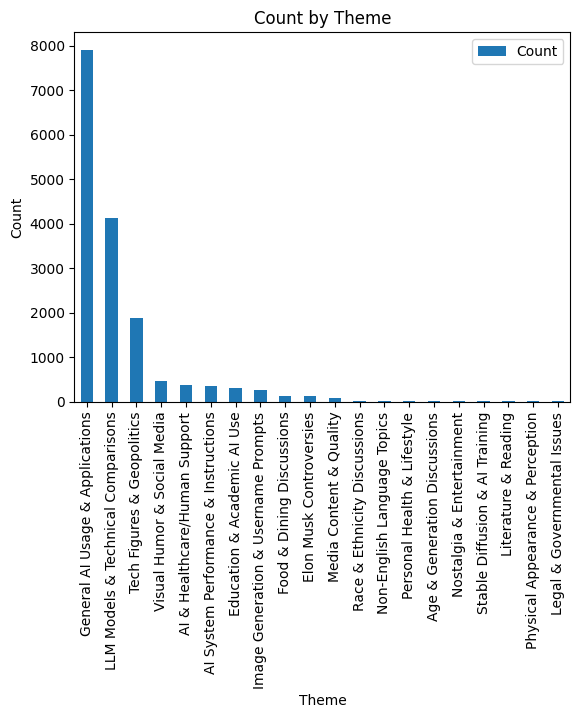

In [ ]:
chatgpt_topic_info.plot(x='Theme', y='Count', kind='bar')
plt.xlabel('Theme')
plt.ylabel('Count')
plt.title('Count by Theme')
plt.show()

In [ ]:
def log_scale_bar_chart(topic_df, theme_col='Theme', count_col='Count',
                        figsize=(12, 8), color='steelblue'):
    """
    Create a bar chart with log scale to better show distribution with large disparities.
    """
    # Sort by count
    df_sorted = topic_df.sort_values(by=count_col, ascending=False).reset_index(drop=True)

    # Create the plot
    plt.figure(figsize=figsize)
    bars = plt.bar(df_sorted[theme_col], df_sorted[count_col], color=color)

    # Use log scale for y-axis
    plt.yscale('log')

    # Add count labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + (height * 0.05),
                f'{int(height):,}', ha='center', va='bottom', rotation=0, fontsize=9)

    # Formatting
    plt.title('Count by Theme (Log Scale)', fontsize=16)
    plt.xlabel('Theme', fontsize=12)
    plt.ylabel('Count (Log Scale)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    return plt.gcf()

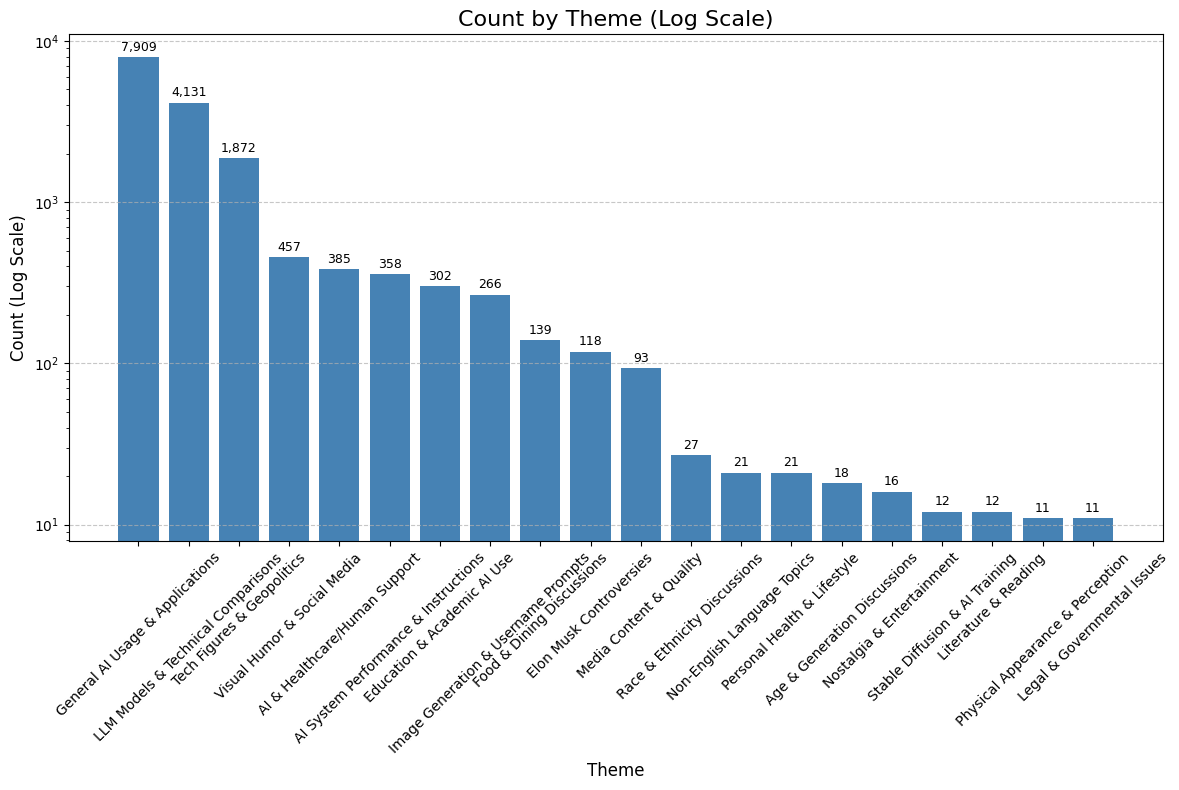

In [ ]:
viz = log_scale_bar_chart(chatgpt_topic_info)

##### DeepSeek

In [ ]:
deepseek_themes = [
    'General Deepseek Usage & Comparison',     # Topic -1
    'Deepseek Technical Discussion',           # Topic 0
    'Content Moderation & Censorship',         # Topic 1
    'AI Philosophy & Usage',                   # Topic 2
    'Reminder System',                         # Topic 3
    'Claude Model Comparisons',                # Topic 4
    'AI in Mental Health',                     # Topic 5
    'Question-Answering Capabilities',         # Topic 6
    'Non-English Language Support',            # Topic 7
    'Model Distillation',                      # Topic 8
    'Document Processing',                     # Topic 9
    'Healthcare & Life Topics',                # Topic 10
    'UI/UX Design',                            # Topic 11
    'Financial Examples & Problems',           # Topic 12
    'Email & Communication',                   # Topic 13
    'Physical Reasoning Problems',             # Topic 14
    'Legislative Discussions',                 # Topic 15
    'Music & Media',                           # Topic 16
    'Context Window Capabilities',             # Topic 17
    'Deepseek 671B Model',                     # Topic 18
]

deepseek_topic_info['Theme'] = deepseek_themes

In [ ]:
theme_dict = {i-1: theme for i, theme in enumerate(deepseek_themes)}

In [ ]:
deepseek_df['theme'] = deepseek_df['topics'].map(theme_dict).fillna("None")

In [ ]:
deepseek_df.to_csv("/content/drive/MyDrive/deepseek_w_topic.csv", index=False)

In [ ]:
total_posts = sum(deepseek_topic_info['Count'])
percentages = [count/total_posts * 100 for count in deepseek_topic_info['Count']]

In [ ]:
deepseek_topic_info['Frequency'] = percentages

In [ ]:
deepseek_topic_info

Topic  Count                                          Name  \
0      -1   6354                   -1_deepseek_like_use_people   
1       0   5357                  0_deepseek_chatgpt_use_model   
2       1   2495               1_censorship_china_removed_post   
3       2    933                        2_ai_like_think_prompt   
4       3    114                     3_gemini_link_date_reduce   
5       4     94                   4_claude_sonnet_coding_code   
6       5     77                    5_therapy_llm_might_mental   
7       6     41                          6_word_ten_many_cook   
8       7     39                                 7_se_ia_eu_en   
9       8     38  8_distilled_distilled version_model_versions   
10      9     35                    9_pdf_documents_files_text   
11     10     27                     10_sell_life_medical_want   
12     11     24                       11_looks_cute_like_nice   
13     12     22                         12_100_given_20_worth   
14     13     22                          13_com_live_look_use   
15     14     21                     14_table_car_water_inside   
16     15     20                        15_bill_bills_pass_law   
17     16     13                      16_jump_mix_heard_sounds   
18     17     11      17_context_context window_window_windows   
19     18     11                     18_671b_try_based_support   

                                       Representation  \
0   ['deepseek', 'like', 'use', 'people', 'model',...   
1   ['deepseek', 'chatgpt', 'use', 'model', 'r1', ...   
2   ['censorship', 'china', 'removed', 'post', 'ch...   
3   ['ai', 'like', 'think', 'prompt', 'use', 'woul...   
4   ['gemini', 'link', 'date', 'reduce', '2025', '...   
5   ['claude', 'sonnet', 'coding', 'code', 'vs', '...   
6   ['therapy', 'llm', 'might', 'mental', 'help', ...   
7   ['word', 'ten', 'many', 'cook', 'answer', 'cou...   
8   ['se', 'ia', 'eu', 'en', 'com', 'ya', 'con', '...   
9   ['distilled', 'distilled version', 'model', 'v...   
10  ['pdf', 'documents', 'files', 'text', 'use', '...   
11  ['sell', 'life', 'medical', 'want', 'humans', ...   
12  ['looks', 'cute', 'like', 'nice', 'chose', 'bo...   
13  ['100', 'given', '20', 'worth', 'bill', 'bucks...   
14  ['com', 'live', 'look', 'use', 'like', 'box', ...   
15  ['table', 'car', 'water', 'inside', 'put', 'st...   
16  ['bill', 'bills', 'pass', 'law', 'acceptable',...   
17  ['jump', 'mix', 'heard', 'sounds', 'never hear...   
18  ['context', 'context window', 'window', 'windo...   
19  ['671b', 'try', 'based', 'support', 'feel free...   

                                  Representative_Docs  \
0   ['You could go for perplexity since it has Dee...   
1   ['Understood your point but 1 DeepSeek R1 is o...   
2   ['Your post has been removed for violating Rul...   
3   ['Na coming from AI engineers in China But you...   
4   ['I will be messaging you in 7 days on 2025 03...   
5   ['At least Claude is doing just fine so far So...   
6   ['Just an FYI BetterHelp sells your data to 3r...   
7   ['Monke find tree with ten banana He tell all ...   
8   ['Só não sei se eles tiraram a função ou se é ...   
9   ['Are using the full model or a distilled vers...   
10  ['Adobe Acrobat pro has a generative AI addon ...   
11  ['No not every job gives you medical aid Not e...   
12  ['Deep seek kinda meshes well with da Whale At...   
13  ['Gemini Here s how to break down John s losse...   
14  ['use any live mail like OUTLOOK COM or HOTMAI...   
15  ['Prompt What happens if 1 you put a marble ba...   
16  ['Bills aren t laws bills aren t laws bills ar...   
17  ['You must never have heard of AC DC Madonna o...   
18  ['Thanks you Happy to hear you liked it Regard...   
19  ['Try with PingAI which is built based on Deep...   

                                  Theme  Frequency  
0   General Deepseek Usage & Comparison  40.347981  
1         Deepseek Technical Discussion  34.017018  
2       Content Moderation & Censorship  15.843282  
3        

In [ ]:
deepseek_topic_info.to_csv('/content/drive/My Drive/deepseek_topic_info.csv')

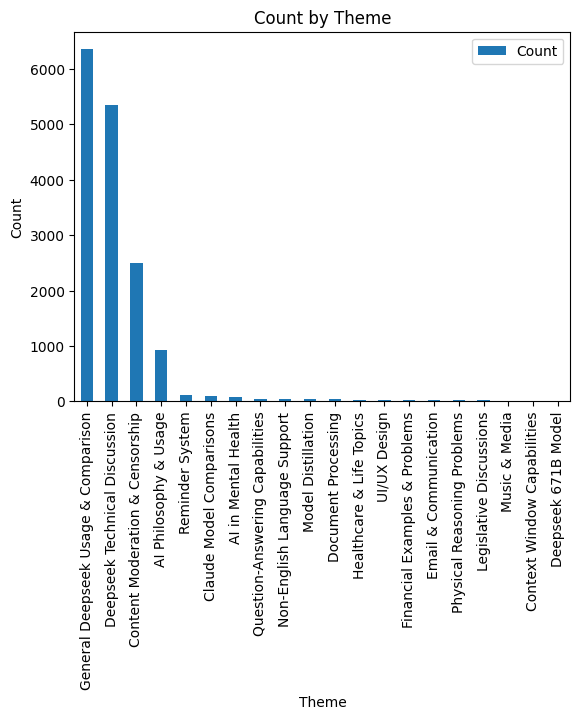

In [ ]:
deepseek_topic_info.plot(x='Theme', y='Count', kind='bar')
plt.xlabel('Theme')
plt.ylabel('Count')
plt.title('Count by Theme')
plt.show()

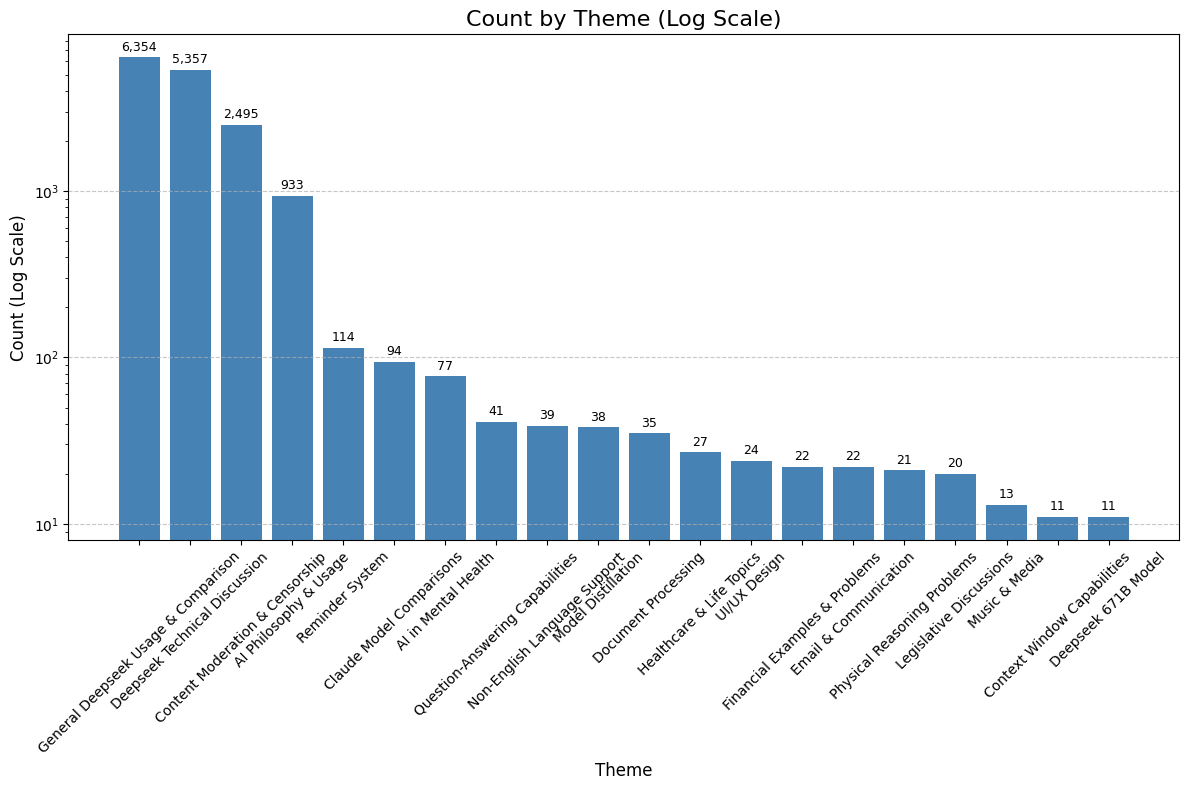

In [ ]:
viz = log_scale_bar_chart(deepseek_topic_info)

##### **Model Evalutaion**

###### Coherence Analysis

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from collections import Counter
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora
from bertopic import BERTopic
import re
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [27]:
def calculate_topic_coherence_simple(model, df, model_name):
    """Calculate coherence metrics for topics using a simplified approach"""
    print(f"Evaluating {model_name} topic model coherence...")

    # 1. Extract topics and their top words
    try:
        # Get topics from the model
        topics = model.get_topics()

        # Print basic topic stats
        num_topics = len([t for t in topics.keys() if t != -1])
        print(f"Number of topics (excluding outliers): {num_topics}")

        # Extract top words for each topic
        topic_words = {}
        for topic_id, topic in topics.items():
            if topic_id != -1:  # Skip outlier topic
                words = [word for word, _ in topic[:10]]
                topic_words[topic_id] = words
                print(f"Topic {topic_id}: {', '.join(words)}")

        # 2. Calculate basic diversity metrics
        all_words = [word for words in topic_words.values() for word in words]
        unique_words = set(all_words)
        diversity = len(unique_words) / len(all_words)
        print(f"Topic diversity: {diversity:.4f} (higher is better)")

        # 3. Calculate average word probability by topic
        avg_probs = {}
        for topic_id, topic in topics.items():
            if topic_id != -1:
                avg_prob = sum([prob for _, prob in topic[:10]]) / 10
                avg_probs[topic_id] = avg_prob

        # Sort topics by average probability
        sorted_topics = sorted(avg_probs.items(), key=lambda x: x[1], reverse=True)
        print("\nTopics sorted by average word probability (higher means more coherent):")
        for topic_id, avg_prob in sorted_topics[:5]:
            print(f"Topic {topic_id}: {avg_prob:.4f} - {', '.join(topic_words[topic_id])}")

        # 4. Calculate document distribution
        if 'topics' in df.columns:
            topic_counts = df['topics'].value_counts()
            print("\nDocument distribution across topics:")
            for topic_id, count in topic_counts.items():
                try:
                    topic_id = int(topic_id)
                    if topic_id in topic_words:
                        print(f"Topic {topic_id} ({count} docs): {', '.join(topic_words[topic_id][:5])}")
                except:
                    # Handle non-integer topic IDs if any
                    pass

        # 5. Calculate word overlap between topics
        topic_ids = list(topic_words.keys())
        overlaps = []

        for i, tid1 in enumerate(topic_ids):
            words1 = set(topic_words[tid1])
            for tid2 in topic_ids[i+1:]:
                words2 = set(topic_words[tid2])
                # Jaccard similarity: intersection / union
                if words1 and words2:  # Avoid division by zero
                    overlap = len(words1.intersection(words2)) / len(words1.union(words2))
                    overlaps.append(overlap)

        avg_overlap = sum(overlaps) / len(overlaps) if overlaps else 0
        print(f"\nAverage topic overlap: {avg_overlap:.4f} (lower is better)")

        # Return evaluation metrics
        return {
            'num_topics': num_topics,
            'diversity': diversity,
            'avg_overlap': avg_overlap,
            'top_topics': sorted_topics[:5],
            'topic_words': topic_words
        }

    except Exception as e:
        print(f"Error evaluating topic model: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

In [29]:
calculate_topic_coherence_simple(chatgpt_topic, chatgpt_df, "ChatGPT")

Evaluating ChatGPT topic model coherence...
Number of topics (excluding outliers): 19
Topic 0: ai, chatgpt, deepseek, use, gpt, model, would, know, one, using
Topic 1: china, trump, elon, musk, us, would, get, going, one, things
Topic 2: look, cat, looks, delete, one, right, funny, face, weird, look like
Topic 3: ai, chatgpt, human, need, feel, things, medical, doctor, good, help
Topic 4: memory, app, remember, instructions, working, error, try, custom, edit, custom instructions
Topic 5: homework, math, school, 11, parents, kids, calculator, education, get, time
Topic 6: image, username, name, generate, link, mine, images, chatgpt, curious, named
Topic 7: glass, chicken, eat, made, day, food, egg, cook, one, good
Topic 8: heart, video, elon, context, crowd, arm, roman, goes, twice, hand
Topic 9: video, song, music, youtube, videos, months, better, quality, pretty, seconds
Topic 10: indian, black, individual, black people, white, skin, color, japanese, look, racist
Topic 11: de, se, la,

{'num_topics': 19,
 'diversity': 0.8842105263157894,
 'avg_overlap': 0.008720631989330044,
 'top_topics': [(11, 0.32975316576191693),
  (17, 0.1569868576691168),
  (13, 0.1484469469794464),
  (18, 0.11210137955476777),
  (10, 0.1096630877158469)],
 'topic_words': {0: ['ai',
   'chatgpt',
   'deepseek',
   'use',
   'gpt',
   'model',
   'would',
   'know',
   'one',
   'using'],
  1: ['china',
   'trump',
   'elon',
   'musk',
   'us',
   'would',
   'get',
   'going',
   'one',
   'things'],
  2: ['look',
   'cat',
   'looks',
   'delete',
   'one',
   'right',
   'funny',
   'face',
   'weird',
   'look like'],
  3: ['ai',
   'chatgpt',
   'human',
   'need',
   'feel',
   'things',
   'medical',
   'doctor',
   'good',
   'help'],
  4: ['memory',
   'app',
   'remember',
   'instructions',
   'working',
   'error',
   'try',
   'custom',
   'edit',
   'custom instructions'],
  5: ['homework',
   'math',
   'school',
   '11',
   'parents',
   'kids',
   'calculator',
   'education',


In [30]:
calculate_topic_coherence_simple(deepseek_topic, deepseek_df, "DeepSeek")

Evaluating DeepSeek topic model coherence...
Number of topics (excluding outliers): 19
Topic 0: deepseek, chatgpt, use, model, r1, openai, like, chat, get, server
Topic 1: censorship, china, removed, post, chinese, us, posts, people, allowed, spam
Topic 2: ai, like, think, prompt, use, would, people, answer, really, way
Topic 3: gemini, link, date, reduce, 2025, hide, info, delete, click, thinking
Topic 4: claude, sonnet, coding, code, vs, good, better, using, claude sonnet, r1
Topic 5: therapy, llm, might, mental, help, ai, really, go, like, models
Topic 6: word, ten, many, cook, answer, could, total, standard, third, question
Topic 7: se, ia, eu, en, com, ya, con, email, google, al
Topic 8: distilled, distilled version, model, versions, version, distilled models, r1, llama, models, cot
Topic 9: pdf, documents, files, text, use, word, papers, data, python, need
Topic 10: sell, life, medical, want, humans, america, old, would, people, rest
Topic 11: looks, cute, like, nice, chose, bori

{'num_topics': 19,
 'diversity': 0.8526315789473684,
 'avg_overlap': 0.0144720245746806,
 'top_topics': [(13, 0.28364879936015586),
  (7, 0.2572232335513681),
  (18, 0.144193402584268),
  (14, 0.13431132558204723),
  (12, 0.12452802216856307)],
 'topic_words': {0: ['deepseek',
   'chatgpt',
   'use',
   'model',
   'r1',
   'openai',
   'like',
   'chat',
   'get',
   'server'],
  1: ['censorship',
   'china',
   'removed',
   'post',
   'chinese',
   'us',
   'posts',
   'people',
   'allowed',
   'spam'],
  2: ['ai',
   'like',
   'think',
   'prompt',
   'use',
   'would',
   'people',
   'answer',
   'really',
   'way'],
  3: ['gemini',
   'link',
   'date',
   'reduce',
   '2025',
   'hide',
   'info',
   'delete',
   'click',
   'thinking'],
  4: ['claude',
   'sonnet',
   'coding',
   'code',
   'vs',
   'good',
   'better',
   'using',
   'claude sonnet',
   'r1'],
  5: ['therapy',
   'llm',
   'might',
   'mental',
   'help',
   'ai',
   'really',
   'go',
   'like',
   'model

###### Topic Diversity

In [32]:
def calculate_topic_diversity(model, model_name):
    """Calculate how diverse the topics are from each other"""
    topics = model.get_topics()

    # Calculate word overlap between topics
    all_words = []
    for topic_id, topic in topics.items():
        if topic_id != -1:  # Skip outlier topic
            words = [word for word, _ in topic[:10]]  # Get top 10 words
            all_words.extend(words)

    # Count unique words
    unique_words = set(all_words)

    # Diversity score = unique words / total words
    diversity = len(unique_words) / len(all_words)
    print(f"{model_name} - Topic diversity: {diversity:.4f}")

    # Calculate pairwise word overlap
    topic_ids = [tid for tid in topics.keys() if tid != -1]
    topic_words = {tid: [word for word, _ in topics[tid][:10]] for tid in topic_ids}

    overlap_matrix = np.zeros((len(topic_ids), len(topic_ids)))

    for i, tid1 in enumerate(topic_ids):
        words1 = set(topic_words[tid1])
        for j, tid2 in enumerate(topic_ids):
            words2 = set(topic_words[tid2])
            if i == j:
                overlap_matrix[i, j] = 1.0
            else:
                # Jaccard similarity: intersection / union
                overlap_matrix[i, j] = len(words1.intersection(words2)) / len(words1.union(words2))

    # Plot word overlap heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(overlap_matrix,
                xticklabels=[str(tid) for tid in topic_ids],
                yticklabels=[str(tid) for tid in topic_ids],
                cmap="YlGnBu", annot=False)
    plt.title(f'Topic Word Overlap in {model_name}')
    plt.tight_layout()
    plt.savefig(f'{model_name}_topic_overlap.png')
    plt.show()

    # Calculate average overlap
    avg_overlap = (np.sum(overlap_matrix) - len(topic_ids)) / (len(topic_ids) * (len(topic_ids) - 1))
    print(f"{model_name} - Average topic overlap: {avg_overlap:.4f}")

    return {
        'diversity': diversity,
        'avg_overlap': avg_overlap,
        'overlap_matrix': overlap_matrix
    }


ChatGPT - Topic diversity: 0.8842


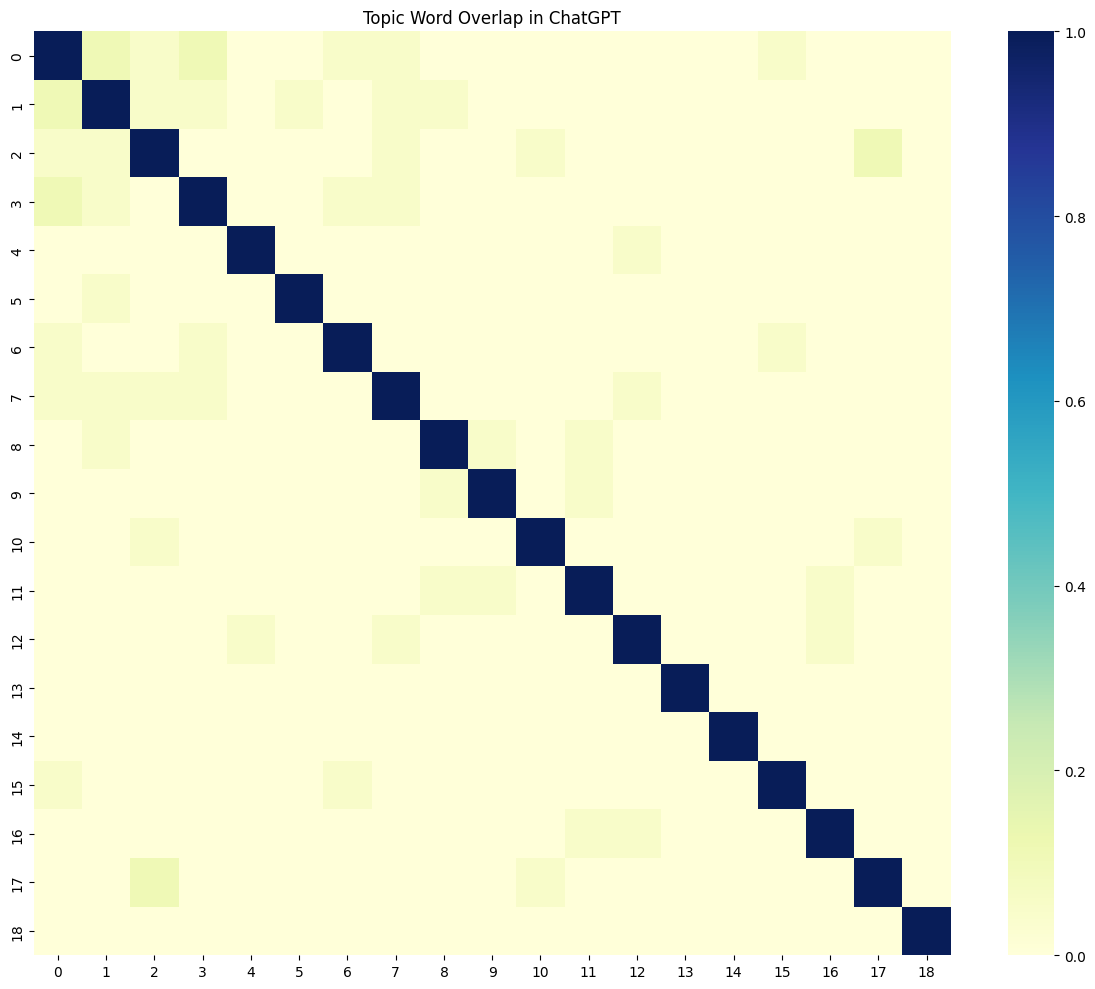

ChatGPT - Average topic overlap: 0.0087


{'diversity': 0.8842105263157894,
 'avg_overlap': 0.008720631989330048,
 'overlap_matrix': array([[1.        , 0.11111111, 0.05263158, 0.11111111, 0.        ,
         0.        , 0.05263158, 0.05263158, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.05263158, 0.        , 0.        , 0.        ],
        [0.11111111, 1.        , 0.05263158, 0.05263158, 0.        ,
         0.05263158, 0.        , 0.05263158, 0.05263158, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        ],
        [0.05263158, 0.05263158, 1.        , 0.        , 0.        ,
         0.        , 0.        , 0.05263158, 0.        , 0.        ,
         0.05263158, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.11111111, 0.        ],
        [0.11111111, 0.05263158, 0.        , 1.        , 0.        ,
         0.        , 0.05263158, 0.05263158, 0

In [33]:
calculate_topic_diversity(chatgpt_topic, "ChatGPT")

DeepSeek - Topic diversity: 0.8526


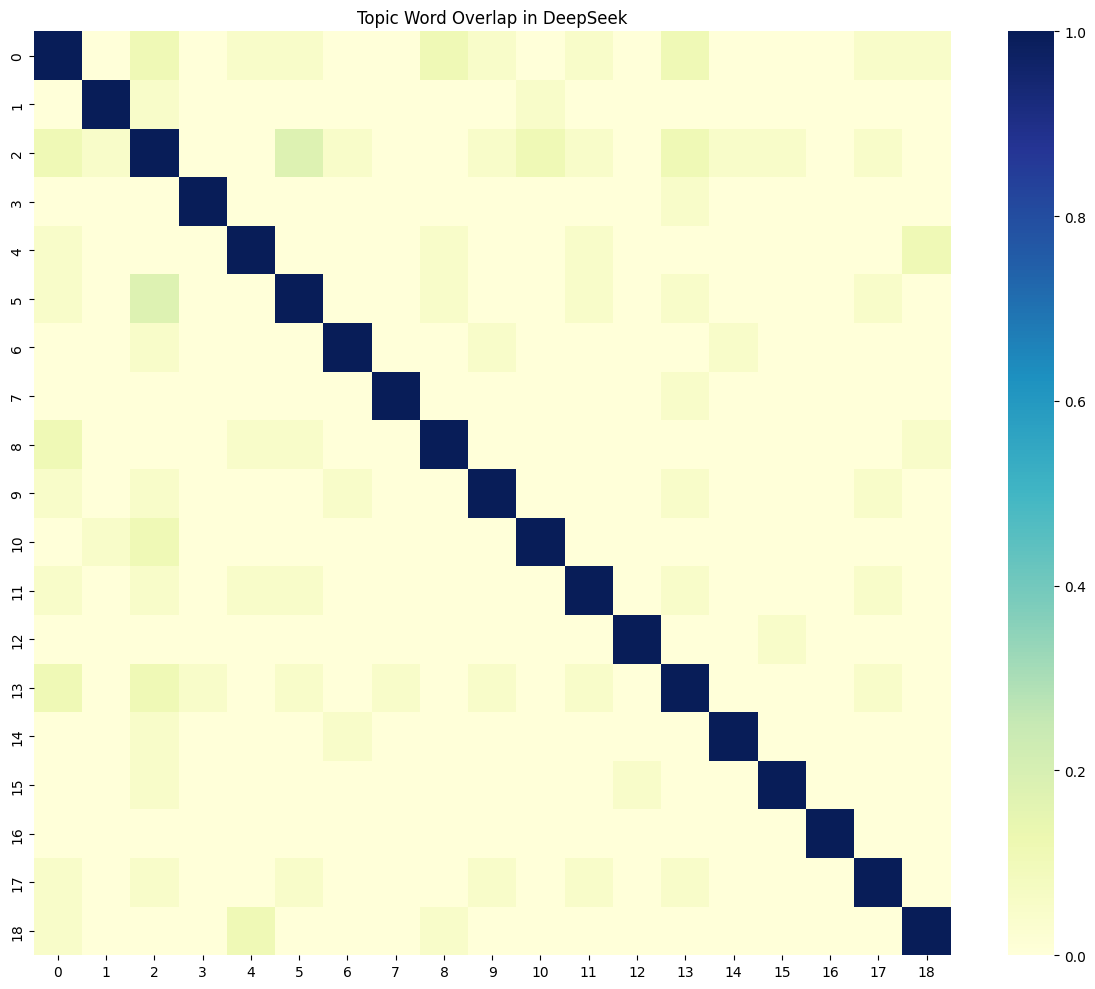

DeepSeek - Average topic overlap: 0.0145


{'diversity': 0.8526315789473684,
 'avg_overlap': 0.0144720245746806,
 'overlap_matrix': array([[1.        , 0.        , 0.11111111, 0.        , 0.05263158,
         0.05263158, 0.        , 0.        , 0.11111111, 0.05263158,
         0.        , 0.05263158, 0.        , 0.11111111, 0.        ,
         0.        , 0.        , 0.05263158, 0.05263158],
        [0.        , 1.        , 0.05263158, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.05263158, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        ],
        [0.11111111, 0.05263158, 1.        , 0.        , 0.        ,
         0.17647059, 0.05263158, 0.        , 0.        , 0.05263158,
         0.11111111, 0.05263158, 0.        , 0.11111111, 0.05263158,
         0.05263158, 0.        , 0.05263158, 0.        ],
        [0.        , 0.        , 0.        , 1.        , 0.        ,
         0.        , 0.        , 0.        , 0. 

In [34]:
calculate_topic_diversity(deepseek_topic, "DeepSeek")

##### **Temporal Analysis**

- Track how topics grow/decline over time
- Identify emerging vs. fading topics
- Detect topic spikes related to events (product releases, controversies)

**Purpose**: Track how narratives change over time.

**Value**: Shows which topics are emerging vs. fading, and how external events influence perception.

**Goal**: Helps recommend timely content that aligns with current discourse trends.


In [ ]:
chatgpt_df = pd.read_csv("/content/drive/MyDrive/sampled_chatgpt_w_topic.csv")

In [ ]:
deepseek_df = pd.read_csv("/content/drive/MyDrive/deepseek_w_topic.csv")

In [ ]:
def plot_temporal_trends_with_themes(document_df, themes, timestamp_col="date", topic_col="topics",
                                   top_n=5, rolling_window=None, use_frequency=False,
                                   time_period='W'):
    """
    Plots the temporal trends of the top N themes in the dataset.
    Automatically adds theme names if only topic numbers are provided.

    Parameters:
    -----------
    document_df : pandas.DataFrame
        DataFrame containing documents with timestamps and topic assignments
    timestamp_col : str, default="date"
        Column name for timestamps
    topic_col : str, default="topics"
        Column name for topic IDs
    top_n : int, default=5
        Number of top themes to visualize
    rolling_window : int or None, default=None
        If provided, applies a rolling mean for smoothing (e.g., 3 for 3-month average)
    use_frequency : bool, default=False
        If True, shows percentages instead of counts
    time_period : str, default='W'
        Time period for grouping: 'M' for month, 'W' for week, 'D' for day, etc.

    Returns:
    --------
    matplotlib.figure.Figure
        The generated plot
    """
    import matplotlib.pyplot as plt
    import pandas as pd

    # Make a copy to avoid modifying original
    df = document_df.copy()

    # Create a dictionary mapping from topic numbers to theme names
    # Topic -1 maps to index 0, Topic 0 maps to index 1, etc.
    theme_dict = {i-1: theme for i, theme in enumerate(themes)}

    # Add theme names based on topic IDs - this is the critical step!
    df['Theme'] = df[topic_col].map(theme_dict).fillna("Unknown Theme")

    # Ensure timestamp column is in datetime format
    df[timestamp_col] = pd.to_datetime(df[timestamp_col])

    # Create a time period column for grouping
    period_name = 'TimePeriod'
    df[period_name] = df[timestamp_col].dt.to_period(time_period)

    # Count documents (each row is one document)
    # Each document counts as 1
    period_counts = df.groupby([period_name, 'Theme']).size().unstack(fill_value=0)

    # Convert to frequencies if requested
    if use_frequency:
        # Get periodic totals
        period_totals = period_counts.sum(axis=1)
        # Divide each count by the total for that period to get frequencies
        period_freq = period_counts.div(period_totals, axis=0) * 100
        data_to_plot = period_freq
        y_label = 'Frequency (%)'
    else:
        data_to_plot = period_counts
        y_label = 'Document Count'

    # Get the top N themes by total count
    theme_totals = period_counts.sum()
    top_themes = theme_totals.nlargest(top_n).index

    # Apply rolling average if specified
    if rolling_window:
        smoothed_data = data_to_plot.rolling(window=rolling_window, min_periods=1).mean()
    else:
        smoothed_data = data_to_plot

    # Create the plot
    plt.figure(figsize=(14, 8))

    # Plot each top theme
    for theme in top_themes:
        if theme in smoothed_data.columns:
            plt.plot(
                smoothed_data.index.astype(str),
                smoothed_data[theme],
                linewidth=2,
                marker='o',
                markersize=4,
                label=theme
            )

    # Set time period label for x-axis
    time_label = {'M': 'Month', 'W': 'Week', 'D': 'Day', 'Y': 'Year'}.get(time_period, 'Time Period')

    # Add legend and labels
    plt.legend(loc='best', fontsize=10)
    plt.xlabel(time_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.title(f'Temporal Trends of Top {top_n} Themes ({time_label}ly)', fontsize=16)

    # Format x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add data points for context
    if len(smoothed_data) > 20:
        # If we have many time points, reduce the tick frequency
        plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

    # Adjust y-axis limits for frequency plots
    if use_frequency:
        plt.ylim(0, min(100, plt.gca().get_ylim()[1] * 1.1))  # Cap at 100% with some padding

    plt.tight_layout()

    return plt.gcf()

In [ ]:
vis = plot_temporal_trends_with_themes(chatgpt_df, chatgpt_themes)

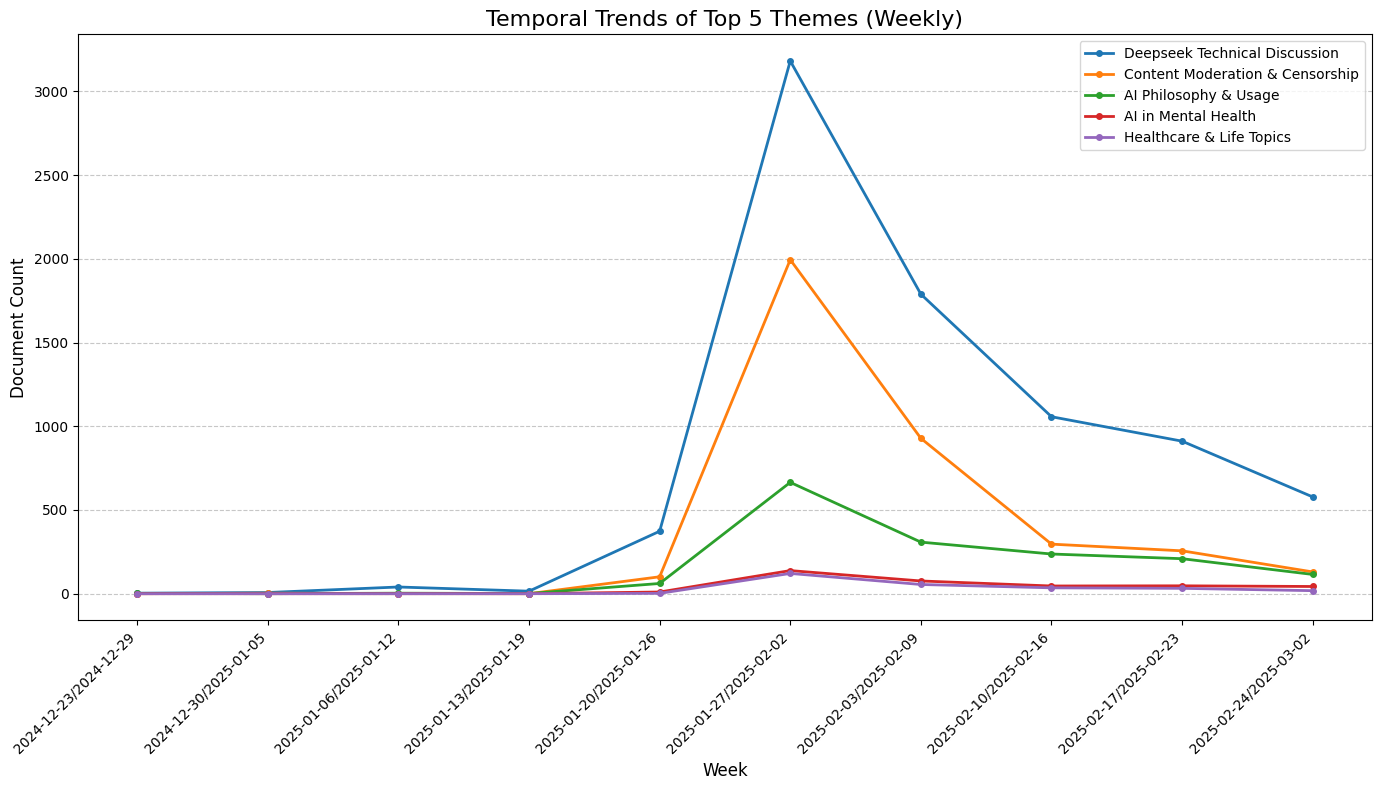

In [ ]:
vis = plot_temporal_trends_with_themes(deepseek_df, deepseek_themes)

ChatGPT


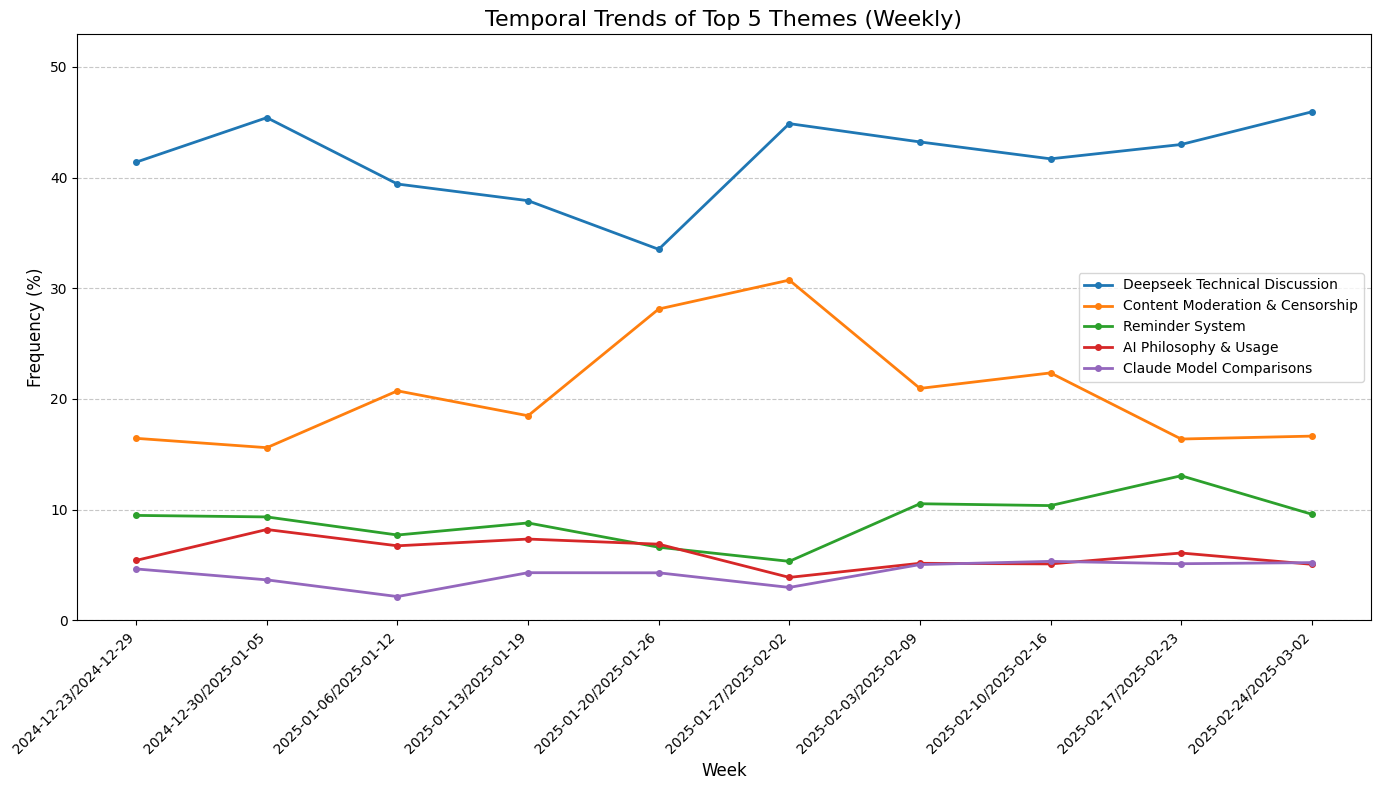

In [ ]:
# Using frequencies (percentages) instead of raw counts
print('ChatGPT')
viz = plot_temporal_trends_with_themes(
    chatgpt_df,
    chatgpt_themes,
    timestamp_col="date",
    topic_col="topics",
    top_n=5,
    use_frequency=True  # This shows percentages instead of counts
)

DeepSeek


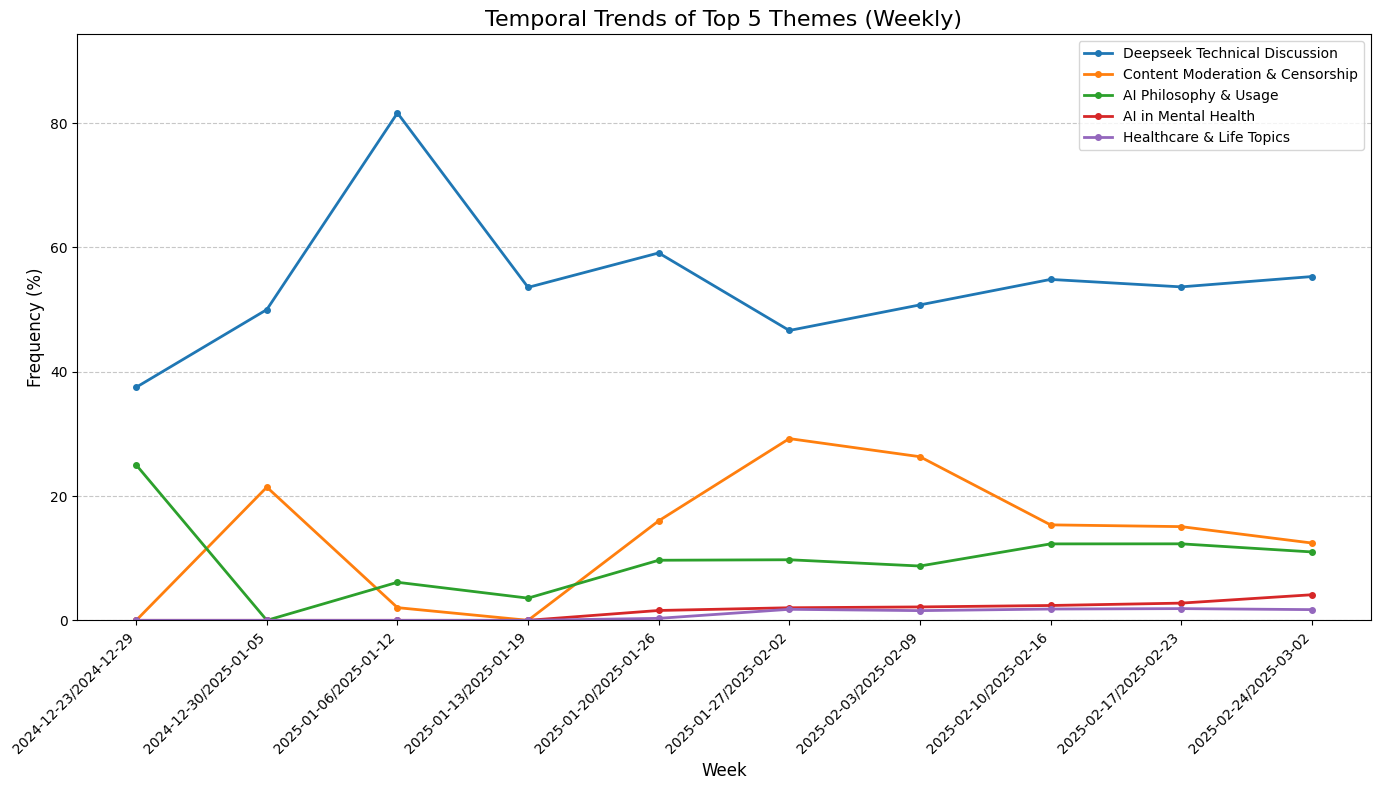

In [ ]:
# Using frequencies (percentages) instead of raw counts
print('DeepSeek')
viz = plot_temporal_trends_with_themes(
    deepseek_df,
    deeepseek_themes,
    timestamp_col="date",
    topic_col="topics",
    top_n=5,
    use_frequency=True  # This shows percentages instead of counts
)

#### **Sentiment Analysis**

**Purpose:** Understand emotional valence in different narratives.

**Value:** Shows where communities differ not just in what they discuss, but how positively/negatively they frame it.

**Goal:** Can tailor recommendations based on sentiment preference (e.g., optimistic vs. critical views).

In [39]:
def analyze_themes(df, model_name):
    """Analyze the distribution and relationships of themes"""
    # Count documents by theme
    theme_counts = df['theme'].value_counts().reset_index()
    theme_counts.columns = ['Theme', 'Count']

    # Plot theme distribution
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Theme', y='Count', data=theme_counts)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Theme Distribution in {model_name}')
    plt.tight_layout()
    plt.savefig(f'{model_name}_theme_distribution.png')
    plt.show()

    # Theme-sentiment relationship
    theme_sentiment = pd.crosstab(df['theme'], df['sentiment_category'], normalize='index')

    plt.figure(figsize=(14, 8))
    sns.heatmap(theme_sentiment, cmap="RdBu_r", annot=True, fmt='.2%')
    plt.title(f'Theme-Sentiment Relationship in {model_name}')
    plt.tight_layout()
    plt.savefig(f'{model_name}_theme_sentiment.png')
    plt.show()

    return {
        'theme_counts': theme_counts,
        'theme_sentiment': theme_sentiment
    }

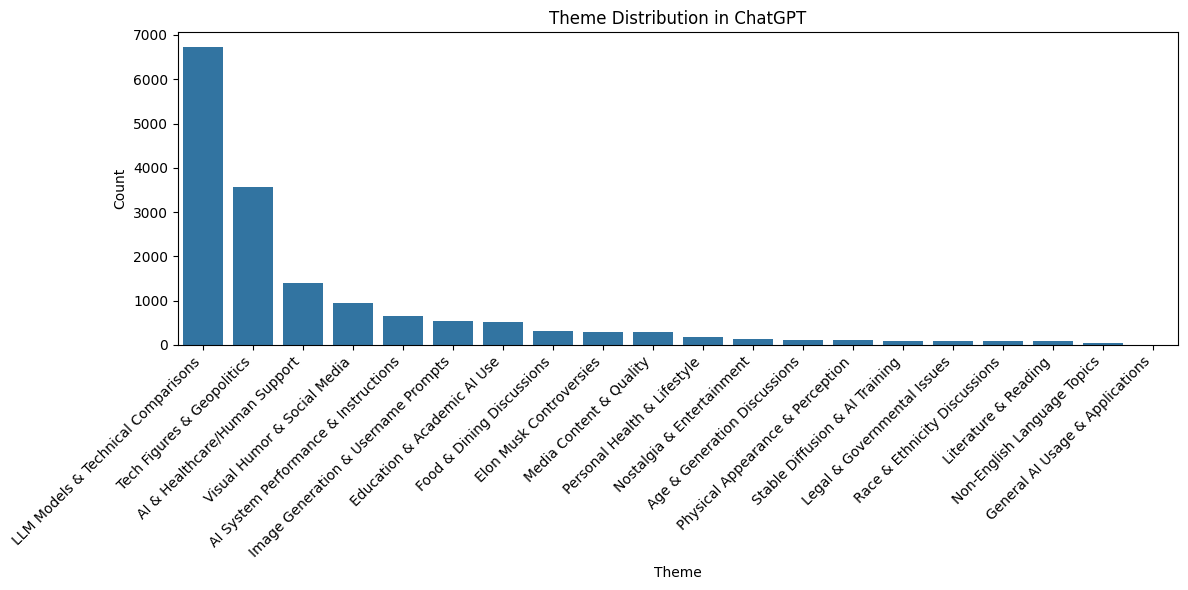

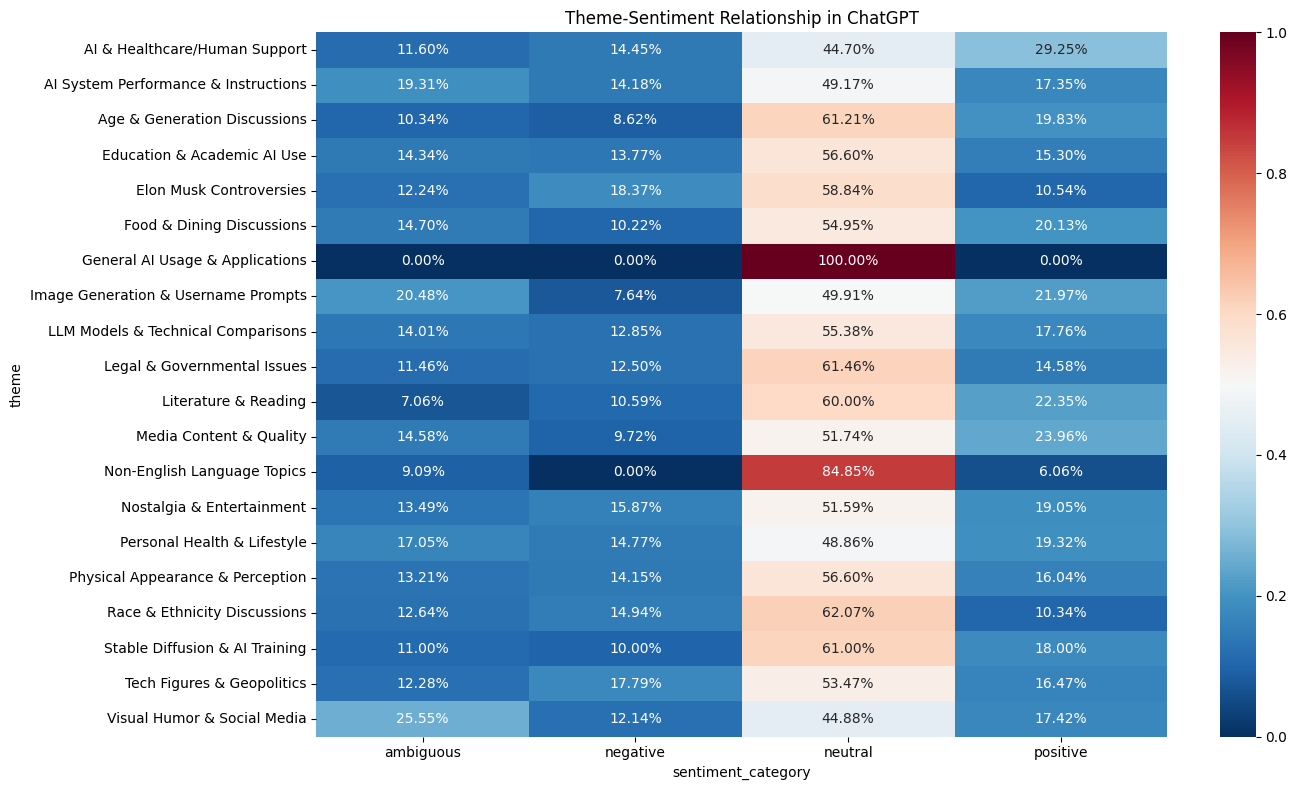

{'theme_counts':                                    Theme  Count
 0     LLM Models & Technical Comparisons   6723
 1             Tech Figures & Geopolitics   3559
 2          AI & Healthcare/Human Support   1405
 3            Visual Humor & Social Media    947
 4   AI System Performance & Instructions    663
 5    Image Generation & Username Prompts    537
 6            Education & Academic AI Use    523
 7              Food & Dining Discussions    313
 8                Elon Musk Controversies    294
 9                Media Content & Quality    288
 10           Personal Health & Lifestyle    176
 11             Nostalgia & Entertainment    126
 12          Age & Generation Discussions    116
 13      Physical Appearance & Perception    106
 14        Stable Diffusion & AI Training    100
 15           Legal & Governmental Issues     96
 16          Race & Ethnicity Discussions     87
 17                  Literature & Reading     85
 18           Non-English Language Topics     33
 19 

In [40]:
analyze_themes(chatgpt_df, "ChatGPT")

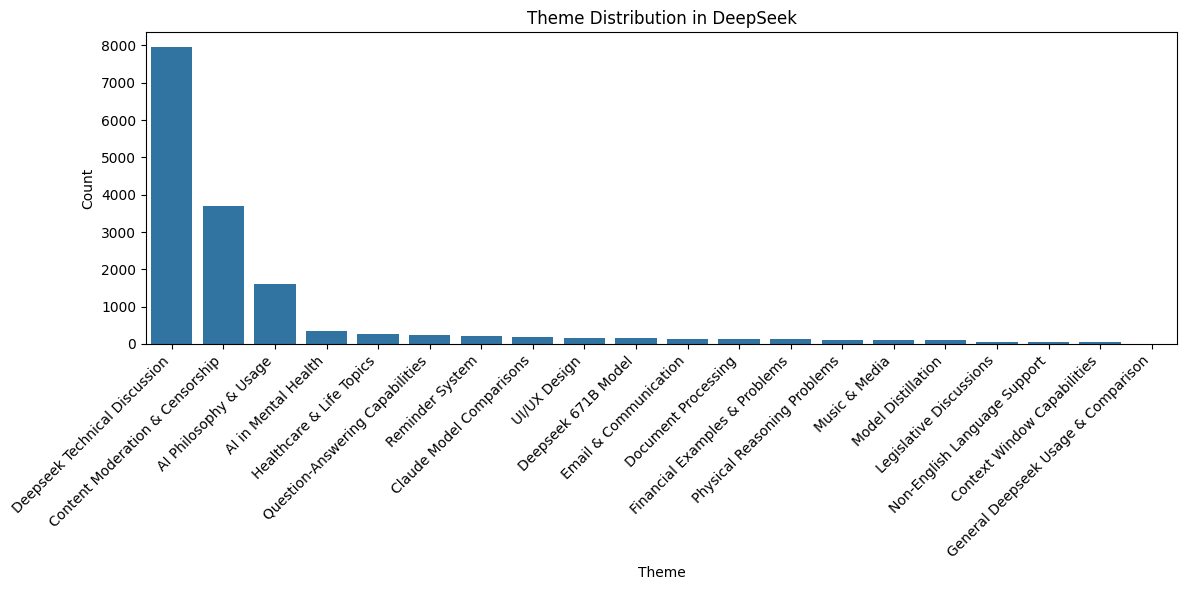

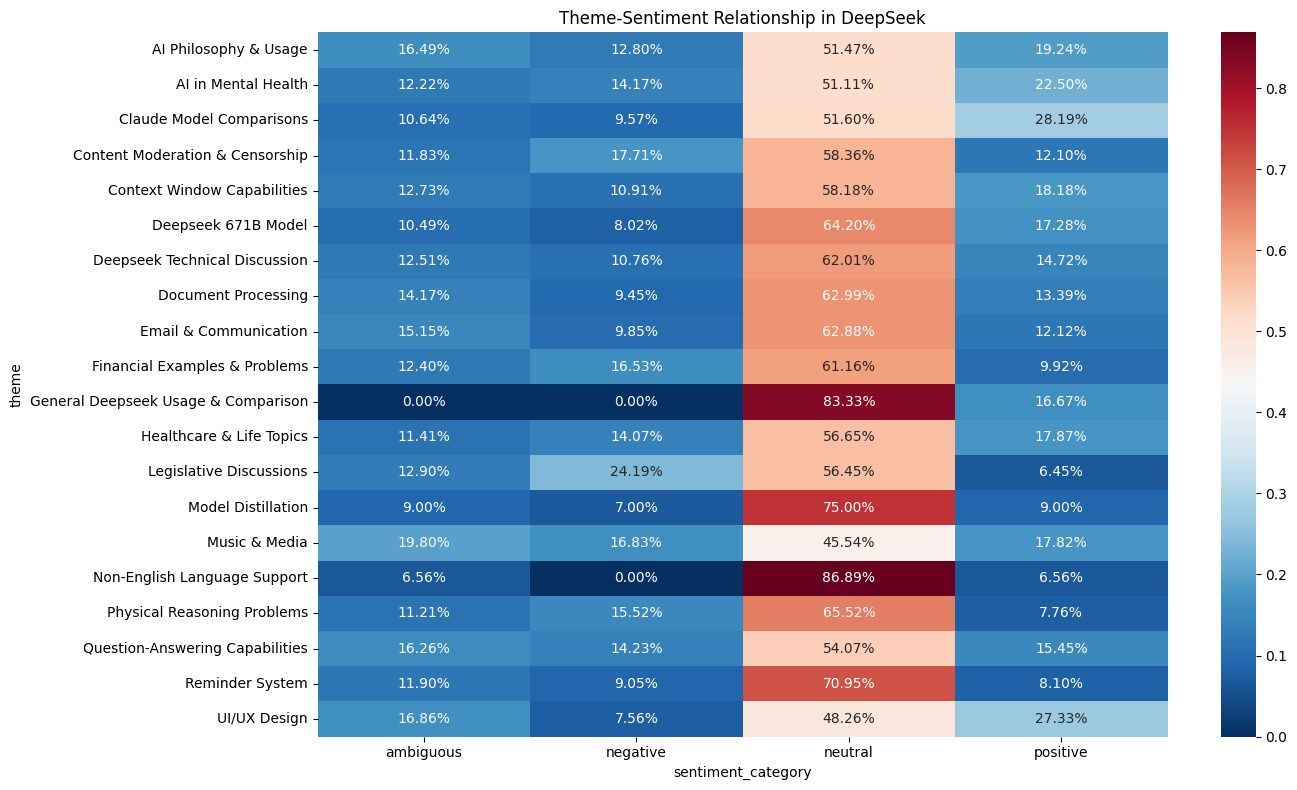

{'theme_counts':                                   Theme  Count
 0         Deepseek Technical Discussion   7955
 1       Content Moderation & Censorship   3710
 2                 AI Philosophy & Usage   1601
 3                   AI in Mental Health    360
 4              Healthcare & Life Topics    263
 5       Question-Answering Capabilities    246
 6                       Reminder System    210
 7              Claude Model Comparisons    188
 8                          UI/UX Design    172
 9                   Deepseek 671B Model    162
 10                Email & Communication    132
 11                  Document Processing    127
 12        Financial Examples & Problems    121
 13          Physical Reasoning Problems    116
 14                        Music & Media    101
 15                   Model Distillation    100
 16              Legislative Discussions     62
 17         Non-English Language Support     61
 18          Context Window Capabilities     55
 19  General Deepseek Us

In [41]:
analyze_themes(deepseek_df, "DeepSeek")


#### **Word Distribution Level (How keywords are shared across topics)**

**Purpose:** Identify key terminology that bridges or separates community narratives.

**Value:** Shows words that have different meanings or importance across communities.

**For recommendation:** Helps identify cross-community content that might bridge different user groups.

##### default chart

In [ ]:
chatgpt_topic.visualize_barchart()

In [ ]:
deepseek_topic.visualize_barchart()

##### granular analysis

Running Term Frequency Analysis...


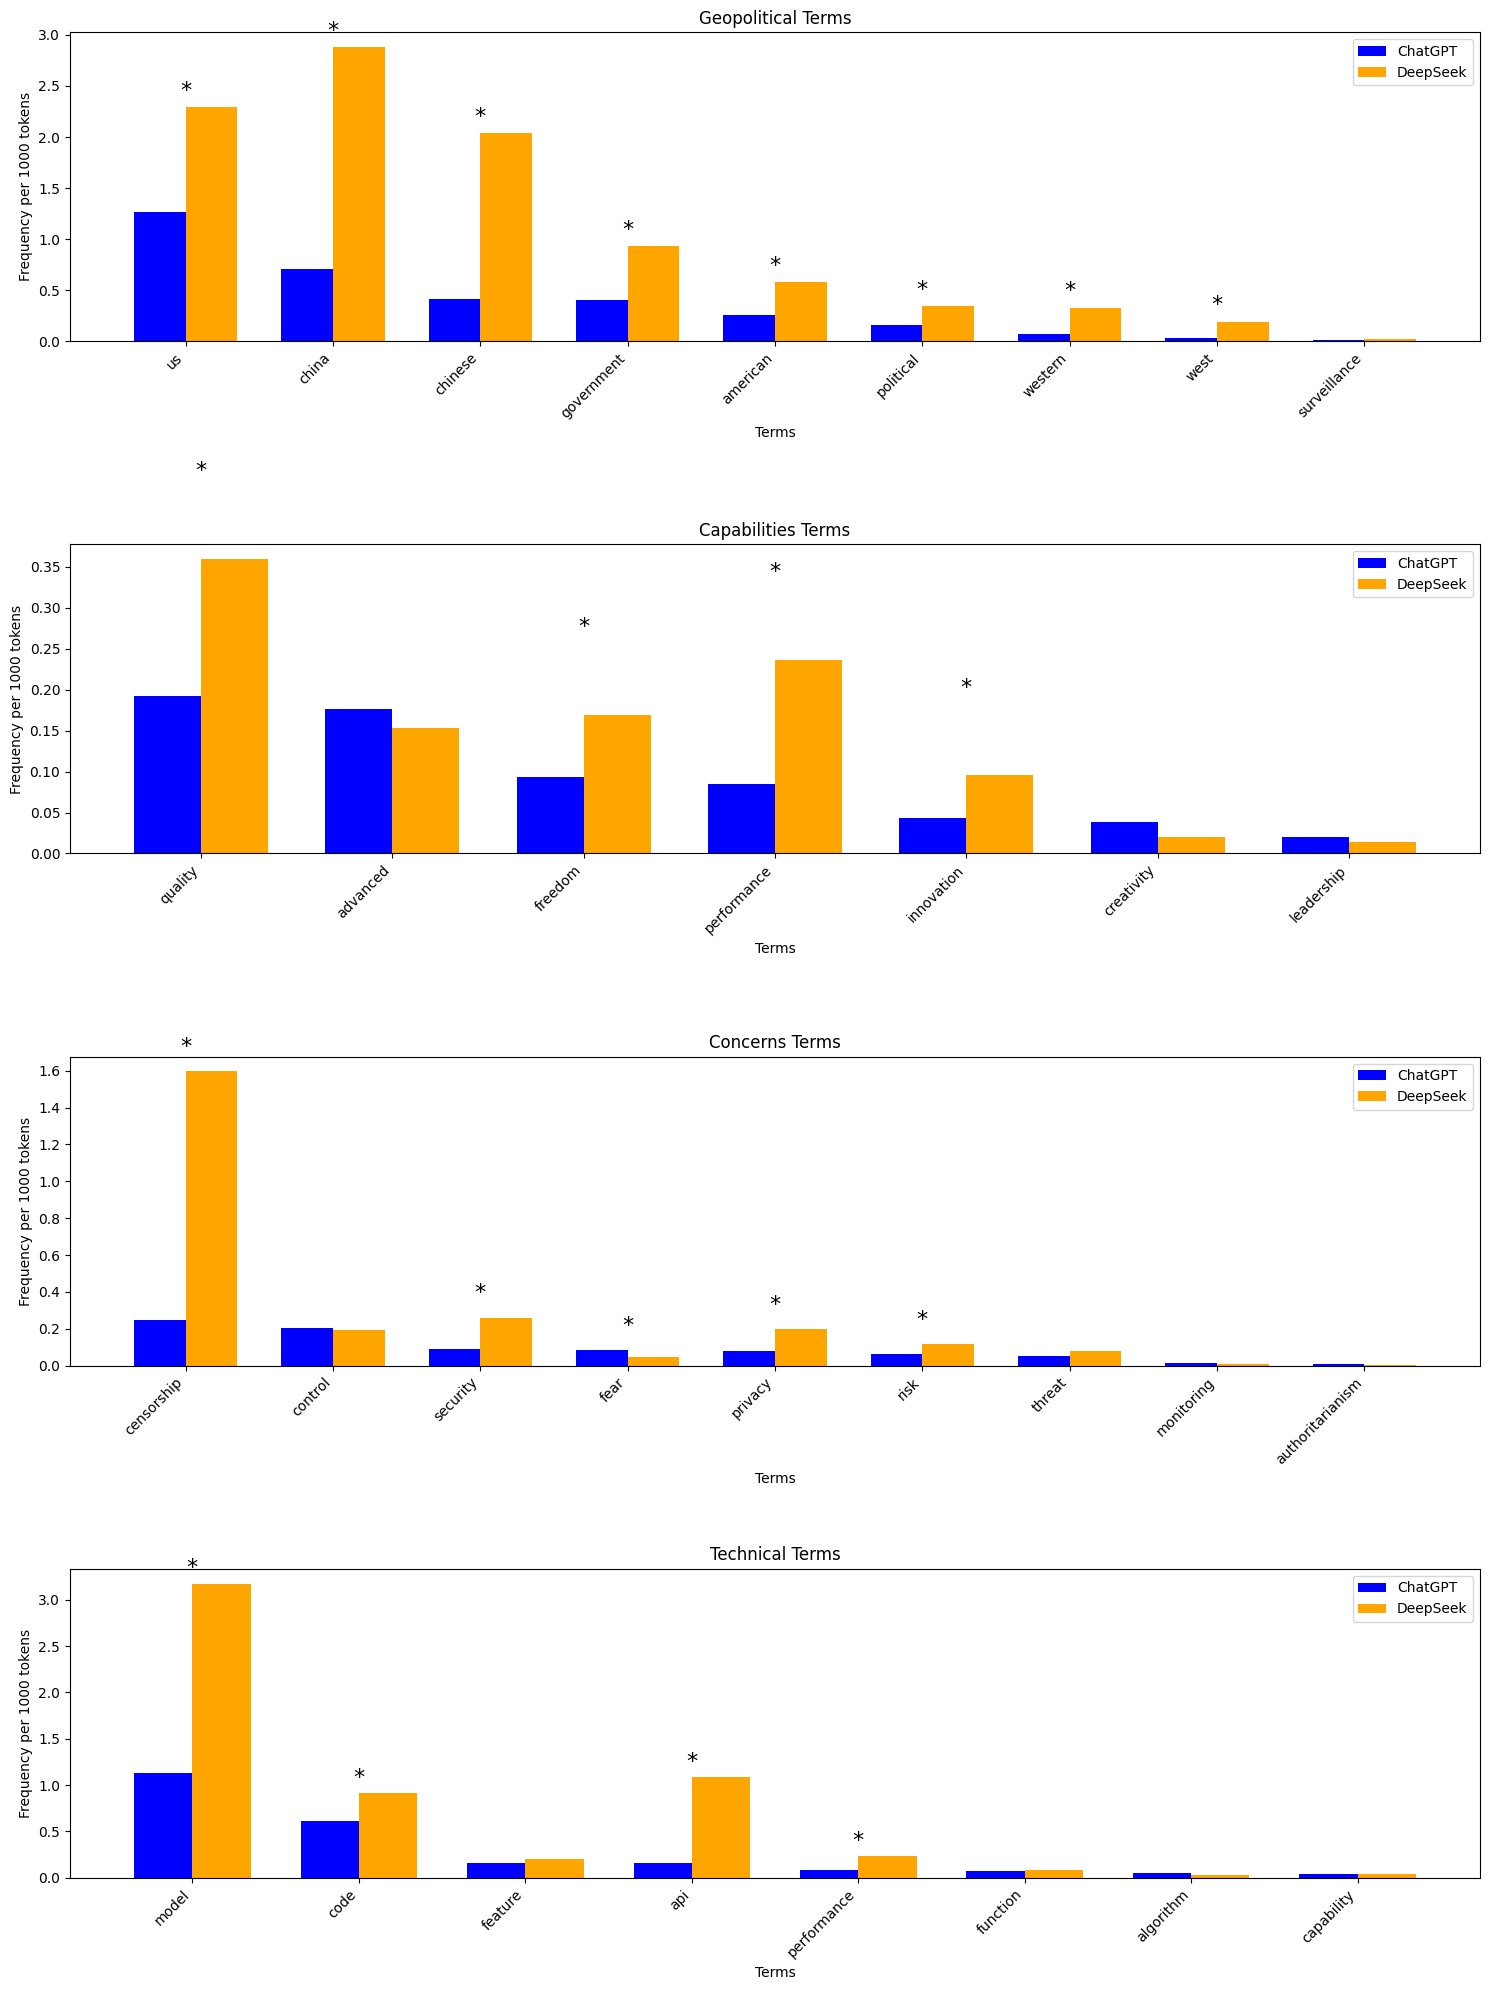

Running Distinctive Words Analysis...
Running simplified distinctive words analysis...
  Counting words in ChatGPT...
  Counting words in DeepSeek...
  Calculating distinctiveness...
  Creating visualization...


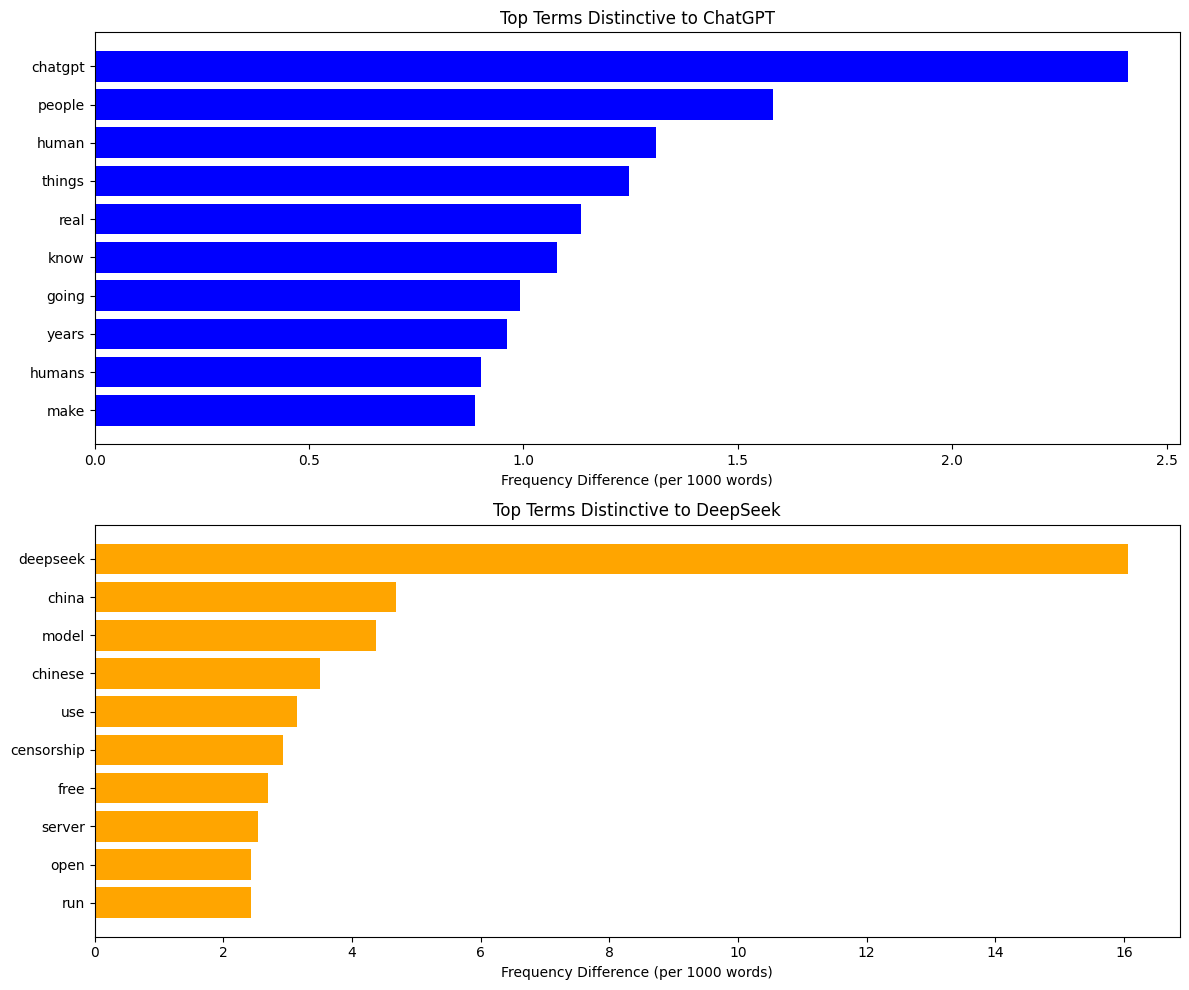

  Analysis complete.
Running Contextual Analysis...


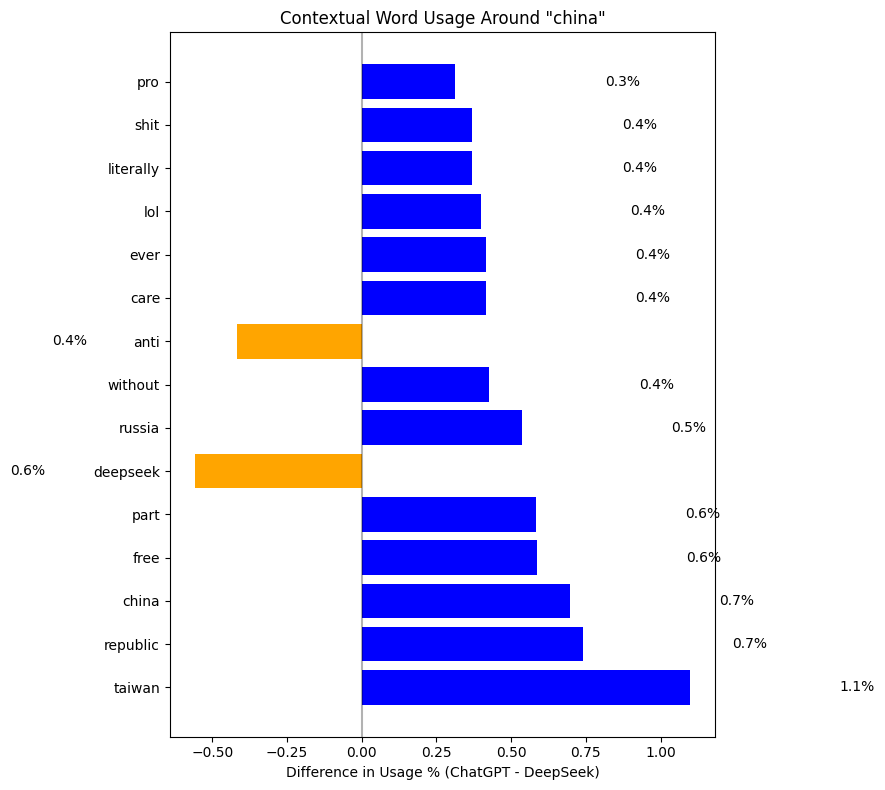

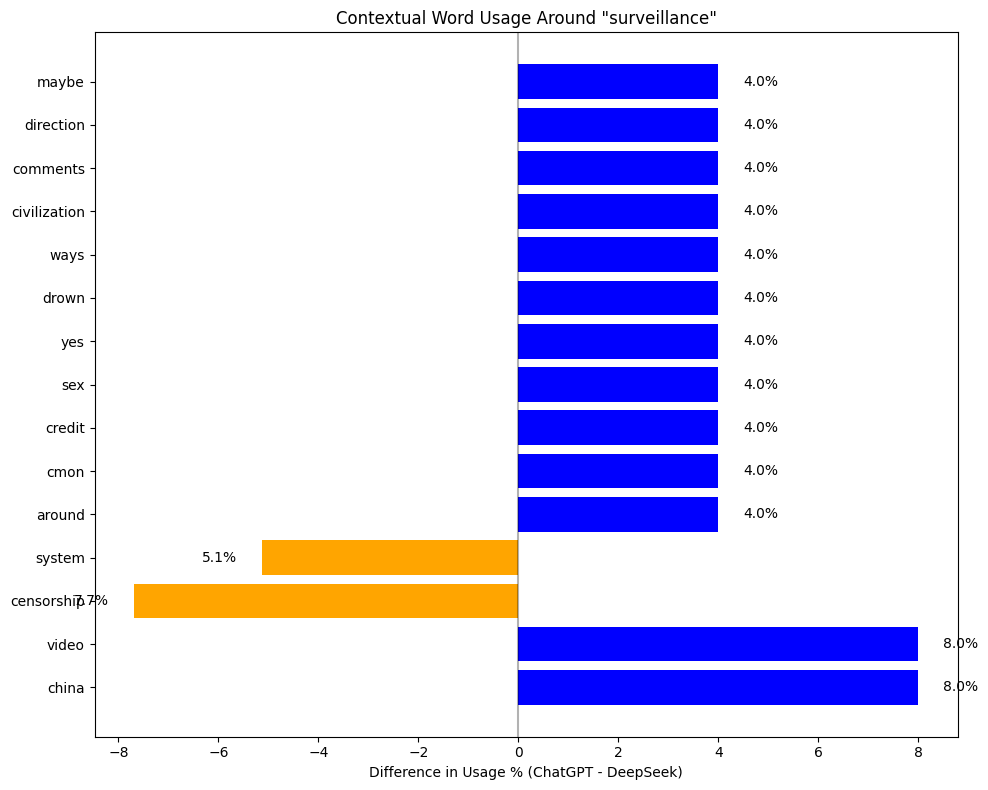

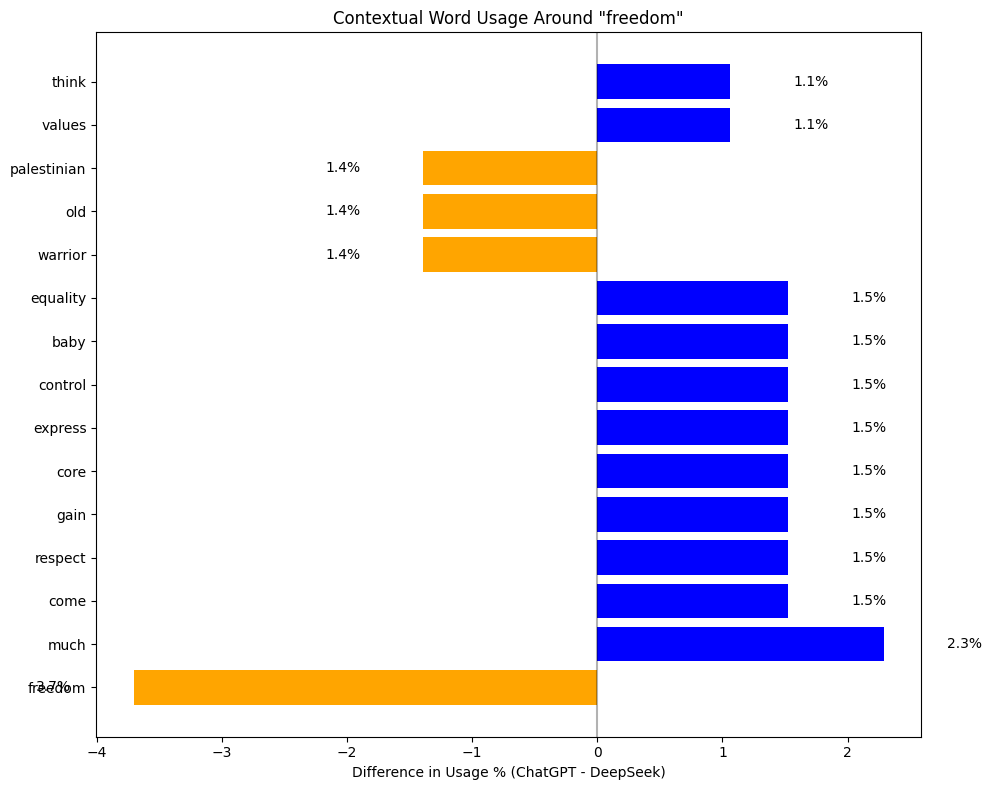

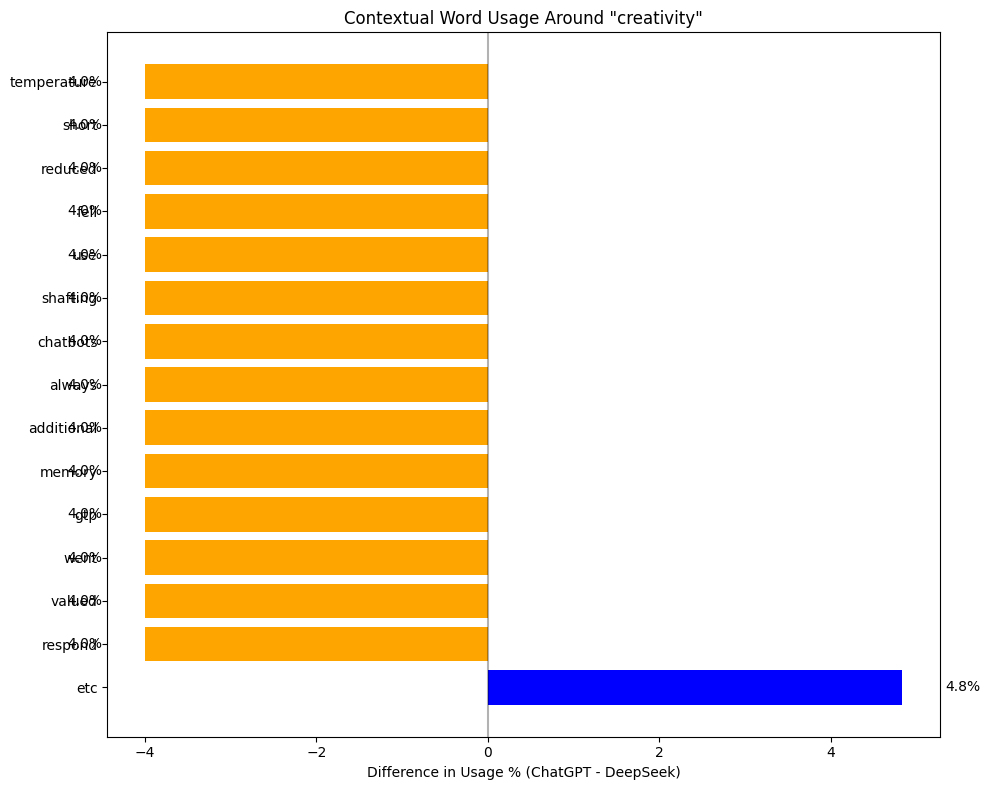

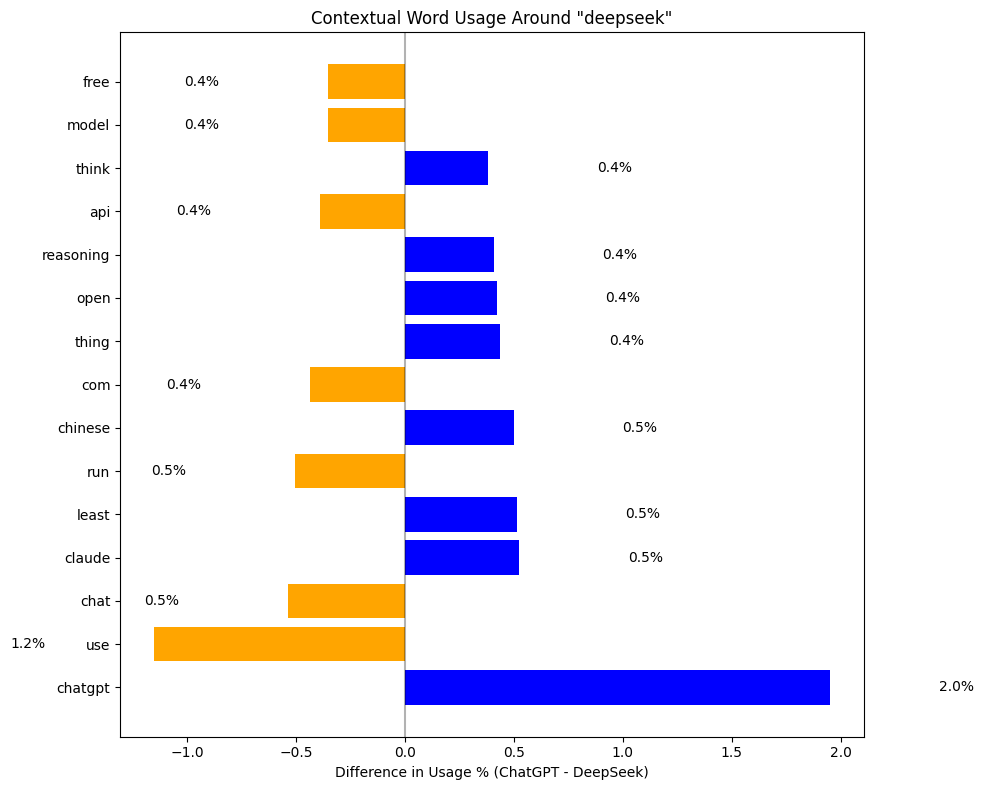

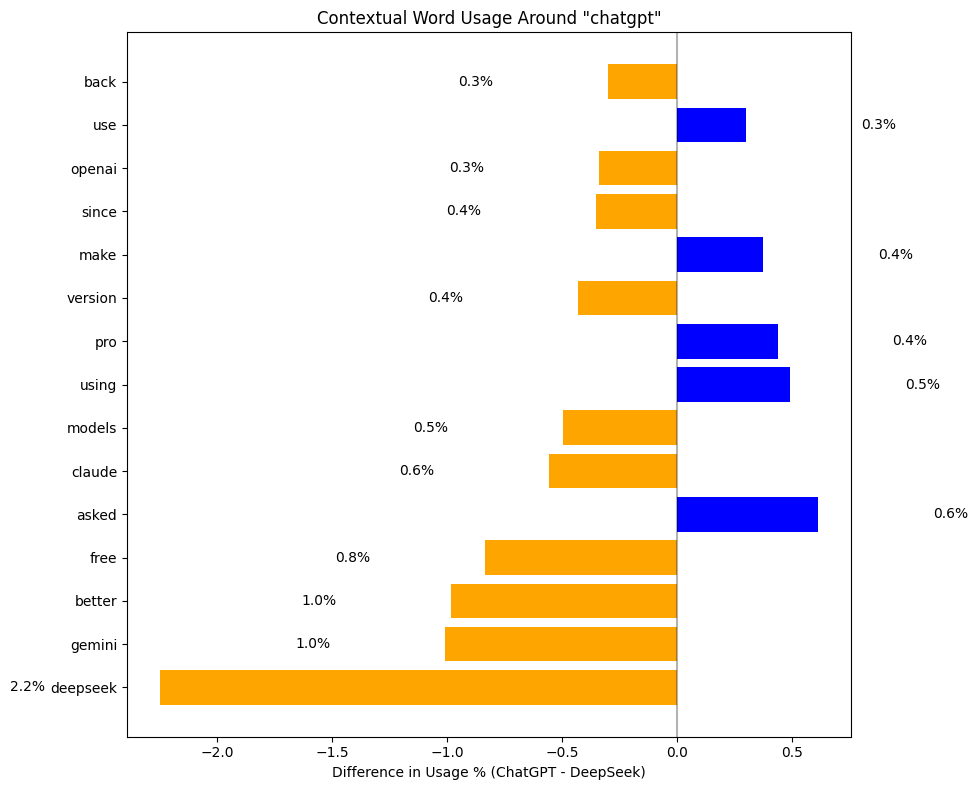

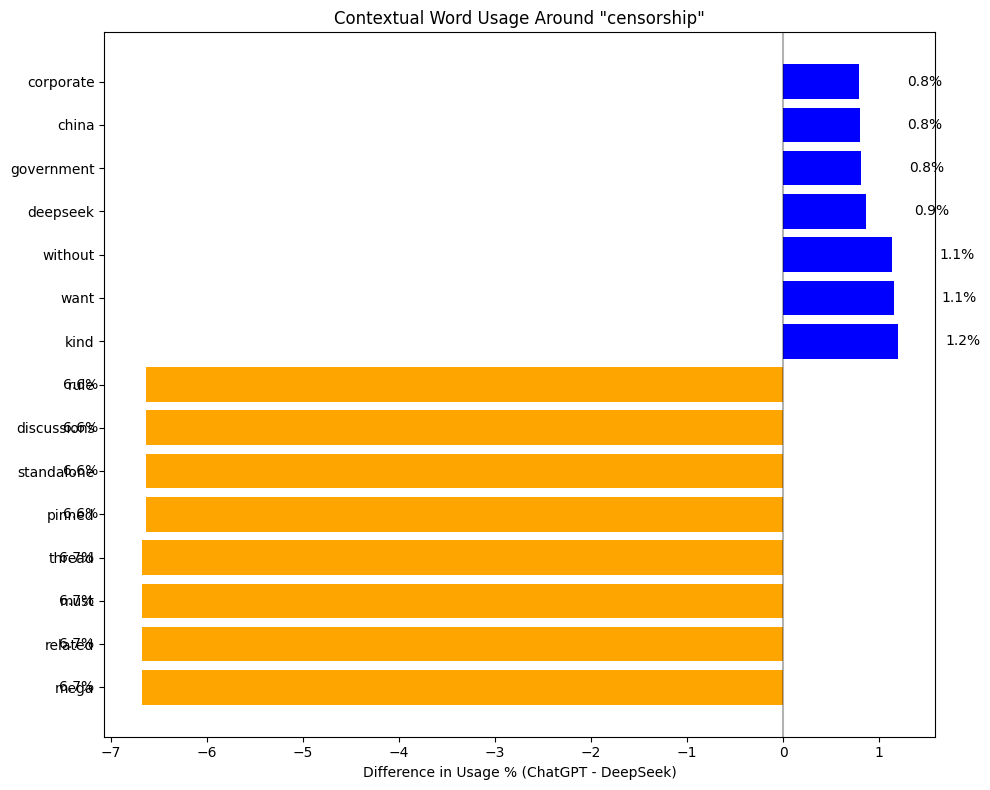

Running Topic-Term Relationship Analysis...


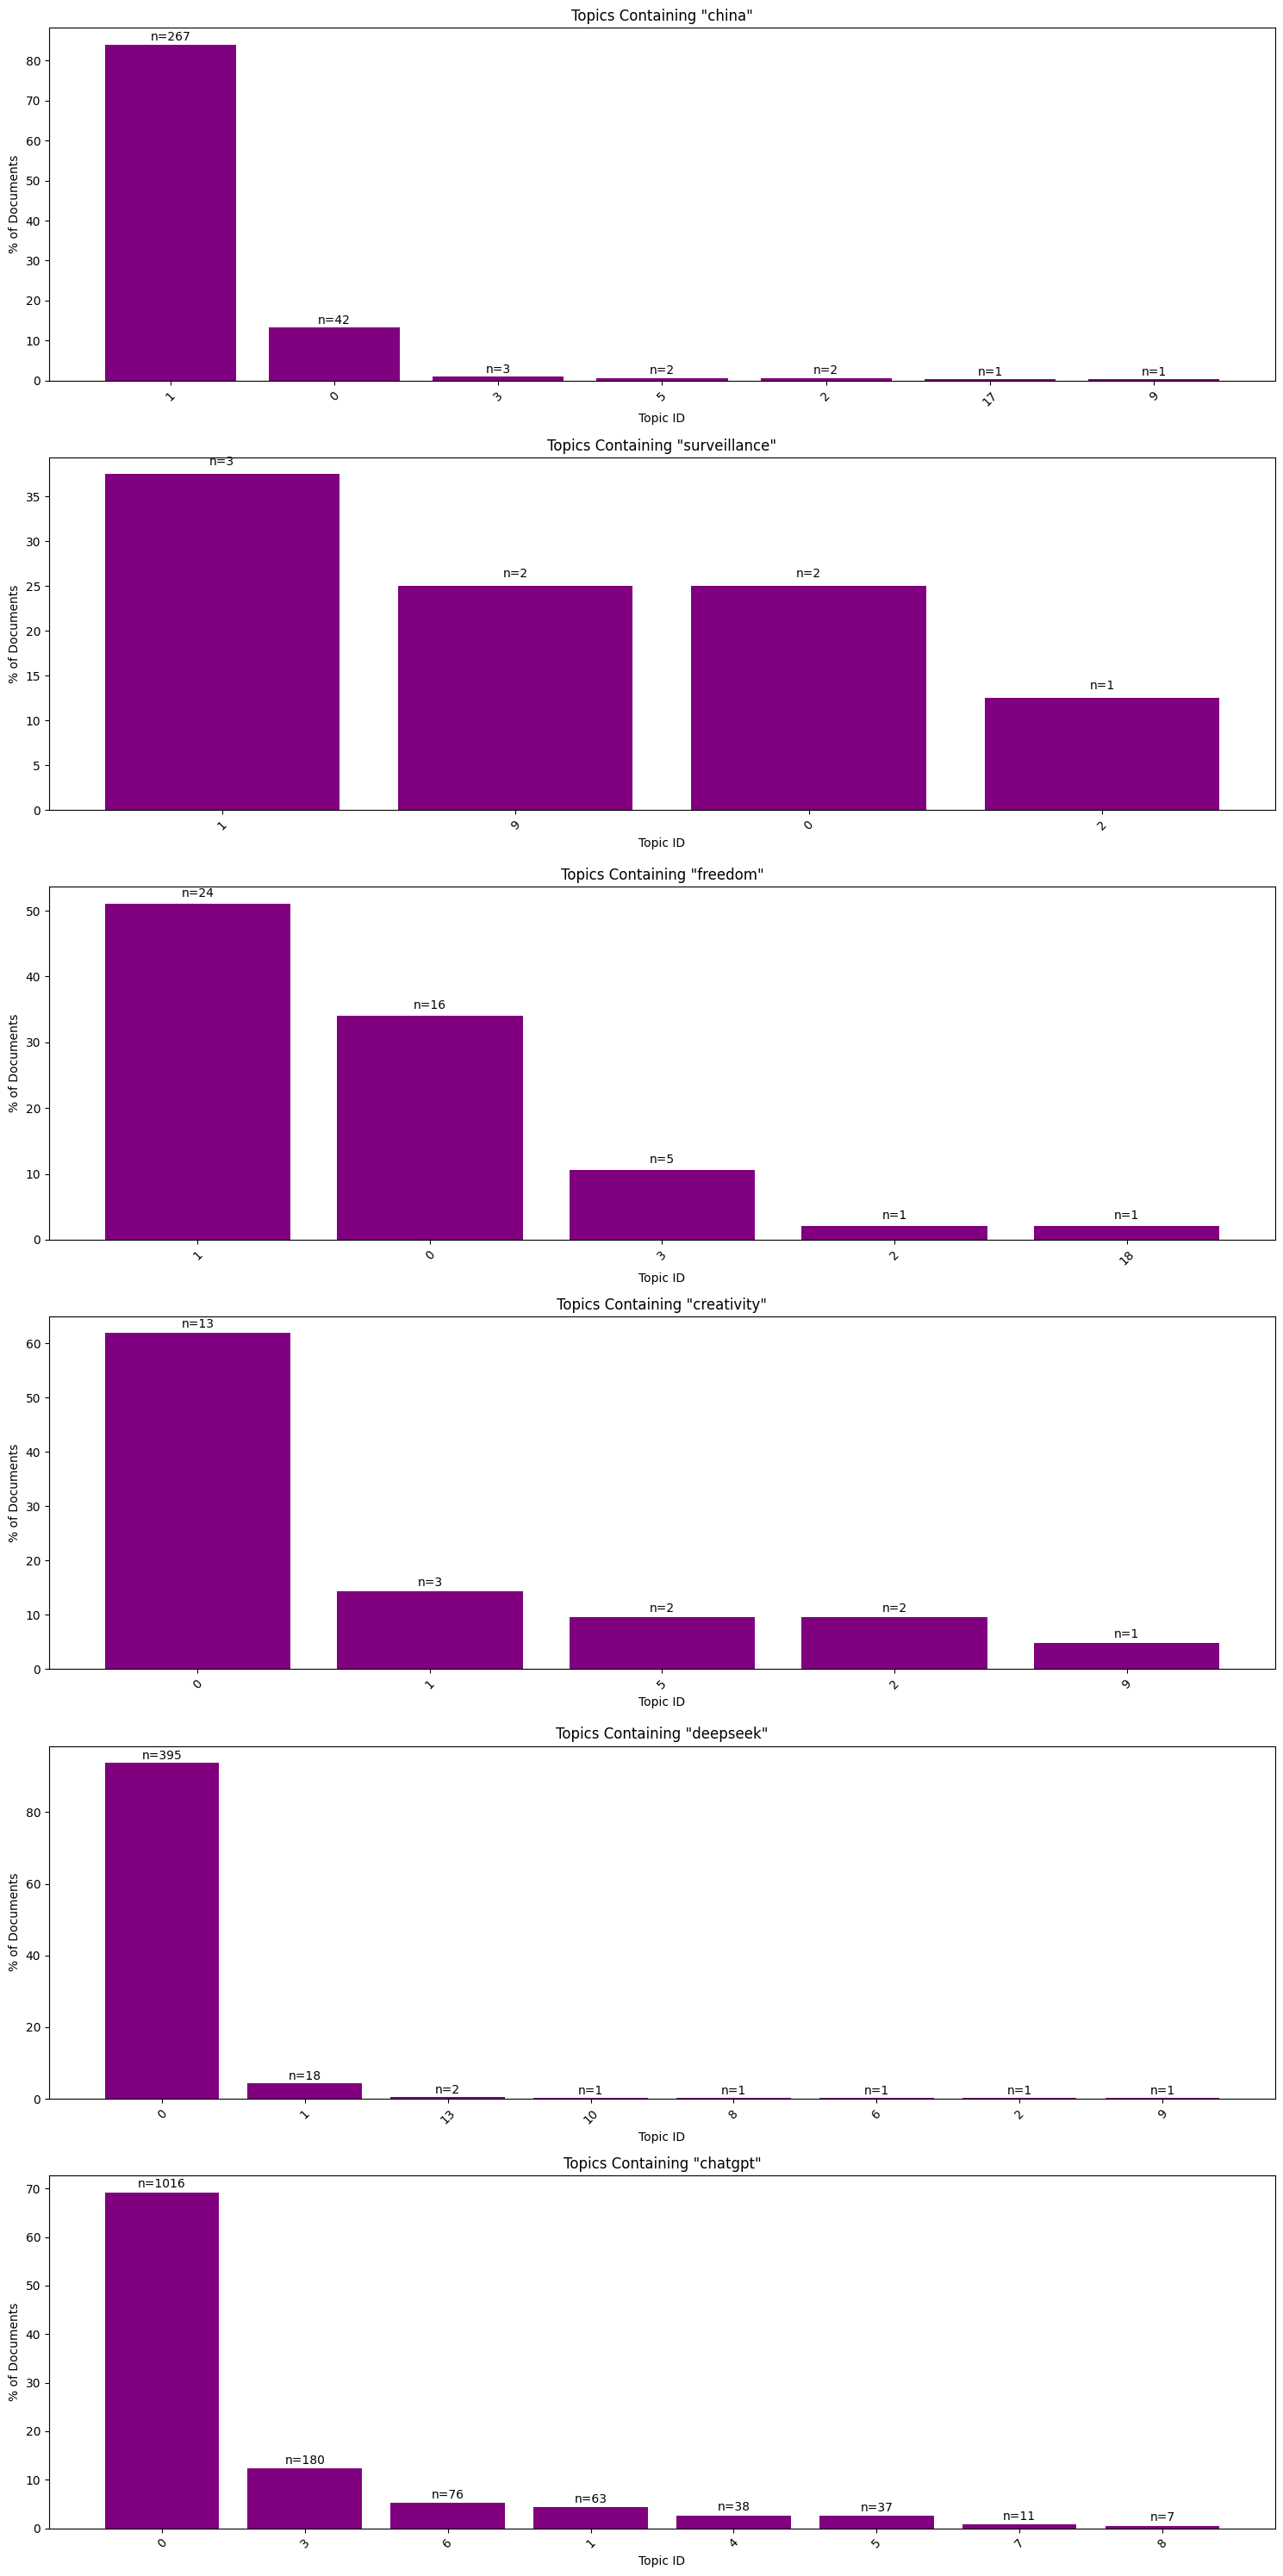

Analysis complete!


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.stats import chi2_contingency

# Load your data
chatgpt_df = pd.read_csv('/content/drive/My Drive/sampled_chatgpt_w_topic.csv')
deepseek_df = pd.read_csv('/content/drive/My Drive/deepseek_w_topic.csv')

# Define custom stopwords
STOP_WORDS = set(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",
                 "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his',
                 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself',
                 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
                 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be',
                 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a',
                 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
                 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during',
                 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on',
                 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when',
                 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other',
                 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too',
                 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've",
                 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn',
                 "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
                 "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
                 "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
                 "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", 'also',
                 'like', 'even', 'would', 'get', 'one', 'im', 'got', 'could'])

# Function to clean and tokenize text
def preprocess_text(text):
    if not isinstance(text, str):
        return []

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove special characters and numbers
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)

    # Tokenize
    tokens = text.split()

    # Remove stopwords
    tokens = [word for word in tokens if word not in STOP_WORDS and len(word) > 2]

    return tokens

# 1. Term Frequency Analysis
def analyze_term_frequency(chatgpt_df, deepseek_df):
    """Analyze and compare frequency of specific terms"""
    # Define key terms based on hypotheses
    key_terms = {
        'geopolitical': ['china', 'chinese', 'us', 'american', 'government', 'surveillance', 'political', 'west', 'western'],
        'capabilities': ['freedom', 'creativity', 'innovation', 'leadership', 'quality', 'performance', 'advanced'],
        'concerns': ['censorship', 'monitoring', 'privacy', 'security', 'control', 'risk', 'threat', 'fear', 'authoritarianism'],
        'technical': ['model', 'algorithm', 'capability', 'feature', 'performance', 'code', 'function', 'api']
    }

    # Process all texts
    chatgpt_text = ' '.join(chatgpt_df['text'].fillna('').astype(str))
    deepseek_text = ' '.join(deepseek_df['text'].fillna('').astype(str))

    # Create document corpora (1 document per subreddit)
    corpus = [chatgpt_text, deepseek_text]

    # Create term-document matrix
    count_vec = CountVectorizer(lowercase=True, token_pattern=r'\b\w+\b')
    X = count_vec.fit_transform(corpus)

    # Get all terms
    all_terms = count_vec.get_feature_names_out()

    # Calculate frequencies
    freqs = X.toarray()
    chatgpt_freqs = freqs[0]
    deepseek_freqs = freqs[1]

    # Total tokens in each corpus
    chatgpt_total = chatgpt_freqs.sum()
    deepseek_total = deepseek_freqs.sum()

    # Normalize (per 1000 tokens)
    chatgpt_norm = chatgpt_freqs / chatgpt_total * 1000
    deepseek_norm = deepseek_freqs / deepseek_total * 1000

    # Results for key terms
    results = []

    for category, terms in key_terms.items():
        for term in terms:
            # Find term index
            try:
                term_idx = list(all_terms).index(term)

                # Get raw counts
                chatgpt_count = chatgpt_freqs[term_idx]
                deepseek_count = deepseek_freqs[term_idx]

                # Get normalized frequencies
                chatgpt_term_norm = chatgpt_norm[term_idx]
                deepseek_term_norm = deepseek_norm[term_idx]

                # Statistical significance (Chi-square test)
                contingency_table = np.array([
                    [chatgpt_count, chatgpt_total - chatgpt_count],
                    [deepseek_count, deepseek_total - deepseek_count]
                ])

                try:
                    chi2, p_value, _, _ = chi2_contingency(contingency_table)
                    significant = p_value < 0.05
                except:
                    chi2, p_value, significant = 0, 1, False

                # Calculate relative prevalence
                if chatgpt_term_norm > 0 and deepseek_term_norm > 0:
                    if chatgpt_term_norm > deepseek_term_norm:
                        rel_prev = f"{chatgpt_term_norm/deepseek_term_norm:.2f}x more in ChatGPT"
                    else:
                        rel_prev = f"{deepseek_term_norm/chatgpt_term_norm:.2f}x more in DeepSeek"
                elif chatgpt_term_norm > 0:
                    rel_prev = "Only in ChatGPT"
                elif deepseek_term_norm > 0:
                    rel_prev = "Only in DeepSeek"
                else:
                    rel_prev = "Not found"

                results.append({
                    'Term': term,
                    'Category': category,
                    'ChatGPT_Count': chatgpt_count,
                    'DeepSeek_Count': deepseek_count,
                    'ChatGPT_Norm': chatgpt_term_norm,
                    'DeepSeek_Norm': deepseek_term_norm,
                    'Chi2': chi2,
                    'P_Value': p_value,
                    'Significant': significant,
                    'Relative_Prevalence': rel_prev
                })
            except ValueError:
                # Term not found in corpus
                continue

    results_df = pd.DataFrame(results)

    # Plot the results by category
    categories = results_df['Category'].unique()

    plt.figure(figsize=(15, len(categories) * 5))

    for i, category in enumerate(categories):
        plt.subplot(len(categories), 1, i+1)

        category_df = results_df[results_df['Category'] == category]
        category_df = category_df.sort_values('ChatGPT_Norm', ascending=False)

        terms = category_df['Term'].tolist()
        x = range(len(terms))
        width = 0.35

        plt.bar([i - width/2 for i in x], category_df['ChatGPT_Norm'], width, label='ChatGPT', color='blue')
        plt.bar([i + width/2 for i in x], category_df['DeepSeek_Norm'], width, label='DeepSeek', color='orange')

        plt.title(f'{category.capitalize()} Terms')
        plt.xlabel('Terms')
        plt.ylabel('Frequency per 1000 tokens')
        plt.xticks(x, terms, rotation=45, ha='right')
        plt.legend()

        # Mark significant differences
        for j, row in enumerate(category_df.itertuples()):
            if row.Significant:
                higher = max(row.ChatGPT_Norm, row.DeepSeek_Norm)
                plt.text(j, higher + 0.1, '*', ha='center', fontsize=16)

        plt.tight_layout()

    plt.savefig('term_frequency_comparison.png', bbox_inches='tight')
    plt.show()

    return results_df

# 2. Distinctive Words Analysis (simple)
def simple_distinctive_words(chatgpt_df, deepseek_df, top_n=20):
    """A simple implementation of distinctive words analysis"""
    print("Running simplified distinctive words analysis...")

    # Function to count words in a dataframe
    def count_words(df):
        # Join all text
        all_text = ' '.join(df['text'].fillna('').astype(str))

        # Convert to lowercase
        all_text = all_text.lower()

        # Remove special characters
        all_text = re.sub(r'[^\w\s]', ' ', all_text)

        # Split into words
        words = all_text.split()

        # Remove short words and numbers
        words = [word for word in words if len(word) > 2 and not word.isdigit()]

        # Remove common stop words
        words = [word for word in words if word not in STOP_WORDS]

        # Count words
        word_counts = Counter(words)

        # Calculate total words
        total = sum(word_counts.values())

        # Convert to dictionary of frequencies (per 1000 words)
        word_freqs = {word: (count / total) * 1000 for word, count in word_counts.items()}

        return word_freqs

    # Count words in both dataframes
    print("  Counting words in ChatGPT...")
    chatgpt_freqs = count_words(chatgpt_df)
    print("  Counting words in DeepSeek...")
    deepseek_freqs = count_words(deepseek_df)

    # Get all words
    all_words = set(chatgpt_freqs.keys()) | set(deepseek_freqs.keys())

    # Calculate distinctiveness scores
    print("  Calculating distinctiveness...")
    word_scores = []

    for word in all_words:
        chatgpt_freq = chatgpt_freqs.get(word, 0)
        deepseek_freq = deepseek_freqs.get(word, 0)

        # Skip very rare words
        if chatgpt_freq < 0.1 and deepseek_freq < 0.1:
            continue

        # Calculate ratio (add small value to prevent division by zero)
        if chatgpt_freq > deepseek_freq:
            ratio = chatgpt_freq / (deepseek_freq + 0.01)
            direction = "ChatGPT"
        else:
            ratio = deepseek_freq / (chatgpt_freq + 0.01)
            direction = "DeepSeek"

        # Calculate absolute difference
        diff = abs(chatgpt_freq - deepseek_freq)

        # Only include words with meaningful difference
        if diff > 0.1:
            word_scores.append({
                'word': word,
                'chatgpt_freq': chatgpt_freq,
                'deepseek_freq': deepseek_freq,
                'difference': chatgpt_freq - deepseek_freq,
                'ratio': ratio,
                'favors': direction
            })

    # Convert to dataframe
    scores_df = pd.DataFrame(word_scores)

    # Sort by absolute difference
    scores_df['abs_diff'] = scores_df['difference'].abs()
    scores_df = scores_df.sort_values('abs_diff', ascending=False)

    # Get top distinctive words
    chatgpt_words = scores_df[scores_df['favors'] == 'ChatGPT'].head(top_n)
    deepseek_words = scores_df[scores_df['favors'] == 'DeepSeek'].head(top_n)

    # Create result dataframe
    result_df = pd.DataFrame({
        'ChatGPT_Term': chatgpt_words['word'].values,
        'ChatGPT_Freq': chatgpt_words['chatgpt_freq'].values,
        'DeepSeek_Term': deepseek_words['word'].values,
        'DeepSeek_Freq': deepseek_words['deepseek_freq'].values,
    })

    # Visualize results
    print("  Creating visualization...")
    plt.figure(figsize=(12, 10))

    # ChatGPT distinctive terms
    plt.subplot(2, 1, 1)
    plt.barh(
        y=chatgpt_words['word'].values[:10][::-1],
        width=chatgpt_words['abs_diff'].values[:10][::-1],
        color='blue'
    )
    plt.title('Top Terms Distinctive to ChatGPT')
    plt.xlabel('Frequency Difference (per 1000 words)')

    # DeepSeek distinctive terms
    plt.subplot(2, 1, 2)
    plt.barh(
        y=deepseek_words['word'].values[:10][::-1],
        width=deepseek_words['abs_diff'].values[:10][::-1],
        color='orange'
    )
    plt.title('Top Terms Distinctive to DeepSeek')
    plt.xlabel('Frequency Difference (per 1000 words)')

    plt.tight_layout()
    plt.savefig('distinctive_terms.png')
    plt.show()

    print("  Analysis complete.")
    return result_df


# 3. Contextual Analysis (word context)
def analyze_word_context(chatgpt_df, deepseek_df, target_words, window=3):
    """Analyze context around key terms"""
    contexts = {}

    # Process each dataset
    for dataset_name, df in [('ChatGPT', chatgpt_df), ('DeepSeek', deepseek_df)]:
        contexts[dataset_name] = {}

        for target in target_words:
            contexts[dataset_name][target] = []

            # Find documents containing the target word
            pattern = r'\b' + re.escape(target) + r'\b'
            matching_docs = df[df['text'].fillna('').str.contains(pattern, case=False)]

            for text in matching_docs['text']:
                if not isinstance(text, str):
                    continue

                words = text.lower().split()

                for i, word in enumerate(words):
                    if re.match(pattern, word, re.IGNORECASE):
                        # Get context window
                        start = max(0, i - window)
                        end = min(len(words), i + window + 1)

                        # Exclude target word itself
                        context = words[start:i] + words[i+1:end]
                        contexts[dataset_name][target].extend(context)

    # Count and compare context words
    results = []

    for target in target_words:
        # Count word frequencies in each context
        chatgpt_counts = Counter(contexts['ChatGPT'].get(target, []))
        deepseek_counts = Counter(contexts['DeepSeek'].get(target, []))

        # Remove stopwords
        for word in list(chatgpt_counts.keys()):
            if word in STOP_WORDS or len(word) <= 2:
                del chatgpt_counts[word]

        for word in list(deepseek_counts.keys()):
            if word in STOP_WORDS or len(word) <= 2:
                del deepseek_counts[word]

        # Get total counts
        chatgpt_total = sum(chatgpt_counts.values())
        deepseek_total = sum(deepseek_counts.values())

        if chatgpt_total == 0 or deepseek_total == 0:
            continue

        # Normalize to percentages
        chatgpt_norm = {word: count/chatgpt_total*100 for word, count in chatgpt_counts.items()}
        deepseek_norm = {word: count/deepseek_total*100 for word, count in deepseek_counts.items()}

        # Get words from both contexts
        all_words = set(chatgpt_counts.keys()) | set(deepseek_counts.keys())

        # Calculate difference in usage
        for word in all_words:
            chatgpt_pct = chatgpt_norm.get(word, 0)
            deepseek_pct = deepseek_norm.get(word, 0)

            # Only include words with reasonable frequency
            if chatgpt_pct >= 0.5 or deepseek_pct >= 0.5:
                results.append({
                    'Target': target,
                    'Context_Word': word,
                    'ChatGPT_Pct': chatgpt_pct,
                    'DeepSeek_Pct': deepseek_pct,
                    'Difference': chatgpt_pct - deepseek_pct
                })

    results_df = pd.DataFrame(results)

    # Visualize context differences for each target
    for target in target_words:
        target_df = results_df[results_df['Target'] == target]

        if len(target_df) == 0:
            continue

        # Sort by absolute difference
        target_df['Abs_Diff'] = target_df['Difference'].abs()
        target_df = target_df.sort_values('Abs_Diff', ascending=False).head(15)

        plt.figure(figsize=(10, 8))

        bars = plt.barh(
            y=target_df['Context_Word'],
            width=target_df['Difference'],
            color=target_df['Difference'].apply(lambda x: 'blue' if x > 0 else 'orange')
        )

        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.xlabel('Difference in Usage % (ChatGPT - DeepSeek)')
        plt.title(f'Contextual Word Usage Around "{target}"')

        # Add labels for each bar
        for bar in bars:
            width = bar.get_width()
            label_pos = width + 0.5 if width > 0 else width - 0.5
            plt.text(label_pos, bar.get_y() + bar.get_height()/2,
                    f"{abs(width):.1f}%",
                    ha='left' if width > 0 else 'right',
                    va='center')

        plt.tight_layout()
        plt.savefig(f'context_{target}.png')
        plt.show()

    return results_df

# 4. Topic-Term Analysis
def analyze_topic_term_relationship(df, key_terms):
    """Analyze which topics contain key terms"""
    # Ensure topic column exists
    if 'topics' not in df.columns:
        print("No 'topics' column found in dataframe")
        return None

    results = []

    for term in key_terms:
        # Find documents containing the term
        pattern = r'\b' + re.escape(term) + r'\b'
        term_docs = df[df['text'].fillna('').str.contains(pattern, case=False)]

        if len(term_docs) == 0:
            continue

        # Count topics
        topic_counts = term_docs['topics'].value_counts()
        total_docs = len(term_docs)

        # Calculate percentages
        for topic, count in topic_counts.items():
            results.append({
                'Term': term,
                'Topic': topic,
                'Count': count,
                'Percentage': count / total_docs * 100
            })

    results_df = pd.DataFrame(results)

    # Visualize for selected terms
    selected_terms = key_terms[:min(6, len(key_terms))]  # Limit to 6 terms for visibility

    plt.figure(figsize=(15, len(selected_terms) * 5))

    for i, term in enumerate(selected_terms):
        term_data = results_df[results_df['Term'] == term]

        if len(term_data) == 0:
            continue

        plt.subplot(len(selected_terms), 1, i+1)

        term_data = term_data.sort_values('Count', ascending=False).head(8)

        plt.bar(
            term_data['Topic'].astype(str),
            term_data['Percentage'],
            color='purple'
        )

        plt.title(f'Topics Containing "{term}"')
        plt.xlabel('Topic ID')
        plt.ylabel('% of Documents')
        plt.xticks(rotation=45)

        # Add count labels
        for j, row in enumerate(term_data.itertuples()):
            plt.text(j, row.Percentage + 1, f"n={row.Count}", ha='center')

    plt.tight_layout()
    plt.savefig('term_topic_relationship.png')
    plt.show()

    return results_df

# Run analyses
print("Running Term Frequency Analysis...")
term_freq = analyze_term_frequency(chatgpt_df, deepseek_df)
term_freq.to_csv('term_frequency_analysis.csv', index=False)

print("Running Distinctive Words Analysis...")
distinctive = simple_distinctive_words(chatgpt_df, deepseek_df)
distinctive.to_csv('distinctive_words.csv', index=False)

print("Running Contextual Analysis...")
key_terms = ['china', 'surveillance', 'freedom', 'creativity', 'deepseek', 'chatgpt', 'censorship']
context = analyze_word_context(chatgpt_df, deepseek_df, key_terms)
context.to_csv('contextual_analysis.csv', index=False)

print("Running Topic-Term Relationship Analysis...")
topic_term = analyze_topic_term_relationship(chatgpt_df, key_terms)
if topic_term is not None:
    topic_term.to_csv('topic_term_analysis.csv', index=False)

print("Analysis complete!")

## r/DeepSeek Clustering (k-means)

In [59]:
ds_probs_df = pd.read_csv("/content/drive/MyDrive/deepseek_doc_probs.csv")
ds_probs_df[:3]

0         1         2         3         4         5         6  \
0  0.142242  0.072000  0.025265  0.005761  0.005972  0.007181  0.003625   
1  0.042133  0.019606  0.007309  0.000849  0.002199  0.001448  0.001001   
2  1.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

              7         8        9        10            11        12  \
0  8.238646e-04  0.001600  0.00202  0.001452  1.659858e-03  0.003450   
1  7.932141e-45  0.000435  0.00086  0.000398  5.307568e-37  0.000946   
2  0.000000e+00  0.000000  0.00000  0.000000  0.000000e+00  0.000000   

             13            14        15        16        17            18  
0  5.580987e-04  1.511358e-03  0.001520  0.002096  0.001746  1.191508e-03  
1  3.677480e-45  2.732400e-43  0.000435  0.000578  0.000844  4.514862e-44  
2  0.000000e+00  0.000000e+00  0.000000  0.000000  0.000000  0.000000e+00

In [60]:
deepseek_df = pd.read_csv("/content/drive/MyDrive/deepseek_w_topic.csv")

In [61]:
deepseek_df[:3]

subreddit                author        date  \
0  DeepSeek              Anuclano  2024-12-27   
1  DeepSeek  Positive_Average_446  2024-12-28   
2  DeepSeek  Positive_Average_446  2024-12-28   

                                                text      type  \
0  Those LLMs are notorious to not know who they ...  comments   
1  Doesn t its system prompt states its name thou...  comments   
2  I got this error when trying to log in with br...  comments   

                                        emotions_txt  emotion_labels  \
0  {'label': 'neutral', 'score': 0.9242384433746338}         neutral   
1  {'label': 'neutral', 'score': 0.8529666662216187}         neutral   
2  {'label': 'disappointment', 'score': 0.2567110...  disappointment   

   emotion_prob sentiment_category  topics                          theme  
0      0.924238            neutral       0  Deepseek Technical Discussion  
1      0.852967            neutral       4       Claude Model Comparisons  
2      0.256711           negative       0  Deepseek Technical Discussion

In [62]:
combined_df = pd.concat([deepseek_df, ds_probs_df], axis=1)
combined_df[:3]

subreddit                author        date  \
0  DeepSeek              Anuclano  2024-12-27   
1  DeepSeek  Positive_Average_446  2024-12-28   
2  DeepSeek  Positive_Average_446  2024-12-28   

                                                text      type  \
0  Those LLMs are notorious to not know who they ...  comments   
1  Doesn t its system prompt states its name thou...  comments   
2  I got this error when trying to log in with br...  comments   

                                        emotions_txt  emotion_labels  \
0  {'label': 'neutral', 'score': 0.9242384433746338}         neutral   
1  {'label': 'neutral', 'score': 0.8529666662216187}         neutral   
2  {'label': 'disappointment', 'score': 0.2567110...  disappointment   

   emotion_prob sentiment_category  topics  ...        9        10  \
0      0.924238            neutral       0  ...  0.00202  0.001452   
1      0.852967            neutral       4  ...  0.00086  0.000398   
2      0.256711           negative       0  ...  0.00000  0.000000   

             11        12            13            14        15        16  \
0  1.659858e-03  0.003450  5.580987e-04  1.511358e-03  0.001520  0.002096   
1  5.307568e-37  0.000946  3.677480e-45  2.732400e-43  0.000435  0.000578   
2  0.000000e+00  0.000000  0.000000e+00  0.000000e+00  0.000000  0.000000   

         17            18  
0  0.001746  1.191508e-03  
1  0.000844  4.514862e-44  
2  0.000000  0.000000e+00  

[3 rows x 30 columns]

In [63]:
topic_prob_name = {}
for i in range(19):
  topic_prob_name[str(i)] = f'topic_prob_{i}'

combined_df = combined_df.rename(columns=topic_prob_name)

In [64]:
combined_df.to_csv('/content/drive/MyDrive/training_for_cluster_deepseek.csv')

In [65]:
df = pd.read_csv('/content/drive/MyDrive/training_for_cluster_deepseek.csv')

In [66]:
df.columns

Index(['Unnamed: 0', 'subreddit', 'author', 'date', 'text', 'type',
       'emotions_txt', 'emotion_labels', 'emotion_prob', 'sentiment_category',
       'topics', 'theme', 'topic_prob_0', 'topic_prob_1', 'topic_prob_2',
       'topic_prob_3', 'topic_prob_4', 'topic_prob_5', 'topic_prob_6',
       'topic_prob_7', 'topic_prob_8', 'topic_prob_9', 'topic_prob_10',
       'topic_prob_11', 'topic_prob_12', 'topic_prob_13', 'topic_prob_14',
       'topic_prob_15', 'topic_prob_16', 'topic_prob_17', 'topic_prob_18'],
      dtype='object')

In [ ]:
df[:3]

Unnamed: 0 subreddit                author        date  \
0           0  DeepSeek              Anuclano  2024-12-27   
1           1  DeepSeek  Positive_Average_446  2024-12-28   
2           2  DeepSeek  Positive_Average_446  2024-12-28   

                                                text      type  \
0  Those LLMs are notorious to not know who they ...  comments   
1  Doesn t its system prompt states its name thou...  comments   
2  I got this error when trying to log in with br...  comments   

                                        emotions_txt  emotion_labels  \
0  {'label': 'neutral', 'score': 0.9242384433746338}         neutral   
1  {'label': 'neutral', 'score': 0.8529666662216187}         neutral   
2  {'label': 'disappointment', 'score': 0.2567110...  disappointment   

   emotion_prob sentiment_category  ...  topic_prob_9 topic_prob_10  \
0      0.924238            neutral  ...       0.00202      0.001452   
1      0.852967            neutral  ...       0.00086      0.000398   
2      0.256711           negative  ...       0.00000      0.000000   

   topic_prob_11  topic_prob_12  topic_prob_13  topic_prob_14  topic_prob_15  \
0   1.659858e-03       0.003450   5.580987e-04   1.511358e-03       0.001520   
1   5.307568e-37       0.000946   3.677480e-45   2.732400e-43       0.000435   
2   0.000000e+00       0.000000   0.000000e+00   0.000000e+00       0.000000   

   topic_prob_16  topic_prob_17  topic_prob_18  
0       0.002096       0.001746   1.191508e-03  
1       0.000578       0.000844   4.514862e-44  
2       0.000000       0.000000   0.000000e+00  

[3 rows x 31 columns]

### Determining Optimal Number of Clusters


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [ ]:
def determine_best_k_elbow(df, max_clusters):
    """
    Determine the optimal number of clusters using the elbow method

    Parameters:
    df - DataFrame with data
    max_clusters - Maximum number of clusters to try

    Returns:
    Recommended optimal number of clusters
    """
    # 1. Extract topic probability features
    topic_cols = [col for col in df.columns if re.match(r'^topic_prob_\d+$', col)]
    features = df[topic_cols].values

    # 2. Calculate inertia for different k values
    inertia = []
    k_range = range(1, min(max_clusters + 1, len(df) // 30 + 2))

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(features)
        inertia.append(kmeans.inertia_)
        print(f"Clusters k={k}, inertia={kmeans.inertia_:.2f}")

    # 3. Plot the elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertia, 'o-', linewidth=2)
    plt.xlabel('Number of clusters (k)', fontsize=12)
    plt.ylabel('Inertia', fontsize=12)
    plt.title('Elbow Method for Determining Optimal Number of Clusters', fontsize=14)
    plt.grid(True)
    plt.xticks(list(k_range))
    plt.tight_layout()
    plt.show()


Clusters k=1, inertia=4760.69
Clusters k=2, inertia=2433.44
Clusters k=3, inertia=1389.89
Clusters k=4, inertia=853.50
Clusters k=5, inertia=716.26
Clusters k=6, inertia=608.61
Clusters k=7, inertia=554.46
Clusters k=8, inertia=492.57
Clusters k=9, inertia=452.57
Clusters k=10, inertia=411.91


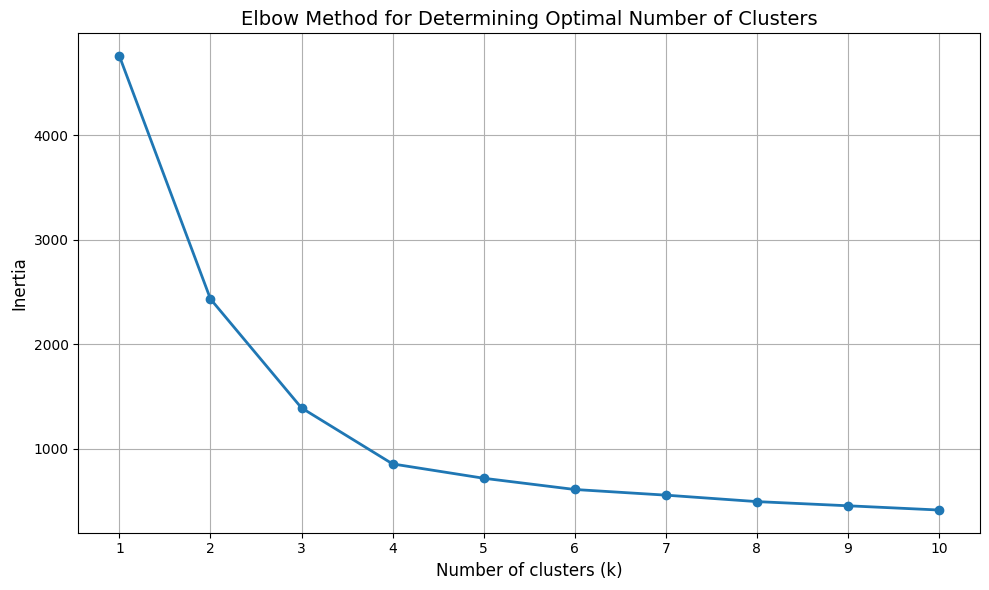

In [ ]:
determine_best_k_elbow(df, 10)

In [ ]:
def determine_best_k_silhouette(df, max_clusters):
    """
    Determine the optimal number of clusters using silhouette score

    Parameters:
    df - DataFrame with data
    max_clusters - Maximum number of clusters to try

    Returns:
    Recommended optimal number of clusters
    """
    # 1. Extract topic probability features
    topic_cols = [col for col in df.columns if re.match(r'^topic_prob_\d+$', col)]
    features = df[topic_cols].values

    # 2. Calculate silhouette scores for different k values
    silhouette_scores = []
    k_range = range(2, min(max_clusters + 1, len(df) // 30 + 2))

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(features)
        score = silhouette_score(features, labels)
        silhouette_scores.append(score)
        print(f"Clusters k={k}, silhouette score={score:.4f}")

    # 3. Plot silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, 'o-', linewidth=2)
    plt.xlabel('Number of clusters (k)', fontsize=12)
    plt.ylabel('Silhouette Score', fontsize=12)
    plt.title('Silhouette Method for Determining Optimal Number of Clusters', fontsize=14)
    plt.grid(True)
    plt.xticks(list(k_range))
    plt.tight_layout()
    plt.show()

Clusters k=2, silhouette score=0.5036
Clusters k=3, silhouette score=0.5777
Clusters k=4, silhouette score=0.6343
Clusters k=5, silhouette score=0.5191
Clusters k=6, silhouette score=0.5354
Clusters k=7, silhouette score=0.5450
Clusters k=8, silhouette score=0.5562
Clusters k=9, silhouette score=0.5076
Clusters k=10, silhouette score=0.5352


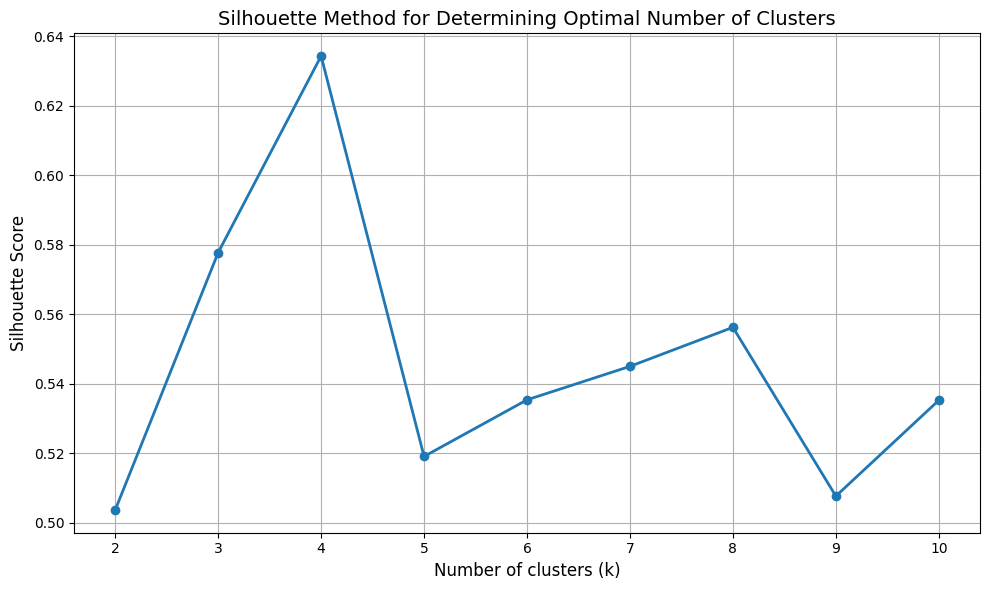

In [ ]:
determine_best_k_silhouette(df, 10)

### Applying Clustering

In [67]:
def apply_kmeans_clustering(df, n_clusters):
    """
    Apply K-means clustering to the dataset

    Parameters:
    df - DataFrame with data
    n_clusters - Number of clusters to form

    Returns:
    DataFrame with cluster assignments, trained model
    """
    # Extract topic probability features
    topic_cols = [col for col in df.columns if re.match(r'^topic_prob_\d+$', col)]
    features = df[topic_cols].values

    print(f"Applying K-means clustering with {n_clusters} clusters...")

    # Apply K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(features)

    # Add cluster labels to the dataframe
    df_with_clusters = df.copy()
    df_with_clusters['cluster'] = cluster_labels

    print(f"Clustering completed. {len(df_with_clusters)} documents assigned to {n_clusters} clusters.")

    # Return the dataframe with cluster assignments and the model
    return df_with_clusters, kmeans

In [68]:
df_with_clusters, kmeans = apply_kmeans_clustering(df, n_clusters=4)

Applying K-means clustering with 4 clusters...
Clustering completed. 15748 documents assigned to 4 clusters.


In [69]:
df_with_clusters

Unnamed: 0 subreddit                author        date  \
0               0  DeepSeek              Anuclano  2024-12-27   
1               1  DeepSeek  Positive_Average_446  2024-12-28   
2               2  DeepSeek  Positive_Average_446  2024-12-28   
3               3  DeepSeek  Positive_Average_446  2024-12-28   
4               4  DeepSeek    redswan_cosignitor  2024-12-29   
...           ...       ...                   ...         ...   
15743       15743  DeepSeek         semsiogluberk  2025-03-01   
15744       15744  DeepSeek           RemindMeBot  2025-03-01   
15745       15745  DeepSeek          Fanyang-Meng  2025-03-01   
15746       15746  DeepSeek              jarec707  2025-03-01   
15747       15747  DeepSeek          Fanyang-Meng  2025-03-01   

                                                    text      type  \
0      Those LLMs are notorious to not know who they ...  comments   
1      Doesn t its system prompt states its name thou...  comments   
2      I got this error when trying to log in with br...  comments   
3      Ah yep just tested Its prompt only say AI assi...  comments   
4      I actually noticed that it falls back on using...  comments   
...                                                  ...       ...   
15743  It won t work I need long context window and b...  comments   
15744  I m really sorry about replying to this so lat...  comments   
15745  Yeah auto complete somehow is also one way to ...  comments   
15746  I found it well informed and comprehensive Wel...  comments   
15747  Wow that s actually something I want to read t...  comments   

                                            emotions_txt  emotion_labels  \
0      {'label': 'neutral', 'score': 0.9242384433746338}         neutral   
1      {'label': 'neutral', 'score': 0.8529666662216187}         neutral   
2      {'label': 'disappointment', 'score': 0.2567110...  disappointment   
3      {'label': 'amusement', 'score': 0.909096181392...       amusement   
4      {'label': 'realization', 'score': 0.6099989414...     realization   
...                                                  ...             ...   
15743  {'label': 'disapproval', 'score': 0.7025867104...     disapproval   
15744  {'label': 'remorse', 'score': 0.8016937971115112}         remorse   
15745  {'label': 'optimism', 'score': 0.4413124322891...        optimism   
15746  {'label': 'admiration', 'score': 0.76443564891...      admiration   
15747  {'label': 'gratitude', 'score': 0.975107848644...       gratitude   

       emotion_prob sentiment_category  ...  topic_prob_10  topic_prob_11  \
0          0.924238            neutral  ...   1.451786e-03   1.659858e-03   
1          0.852967            neutral  ...   3.979800e-04   5.307568e-37   
2          0.256711           negative  ...   0.000000e+00   0.000000e+00   
3          0.909096          ambiguous  ...   6.477487e-04   1.021424e-03   
4          0.609999          ambiguous  ...   1.585134e-58   6.647812e-62   
...             ...                ...  ...            ...            ...   
15743      0.702587           negative  ...   0.000000e+00   0.000000e+00   
15744      0.801694           negative  ...   0.000000e+00   0.000000e+00   
15745      0.441312           positive  ...  2.829079e-134  3.720386e-136   
15746      0.764436           positive  ...   0.000000e+00   0.000000e+00   
15747      0.975108           positive  ...  2.029171e-159  5.003453e-161   

       topic_prob_12  topic_prob_13  topic_prob_14  topic_prob_15  \
0       3.449529e-03   5.580987e-04   1.511358e-03   1.520059e-03   
1       9.464671e-04   3.677480e-45   2.732400e-43   4.347660e-04   
2       0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00   
3       1.420043e-03   3.269162e-04   6.201919e-04   6.662356e-04   
4       2.245569e-03   3.212244e-63   2.006560e-62   2.673907e-03   
...              ...            ...            ...            ...   
15743   0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+0

In [72]:
df_with_clusters.columns

Index(['Unnamed: 0', 'subreddit', 'author', 'date', 'text', 'type',
       'emotions_txt', 'emotion_labels', 'emotion_prob', 'sentiment_category',
       'topics', 'theme', 'topic_prob_0', 'topic_prob_1', 'topic_prob_2',
       'topic_prob_3', 'topic_prob_4', 'topic_prob_5', 'topic_prob_6',
       'topic_prob_7', 'topic_prob_8', 'topic_prob_9', 'topic_prob_10',
       'topic_prob_11', 'topic_prob_12', 'topic_prob_13', 'topic_prob_14',
       'topic_prob_15', 'topic_prob_16', 'topic_prob_17', 'topic_prob_18',
       'cluster'],
      dtype='object')

In [70]:
df_with_clusters.to_csv('/content/drive/MyDrive/deepseek_k-mean_clustered.csv')

### Visualizing Clusters

#### PCA Clustering

In [ ]:
def visualize_clusters_with_pca(df_with_clusters, kmeans_model):
    """
    Visualize clustering results using PCA

    Parameters:
    df_with_clusters - DataFrame with cluster assignments
    kmeans_model - Trained K-means model
    """
    # Extract topic probability features
    topic_cols = [col for col in df_with_clusters.columns if re.match(r'^topic_prob_\d+$', col)]
    features = df_with_clusters[topic_cols].values

    # Apply PCA for visualization
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features)

    # Get cluster labels
    cluster_labels = df_with_clusters['cluster'].values

    # Plot the clusters
    plt.figure(figsize=(12, 10))

    # Create a scatter plot colored by cluster
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1],
                         c=cluster_labels, cmap='viridis',
                         s=50, alpha=0.7)

    # Add cluster centers
    centers_2d = pca.transform(kmeans_model.cluster_centers_)
    plt.scatter(centers_2d[:, 0], centers_2d[:, 1],
               marker='X', s=200, c='red', alpha=0.8)

    plt.colorbar(scatter, label='Cluster')
    plt.title(f'PCA Visualization of K-means Clustering (k={len(kmeans_model.cluster_centers_)})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Explain variance captured by PCA
    explained_variance = pca.explained_variance_ratio_
    print(f"Variance explained by the first two principal components: {sum(explained_variance)*100:.2f}%")
    print(f"  - PC1: {explained_variance[0]*100:.2f}%")
    print(f"  - PC2: {explained_variance[1]*100:.2f}%")

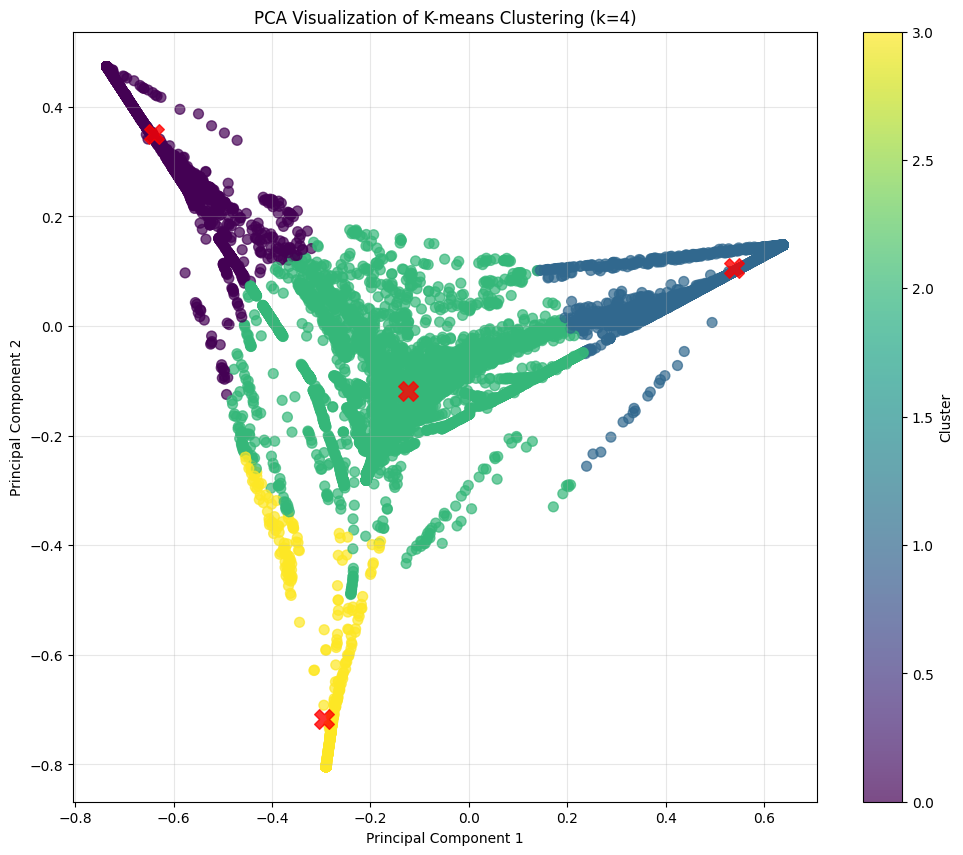

Variance explained by the first two principal components: 83.58%
  - PC1: 62.15%
  - PC2: 21.43%


In [ ]:
visualize_clusters_with_pca(df_with_clusters, kmeans)

#### Cluster Size

In [ ]:
def visualize_cluster_sizes(df_with_clusters, n_clusters):
    """
    Visualize the distribution of documents across clusters
    """
    # Count documents in each cluster
    cluster_counts = df_with_clusters['cluster'].value_counts().sort_index()

    # Calculate percentages
    total_docs = len(df_with_clusters)
    percentages = (cluster_counts / total_docs * 100).round(1)

    # Create visualization
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(n_clusters), cluster_counts)

    # Add percentage labels on top of each bar
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                f"{percentages[i]}%", ha='center')

    plt.xlabel('Cluster ID', fontsize=12)
    plt.ylabel('Number of Documents', fontsize=12)
    plt.title('Document Distribution Across Clusters', fontsize=14)
    plt.xticks(range(n_clusters))
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

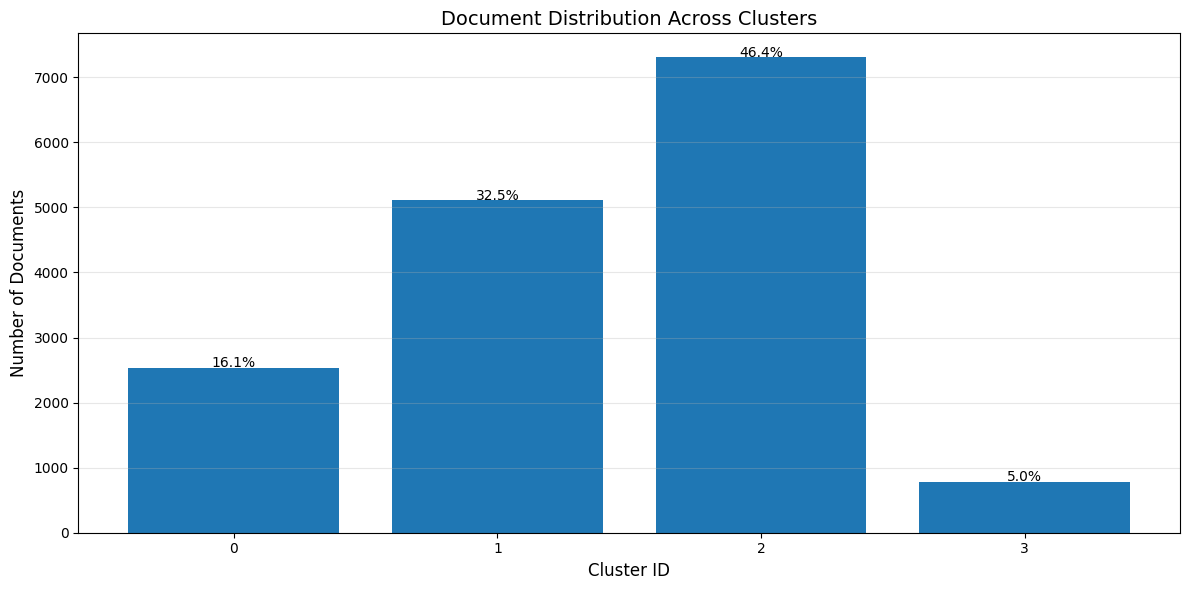

In [ ]:
visualize_cluster_sizes(df_with_clusters, 4)

#### Cluster Topic Profile

In [ ]:
def visualize_cluster_topic_profiles(df_with_clusters, n_clusters):
    """
    Visualize the topic distribution profiles for each cluster
    """
    # Extract topic columns
    topic_cols = [col for col in df_with_clusters.columns if re.match(r'^topic_prob_\d+$', col)]

    # Create heatmap of topic distributions across clusters
    cluster_topic_means = df_with_clusters.groupby('cluster')[topic_cols].mean()

    # Rename columns to make them more readable
    readable_cols = [f"Topic {col.split('_')[-1]}" for col in topic_cols]
    cluster_topic_means.columns = readable_cols

    plt.figure(figsize=(14, 10))
    ax = sns.heatmap(cluster_topic_means, cmap="YlGnBu", annot=True, fmt=".3f",
                     linewidths=.5, cbar_kws={"label": "Average Topic Probability"})
    plt.title('Topic Distribution Across Clusters', fontsize=14)
    plt.xlabel('Topics', fontsize=12)
    plt.ylabel('Cluster ID', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Create individual topic profile bar charts for each cluster
    fig, axes = plt.subplots(n_clusters, 1, figsize=(12, n_clusters * 4))

    for i in range(n_clusters):
        # Get topic distribution for this cluster
        topic_distribution = cluster_topic_means.iloc[i]
        # Sort by probability for better visualization
        topic_distribution = topic_distribution.sort_values(ascending=False)

        # Plot horizontal bar chart
        ax = axes[i] if n_clusters > 1 else axes
        ax.barh(topic_distribution.index, topic_distribution.values)
        ax.set_title(f'Cluster {i} Topic Profile')
        ax.set_xlim(0, max(topic_distribution.values) * 1.1)
        ax.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:
df_with_clusters

Unnamed: 0 subreddit                author        date  \
0               0  DeepSeek              Anuclano  2024-12-27   
1               1  DeepSeek  Positive_Average_446  2024-12-28   
2               2  DeepSeek  Positive_Average_446  2024-12-28   
3               3  DeepSeek  Positive_Average_446  2024-12-28   
4               4  DeepSeek    redswan_cosignitor  2024-12-29   
...           ...       ...                   ...         ...   
15743       15743  DeepSeek         semsiogluberk  2025-03-01   
15744       15744  DeepSeek           RemindMeBot  2025-03-01   
15745       15745  DeepSeek          Fanyang-Meng  2025-03-01   
15746       15746  DeepSeek              jarec707  2025-03-01   
15747       15747  DeepSeek          Fanyang-Meng  2025-03-01   

                                                    text      type  \
0      Those LLMs are notorious to not know who they ...  comments   
1      Doesn t its system prompt states its name thou...  comments   
2      I got this error when trying to log in with br...  comments   
3      Ah yep just tested Its prompt only say AI assi...  comments   
4      I actually noticed that it falls back on using...  comments   
...                                                  ...       ...   
15743  It won t work I need long context window and b...  comments   
15744  I m really sorry about replying to this so lat...  comments   
15745  Yeah auto complete somehow is also one way to ...  comments   
15746  I found it well informed and comprehensive Wel...  comments   
15747  Wow that s actually something I want to read t...  comments   

                                            emotions_txt  emotion_labels  \
0      {'label': 'neutral', 'score': 0.9242384433746338}         neutral   
1      {'label': 'neutral', 'score': 0.8529666662216187}         neutral   
2      {'label': 'disappointment', 'score': 0.2567110...  disappointment   
3      {'label': 'amusement', 'score': 0.909096181392...       amusement   
4      {'label': 'realization', 'score': 0.6099989414...     realization   
...                                                  ...             ...   
15743  {'label': 'disapproval', 'score': 0.7025867104...     disapproval   
15744  {'label': 'remorse', 'score': 0.8016937971115112}         remorse   
15745  {'label': 'optimism', 'score': 0.4413124322891...        optimism   
15746  {'label': 'admiration', 'score': 0.76443564891...      admiration   
15747  {'label': 'gratitude', 'score': 0.975107848644...       gratitude   

       emotion_prob sentiment_category  ...  topic_prob_10  topic_prob_11  \
0          0.924238            neutral  ...   1.451786e-03   1.659858e-03   
1          0.852967            neutral  ...   3.979800e-04   5.307568e-37   
2          0.256711           negative  ...   0.000000e+00   0.000000e+00   
3          0.909096          ambiguous  ...   6.477487e-04   1.021424e-03   
4          0.609999          ambiguous  ...   1.585134e-58   6.647812e-62   
...             ...                ...  ...            ...            ...   
15743      0.702587           negative  ...   0.000000e+00   0.000000e+00   
15744      0.801694           negative  ...   0.000000e+00   0.000000e+00   
15745      0.441312           positive  ...  2.829079e-134  3.720386e-136   
15746      0.764436           positive  ...   0.000000e+00   0.000000e+00   
15747      0.975108           positive  ...  2.029171e-159  5.003453e-161   

       topic_prob_12  topic_prob_13  topic_prob_14  topic_prob_15  \
0       3.449529e-03   5.580987e-04   1.511358e-03   1.520059e-03   
1       9.464671e-04   3.677480e-45   2.732400e-43   4.347660e-04   
2       0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00   
3       1.420043e-03   3.269162e-04   6.201919e-04   6.662356e-04   
4       2.245569e-03   3.212244e-63   2.006560e-62   2.673907e-03   
...              ...            ...            ...            ...   
15743   0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+0

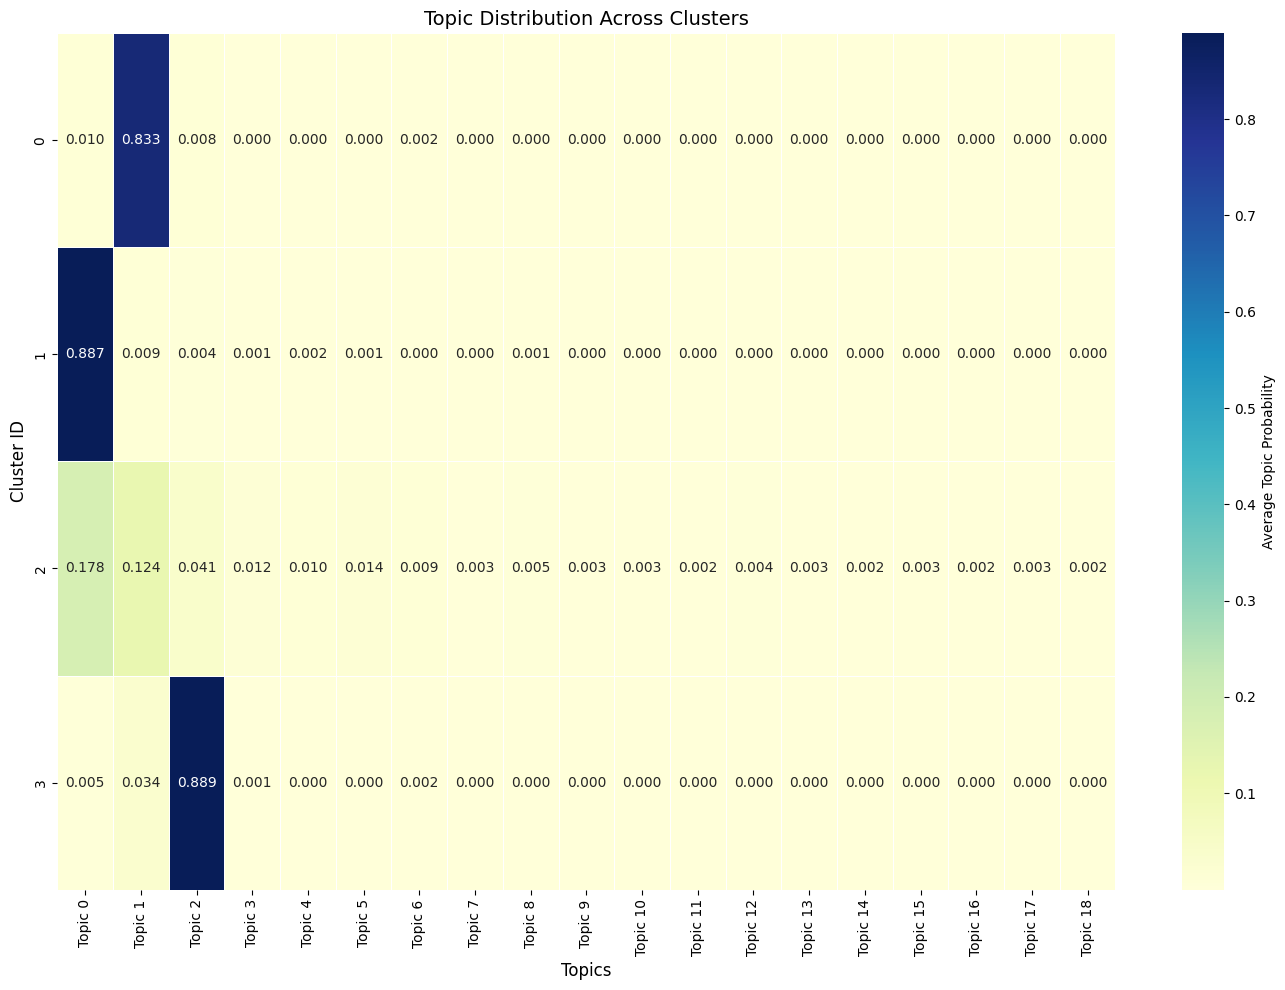

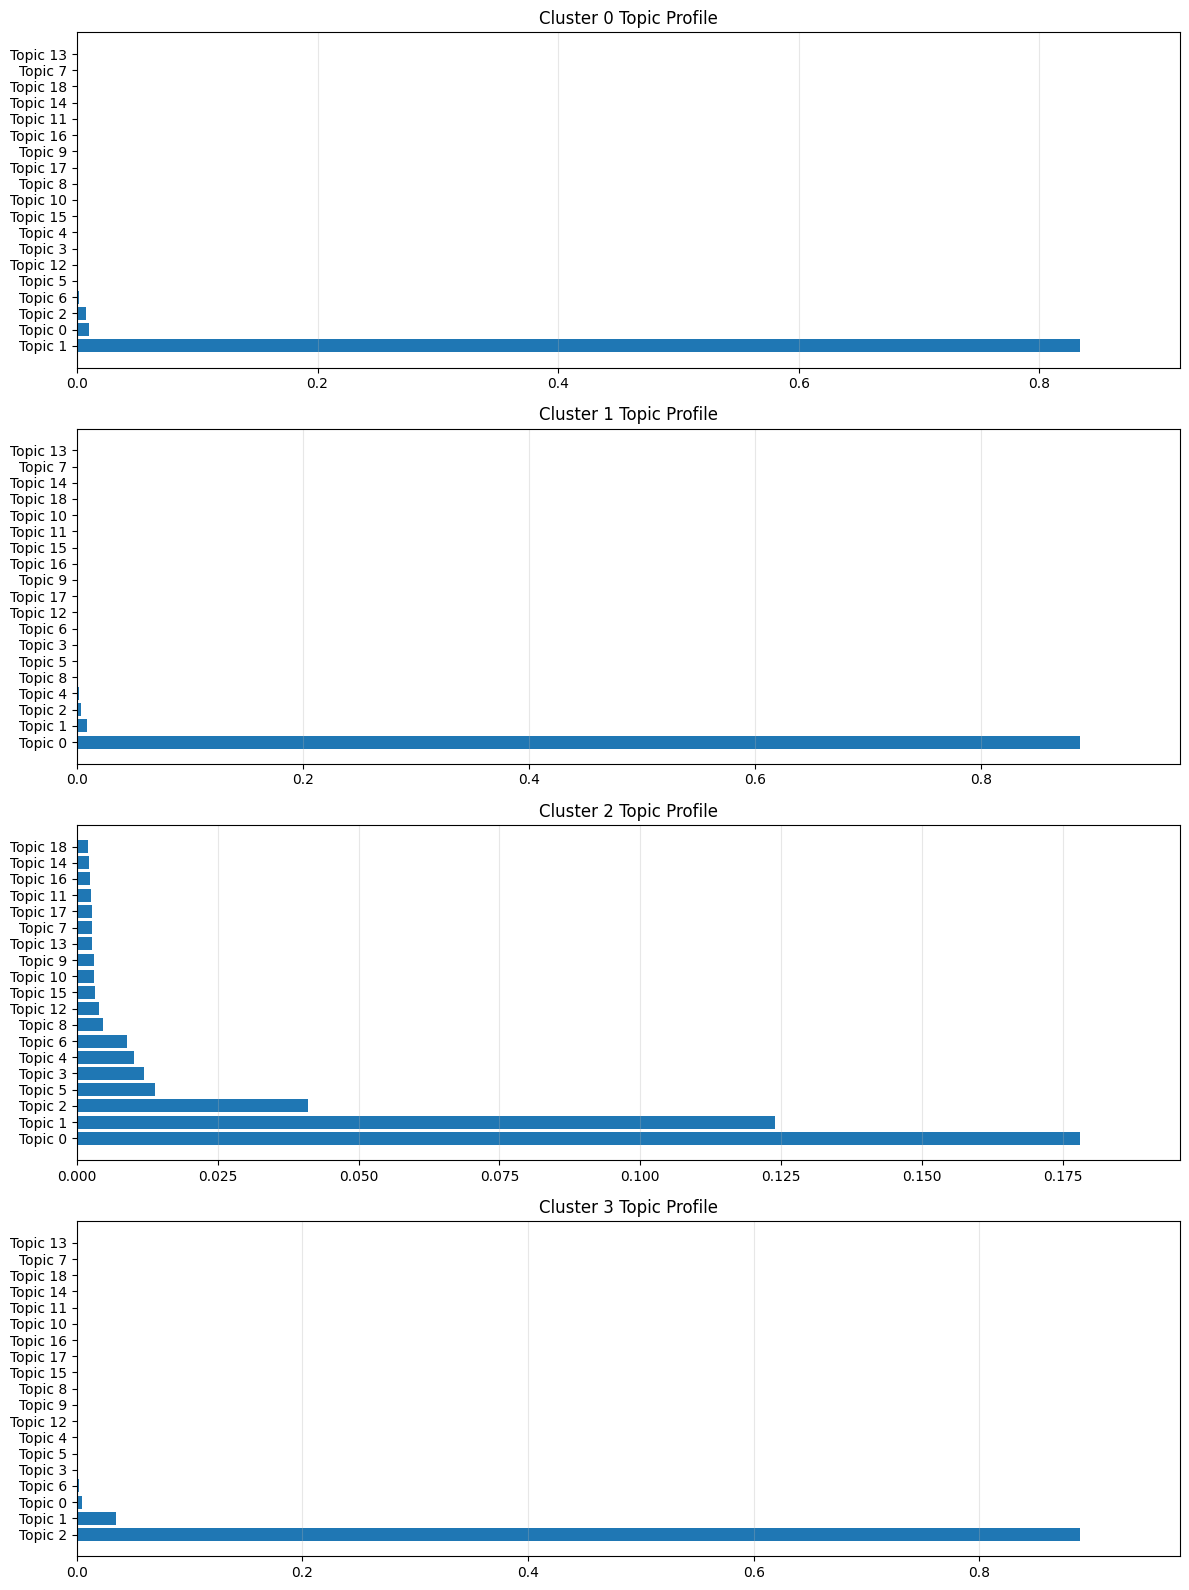

In [ ]:
visualize_cluster_topic_profiles(df_with_clusters, 4)

#### Radar Chart (Topic Distribution Comparision)

In [ ]:
def create_radar_chart(df_with_clusters, n_clusters):
    """
    Create radar charts to compare topic distributions across clusters
    """
    # Extract topic columns
    topic_cols = [col for col in df_with_clusters.columns if re.match(r'^topic_prob_\d+$', col)]

    # Get top 5 topics overall
    top_topics = df_with_clusters[topic_cols].mean().nlargest(5).index.tolist()

    # Create cluster profiles for these topics
    cluster_profiles = df_with_clusters.groupby('cluster')[top_topics].mean()

    # Radar chart
    angles = np.linspace(0, 2*np.pi, len(top_topics), endpoint=False).tolist()
    angles += angles[:1]  # Close the loop

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    for i in range(n_clusters):
        values = cluster_profiles.iloc[i].values.tolist()
        values += values[:1]  # Close the loop

        ax.plot(angles, values, linewidth=2, label=f'Cluster {i}')
        ax.fill(angles, values, alpha=0.1)

    # Set labels and title
    labels = [f"Topic {t.split('_')[-1]}" for t in top_topics]
    labels += labels[:1]  # Close the loop
    ax.set_xticks(angles)
    ax.set_xticklabels(labels)

    plt.title('Topic Distribution Comparison Across Clusters', fontsize=14)
    plt.legend(loc='upper right')
    plt.show()

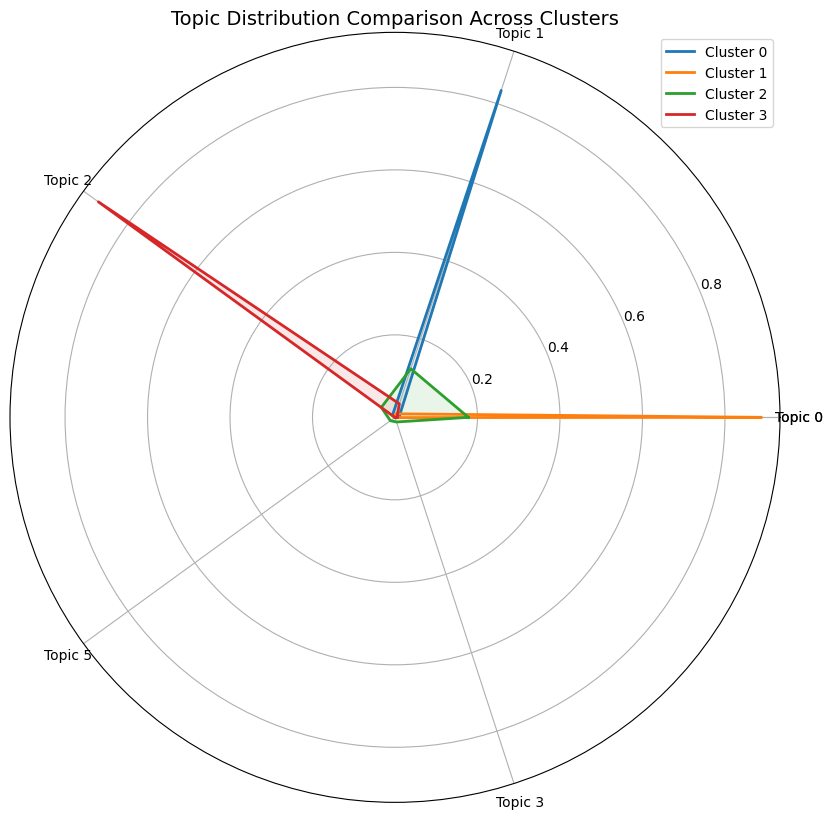

In [ ]:
create_radar_chart(df_with_clusters, 4)

#### Cluster Wordclouds

In [ ]:
def visualize_cluster_wordclouds(df_with_clusters, n_clusters):
    """
    Create word clouds for the most common words in each cluster
    """
    from wordcloud import WordCloud

    # Check if text column exists
    if 'text' not in df_with_clusters.columns:
        print("No text data available for word clouds")
        return

    # Create a figure with subplots
    fig, axes = plt.subplots(n_clusters, 1, figsize=(12, n_clusters * 10))

    for i in range(n_clusters):
        # Get text from this cluster
        cluster_text = ' '.join(df_with_clusters[df_with_clusters['cluster'] == i]['text'])

        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400,
                             background_color='white',
                             max_words=100,
                             contour_width=3).generate(cluster_text)

        # Plot
        ax = axes[i] if n_clusters > 1 else axes
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'Cluster {i} Word Cloud', fontsize=14)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
visualize_cluster_wordclouds(df_with_clusters, 4)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from collections import Counter
from nltk.corpus import stopwords
import nltk

# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')

def print_cluster_words(df_with_clusters, n_clusters, top_n=10):
    """
    Print the most common words in each cluster, excluding stopwords
    """
    # Check if text column exists
    if 'text' not in df_with_clusters.columns:
        print("No text data available for word clouds")
        return

    # Get the set of stopwords
    stop_words = set(stopwords.words('english'))

    for i in range(n_clusters):
        # Get text from this cluster
        cluster_text = ' '.join(df_with_clusters[df_with_clusters['cluster'] == i]['text'])

        # Split text into words, filter out stopwords, and count their frequencies
        words = [word for word in cluster_text.split() if word.lower() not in stop_words]
        word_counts = Counter(words)

        # Get the top N most common words
        top_words = word_counts.most_common(top_n)

        # Print the top words for this cluster
        print(f"Cluster {i} Top {top_n} Words:")
        for word, count in top_words:
            print(f"  {word}: {count}")
        print("\n")  # Add a newline for readability

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
print_cluster_words(df_with_clusters, 4, top_n=50)

Cluster 0 Top 50 Words:
  China: 579
  people: 331
  like: 311
  Chinese: 305
  US: 287
  censorship: 249
  post: 230
  think: 191
  country: 189
  data: 174
  would: 173
  know: 171
  even: 170
  one: 170
  government: 169
  world: 167
  removed: 161
  get: 156
  use: 147
  posts: 133
  discussions: 122
  time: 116
  china: 115
  much: 113
  want: 110
  3: 109
  must: 108
  thing: 107
  good: 105
  allowed: 104
  related: 102
  topic: 102
  right: 101
  posted: 101
  discussion: 101
  see: 99
  Censorship: 99
  spam: 99
  America: 97
  prevent: 97
  way: 94
  American: 94
  still: 93
  maintain: 93
  make: 92
  say: 92
  constructive: 92
  also: 91
  violating: 91
  USA: 90


Cluster 1 Top 50 Words:
  DeepSeek: 1079
  deepseek: 862
  use: 765
  model: 720
  like: 640
  Deepseek: 547
  get: 467
  ChatGPT: 447
  using: 446
  free: 369
  would: 365
  think: 360
  run: 359
  one: 355
  server: 343
  people: 341
  even: 338
  time: 335
  models: 327
  chat: 314
  AI: 308
  better: 305
  op

In [ ]:
labels = ['China-Censorhip-Government', 'DeepSeek-AI-TechnicalUsage', 'Usage-Comparison-Perception', 'AI-UserInteraction-Prompts']

### Characterizing Clusters

In [ ]:
def create_cluster_profiles(documents_df, labels, topic_info_df):
    """
    Create detailed profiles for each cluster based on topic distribution

    Parameters:
    documents_df - DataFrame with document data
    labels - Cluster labels from K-means
    topic_info_df - DataFrame with topic ID to theme name mapping

    Returns:
    DataFrame with detailed cluster profiles including theme names
    """
    # Add cluster labels to the documents dataframe if not already present
    if 'cluster' not in documents_df.columns:
        documents_df = documents_df.copy()
        documents_df['cluster'] = labels

    # Get topic probability columns
    topic_cols = [col for col in documents_df.columns if col.startswith('topic_prob_')]

    # Create profiles for each cluster
    cluster_profiles = []

    for cluster_id in np.unique(documents_df['cluster']):
        if cluster_id == -1:
            # Skip noise points (if using DBSCAN or similar)
            continue

        # Get documents in this cluster
        cluster_docs = documents_df[documents_df['cluster'] == cluster_id]

        # Calculate average topic probabilities for this cluster
        avg_topic_probs = cluster_docs[topic_cols].mean().sort_values(ascending=False)

        # Get top topics
        top_topics = avg_topic_probs.head(5)

        # Map topic IDs to theme names
        top_topic_details = []
        for col in top_topics.index:
            topic_id = int(col.split('_')[-1])  # Extract topic ID from column name
            if topic_id in topic_info_df['Topic'].values:
                theme = topic_info_df.loc[topic_info_df['Topic'] == topic_id, 'Theme'].iloc[0]
                top_topic_details.append({
                    'topic_id': topic_id,
                    'theme': theme,
                    'probability': top_topics[col]
                })
            else:
                top_topic_details.append({
                    'topic_id': topic_id,
                    'theme': f"Topic {topic_id}",  # Fallback if theme not found
                    'probability': top_topics[col]
                })

        # Get emotion data if available
        emotion_distribution = None
        if 'emotions_txt' in cluster_docs.columns:
            emotion_distribution = cluster_docs['emotions_txt'].value_counts(normalize=True).to_dict()

        # Get sentiment data if available
        sentiment_distribution = None
        if 'sentiment_category' in cluster_docs.columns:
            sentiment_distribution = cluster_docs['sentiment_category'].value_counts(normalize=True).to_dict()

        # Create comprehensive cluster profile
        cluster_profiles.append({
            'cluster_id': cluster_id,
            'size': len(cluster_docs),
            'percentage': len(cluster_docs) / len(documents_df) * 100,
            'top_topics': top_topic_details,
            'avg_topic_distribution': avg_topic_probs.to_dict(),
            'emotion_distribution': emotion_distribution,
            'sentiment_distribution': sentiment_distribution
        })

    # Create clusters dataframe
    clusters_df = pd.DataFrame(cluster_profiles)

    # Print a summary of the clusters
    print(f"Created profiles for {len(clusters_df)} clusters:")
    for _, row in clusters_df.iterrows():
        top_themes = [f"{t['theme']} ({t['probability']:.2f})" for t in row['top_topics']]
        print(f"Cluster {row['cluster_id']}: {row['size']} documents ({row['percentage']:.1f}%)")
        print(f"  Top themes: {', '.join(top_themes[:3])}")
        print()

    return clusters_df

In [ ]:
deepseek_topic_info = pd.read_csv('/content/drive/My Drive/deepseek_topic_info.csv')

In [ ]:
cluster_df = create_cluster_profiles(df_with_clusters, labels, deepseek_topic_info)

Created profiles for 4 clusters:
Cluster 0: 2539 documents (16.1%)
  Top themes: Content Moderation & Censorship (0.83), Deepseek Technical Discussion (0.01), AI Philosophy & Usage (0.01)

Cluster 1: 5114 documents (32.5%)
  Top themes: Deepseek Technical Discussion (0.89), Content Moderation & Censorship (0.01), AI Philosophy & Usage (0.00)

Cluster 2: 7309 documents (46.4%)
  Top themes: Deepseek Technical Discussion (0.18), Content Moderation & Censorship (0.12), AI Philosophy & Usage (0.04)

Cluster 3: 786 documents (5.0%)
  Top themes: AI Philosophy & Usage (0.89), Content Moderation & Censorship (0.03), Deepseek Technical Discussion (0.00)



In [ ]:
cluster_df.to_csv('deepseek_cluster_profiles.csv', index=False)

### Evaluating Clusters

Data structure:
Index(['Unnamed: 0', 'subreddit', 'author', 'date', 'text', 'type',
       'emotions_txt', 'emotion_labels', 'emotion_prob', 'sentiment_category',
       'topics', 'theme', 'topic_prob_0', 'topic_prob_1', 'topic_prob_2',
       'topic_prob_3', 'topic_prob_4', 'topic_prob_5', 'topic_prob_6',
       'topic_prob_7', 'topic_prob_8', 'topic_prob_9', 'topic_prob_10',
       'topic_prob_11', 'topic_prob_12', 'topic_prob_13', 'topic_prob_14',
       'topic_prob_15', 'topic_prob_16', 'topic_prob_17', 'topic_prob_18',
       'cluster'],
      dtype='object')
Using cluster as cluster label column

Cluster size distribution:
cluster
0    2539
1    5114
2    7309
3     786
Name: count, dtype: int64


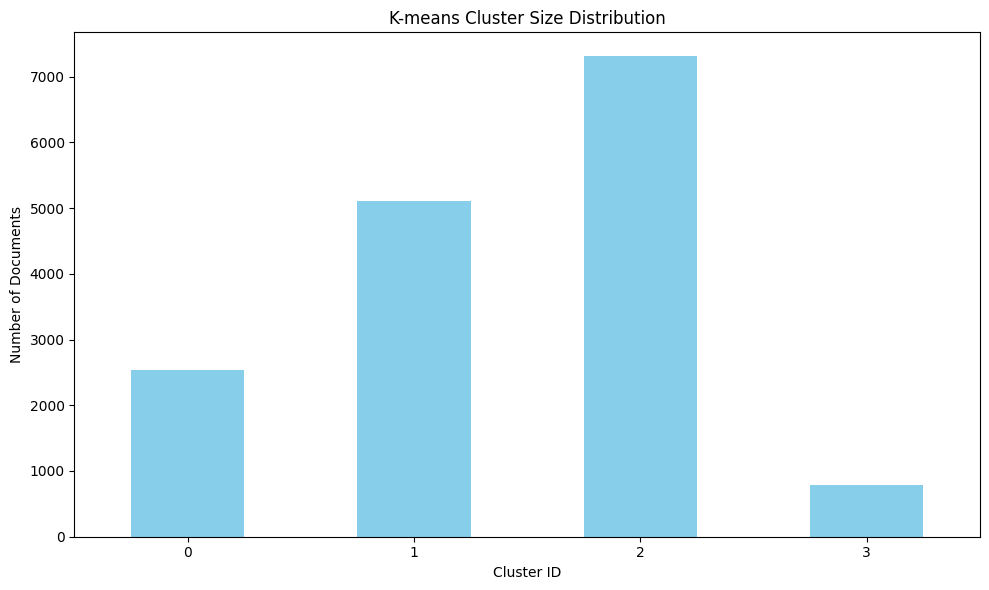


K-means Clustering Evaluation Metrics:
Silhouette Score (higher is better): 0.6343
Davies-Bouldin Index (lower is better): 0.4799
Calinski-Harabasz Index (higher is better): 24024.6066

Topic distribution across clusters:

Cluster 0 (2539 documents):
  Topic 1: 2169 docs (85.4%)
  Topic 0: 108 docs (4.3%)
  Topic 2: 49 docs (1.9%)

Cluster 1 (5114 documents):
  Topic 0: 4781 docs (93.5%)
  Topic 1: 69 docs (1.3%)
  Topic 2: 43 docs (0.8%)

Cluster 2 (7309 documents):
  Topic 0: 3052 docs (41.8%)
  Topic 1: 1467 docs (20.1%)
  Topic 2: 792 docs (10.8%)

Cluster 3 (786 documents):
  Topic 2: 717 docs (91.2%)
  Topic 6: 15 docs (1.9%)
  Topic 5: 14 docs (1.8%)

Emotion distribution across clusters:

Cluster 0 (2539 documents):
  neutral: 1443 docs (56.8%)
  annoyance: 169 docs (6.7%)
  amusement: 157 docs (6.2%)

Cluster 1 (5114 documents):
  neutral: 3160 docs (61.8%)
  approval: 258 docs (5.0%)
  amusement: 215 docs (4.2%)

Cluster 2 (7309 documents):
  neutral: 4406 docs (60.3%)
  app

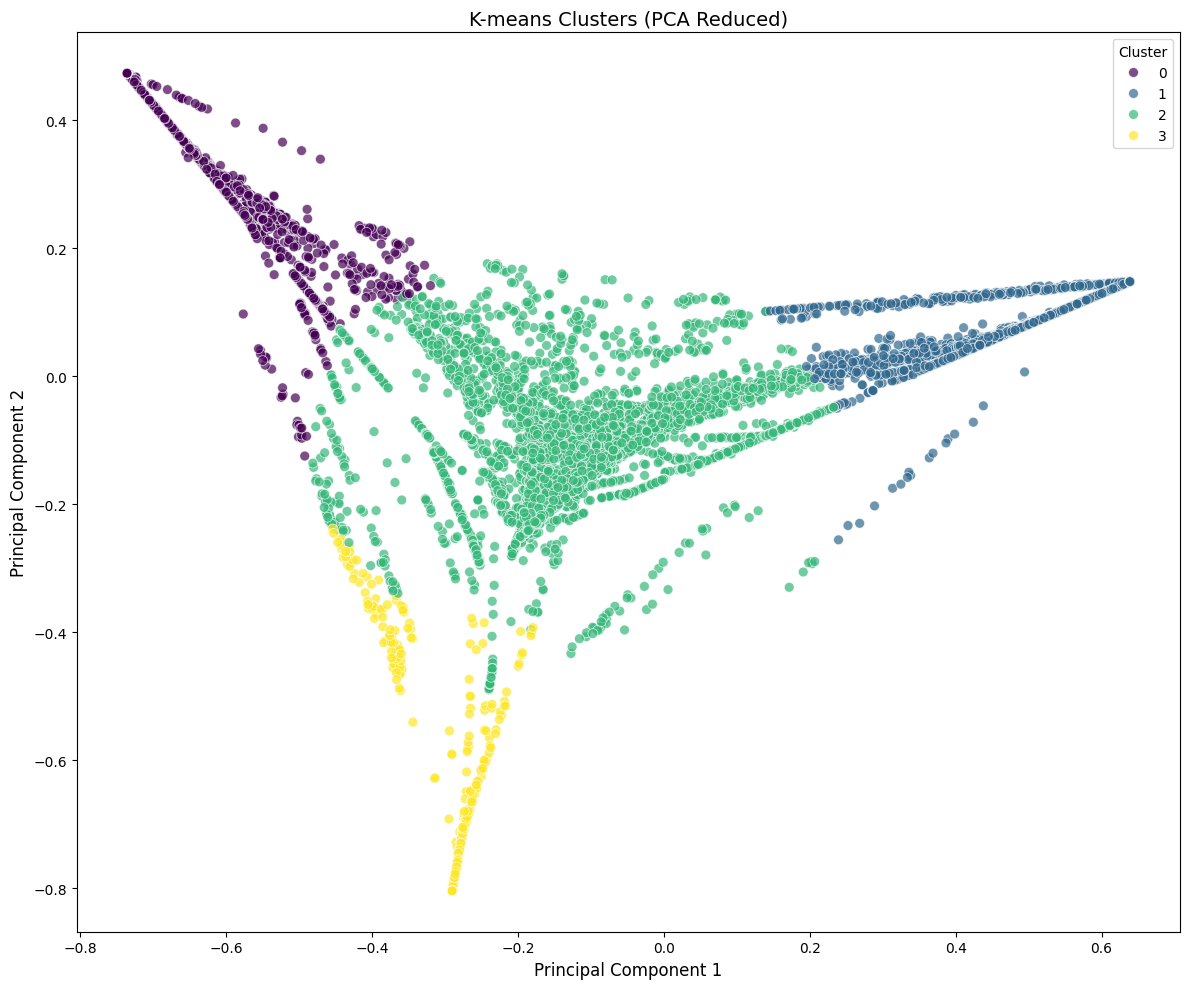

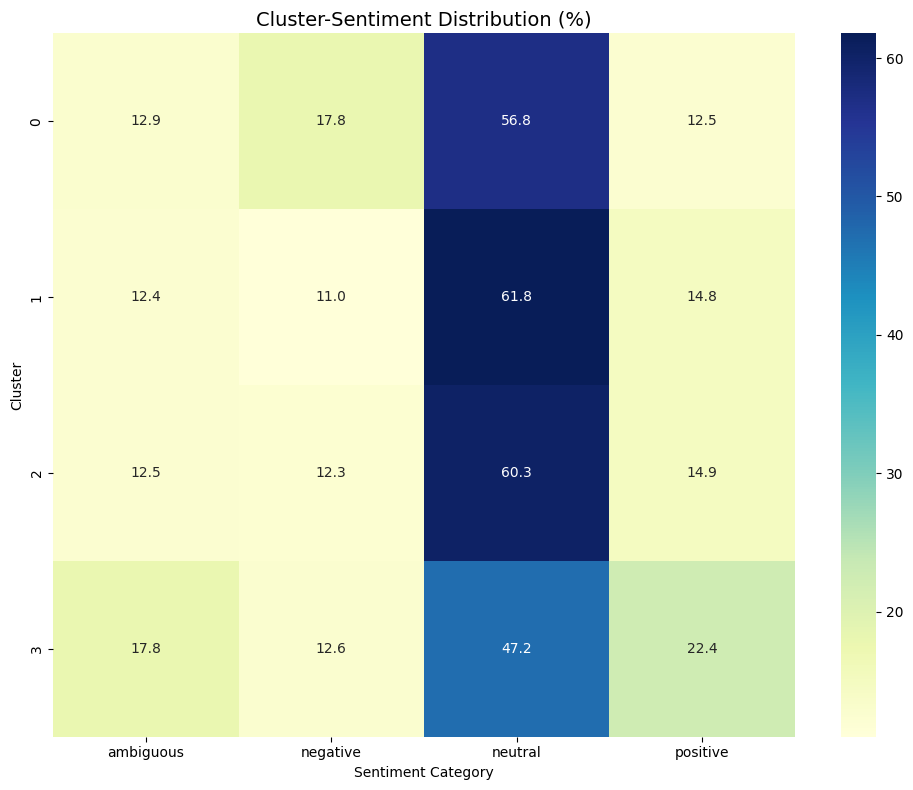

Cluster  Size  Percentage  Silhouette_Score  Davies_Bouldin  \
0        0  2539   16.122682          0.634332        0.479897   
1        1  5114   32.473965          0.634332        0.479897   
2        2  7309   46.412243          0.634332        0.479897   
3        3   786    4.991110          0.634332        0.479897   

   Calinski_Harabasz  
0       24024.606591  
1       24024.606591  
2       24024.606591  
3       24024.606591

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA

# Assuming df_with_clusters contains your data with clustering results
# First check the data structure
print("Data structure:")
print(df_with_clusters.columns)

# Confirm clustering column exists
if 'kmeans_cluster' in df_with_clusters.columns:
    cluster_col = 'kmeans_cluster'
else:
    # Check for other potential cluster column names
    potential_cluster_cols = [col for col in df_with_clusters.columns if 'cluster' in col.lower()]
    if potential_cluster_cols:
        cluster_col = potential_cluster_cols[0]
        print(f"Using {cluster_col} as cluster label column")
    else:
        raise ValueError("Could not find cluster label column")

# 1. Basic cluster statistics
cluster_counts = df_with_clusters[cluster_col].value_counts().sort_index()
print("\nCluster size distribution:")
print(cluster_counts)

# Visualize cluster sizes
plt.figure(figsize=(10, 6))
cluster_counts.plot(kind='bar', color='skyblue')
plt.title('K-means Cluster Size Distribution')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Documents')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('kmeans_cluster_sizes.png')
plt.show()

# 2. Internal evaluation metrics
# First extract feature columns (those used for clustering)
# If there are topic_prob columns, use them
topic_prob_cols = [col for col in df_with_clusters.columns if 'topic_prob_' in col]
if topic_prob_cols:
    features = df_with_clusters[topic_prob_cols].values
else:
    # If no clear feature columns, try to find or report error
    print("Warning: Could not find topic_prob columns, cannot calculate internal evaluation metrics")

if 'features' in locals():
    # Calculate internal evaluation metrics
    labels = df_with_clusters[cluster_col].values

    try:
        sil_score = silhouette_score(features, labels)
        db_score = davies_bouldin_score(features, labels)
        ch_score = calinski_harabasz_score(features, labels)

        print("\nK-means Clustering Evaluation Metrics:")
        print(f"Silhouette Score (higher is better): {sil_score:.4f}")
        print(f"Davies-Bouldin Index (lower is better): {db_score:.4f}")
        print(f"Calinski-Harabasz Index (higher is better): {ch_score:.4f}")
    except Exception as e:
        print(f"Error calculating evaluation metrics: {e}")

# 3. Cluster content analysis
# Analyze topic and emotion distribution within each cluster
if 'topics' in df_with_clusters.columns:
    print("\nTopic distribution across clusters:")
    for cluster in sorted(df_with_clusters[cluster_col].unique()):
        cluster_df = df_with_clusters[df_with_clusters[cluster_col] == cluster]
        top_topics = cluster_df['topics'].value_counts().head(3)

        print(f"\nCluster {cluster} ({len(cluster_df)} documents):")
        for topic, count in top_topics.items():
            print(f"  Topic {topic}: {count} docs ({count/len(cluster_df)*100:.1f}%)")

if 'emotion_labels' in df_with_clusters.columns:
    print("\nEmotion distribution across clusters:")
    for cluster in sorted(df_with_clusters[cluster_col].unique()):
        cluster_df = df_with_clusters[df_with_clusters[cluster_col] == cluster]
        emotion_counts = cluster_df['emotion_labels'].value_counts().head(3)

        print(f"\nCluster {cluster} ({len(cluster_df)} documents):")
        for emotion, count in emotion_counts.items():
            print(f"  {emotion}: {count} docs ({count/len(cluster_df)*100:.1f}%)")

# 4. Visualize clusters (using PCA dimensionality reduction)
if 'features' in locals():
    # Apply PCA to reduce to 2D
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features)

    # Create visualization DataFrame
    viz_df = pd.DataFrame({
        'PC1': features_pca[:, 0],
        'PC2': features_pca[:, 1],
        'Cluster': df_with_clusters[cluster_col]
    })

    # Plot clusters
    plt.figure(figsize=(12, 10))
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=viz_df, palette='viridis', s=50, alpha=0.7)
    plt.title('K-means Clusters (PCA Reduced)', fontsize=14)
    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)

    # Add cluster centers (if available)
    if 'kmeans_model' in globals() and hasattr(kmeans_model, 'cluster_centers_'):
        centers_pca = pca.transform(kmeans_model.cluster_centers_)
        plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=200, alpha=0.75, marker='X')

    plt.tight_layout()
    plt.savefig('kmeans_clusters_pca.png')
    plt.show()

# 5. Analyze relationship between clusters and sentiment
if 'sentiment_category' in df_with_clusters.columns:
    # Create cluster-sentiment cross tabulation
    sentiment_cross = pd.crosstab(
        df_with_clusters[cluster_col],
        df_with_clusters['sentiment_category'],
        normalize='index'
    ) * 100

    plt.figure(figsize=(10, 8))
    sns.heatmap(sentiment_cross, annot=True, cmap='YlGnBu', fmt='.1f')
    plt.title('Cluster-Sentiment Distribution (%)', fontsize=14)
    plt.xlabel('Sentiment Category')
    plt.ylabel('Cluster')
    plt.tight_layout()
    plt.savefig('kmeans_sentiment_heatmap.png')
    plt.show()

# Save evaluation results
evaluation_results = pd.DataFrame({
    'Cluster': sorted(df_with_clusters[cluster_col].unique()),
    'Size': [sum(df_with_clusters[cluster_col] == c) for c in sorted(df_with_clusters[cluster_col].unique())],
    'Percentage': [sum(df_with_clusters[cluster_col] == c) / len(df_with_clusters) * 100
                  for c in sorted(df_with_clusters[cluster_col].unique())]
})

if 'features' in locals() and 'sil_score' in locals():
    # Add evaluation metrics
    evaluation_results = evaluation_results.assign(
        Silhouette_Score=sil_score,
        Davies_Bouldin=db_score,
        Calinski_Harabasz=ch_score
    )

# Save evaluation results
# evaluation_results.to_csv('kmeans_evaluation.csv', index=False)
# print("\nEvaluation results saved to 'kmeans_evaluation.csv'")
evaluation_results

## r/DeepSeek Clustering (Hierarchical Clustering)

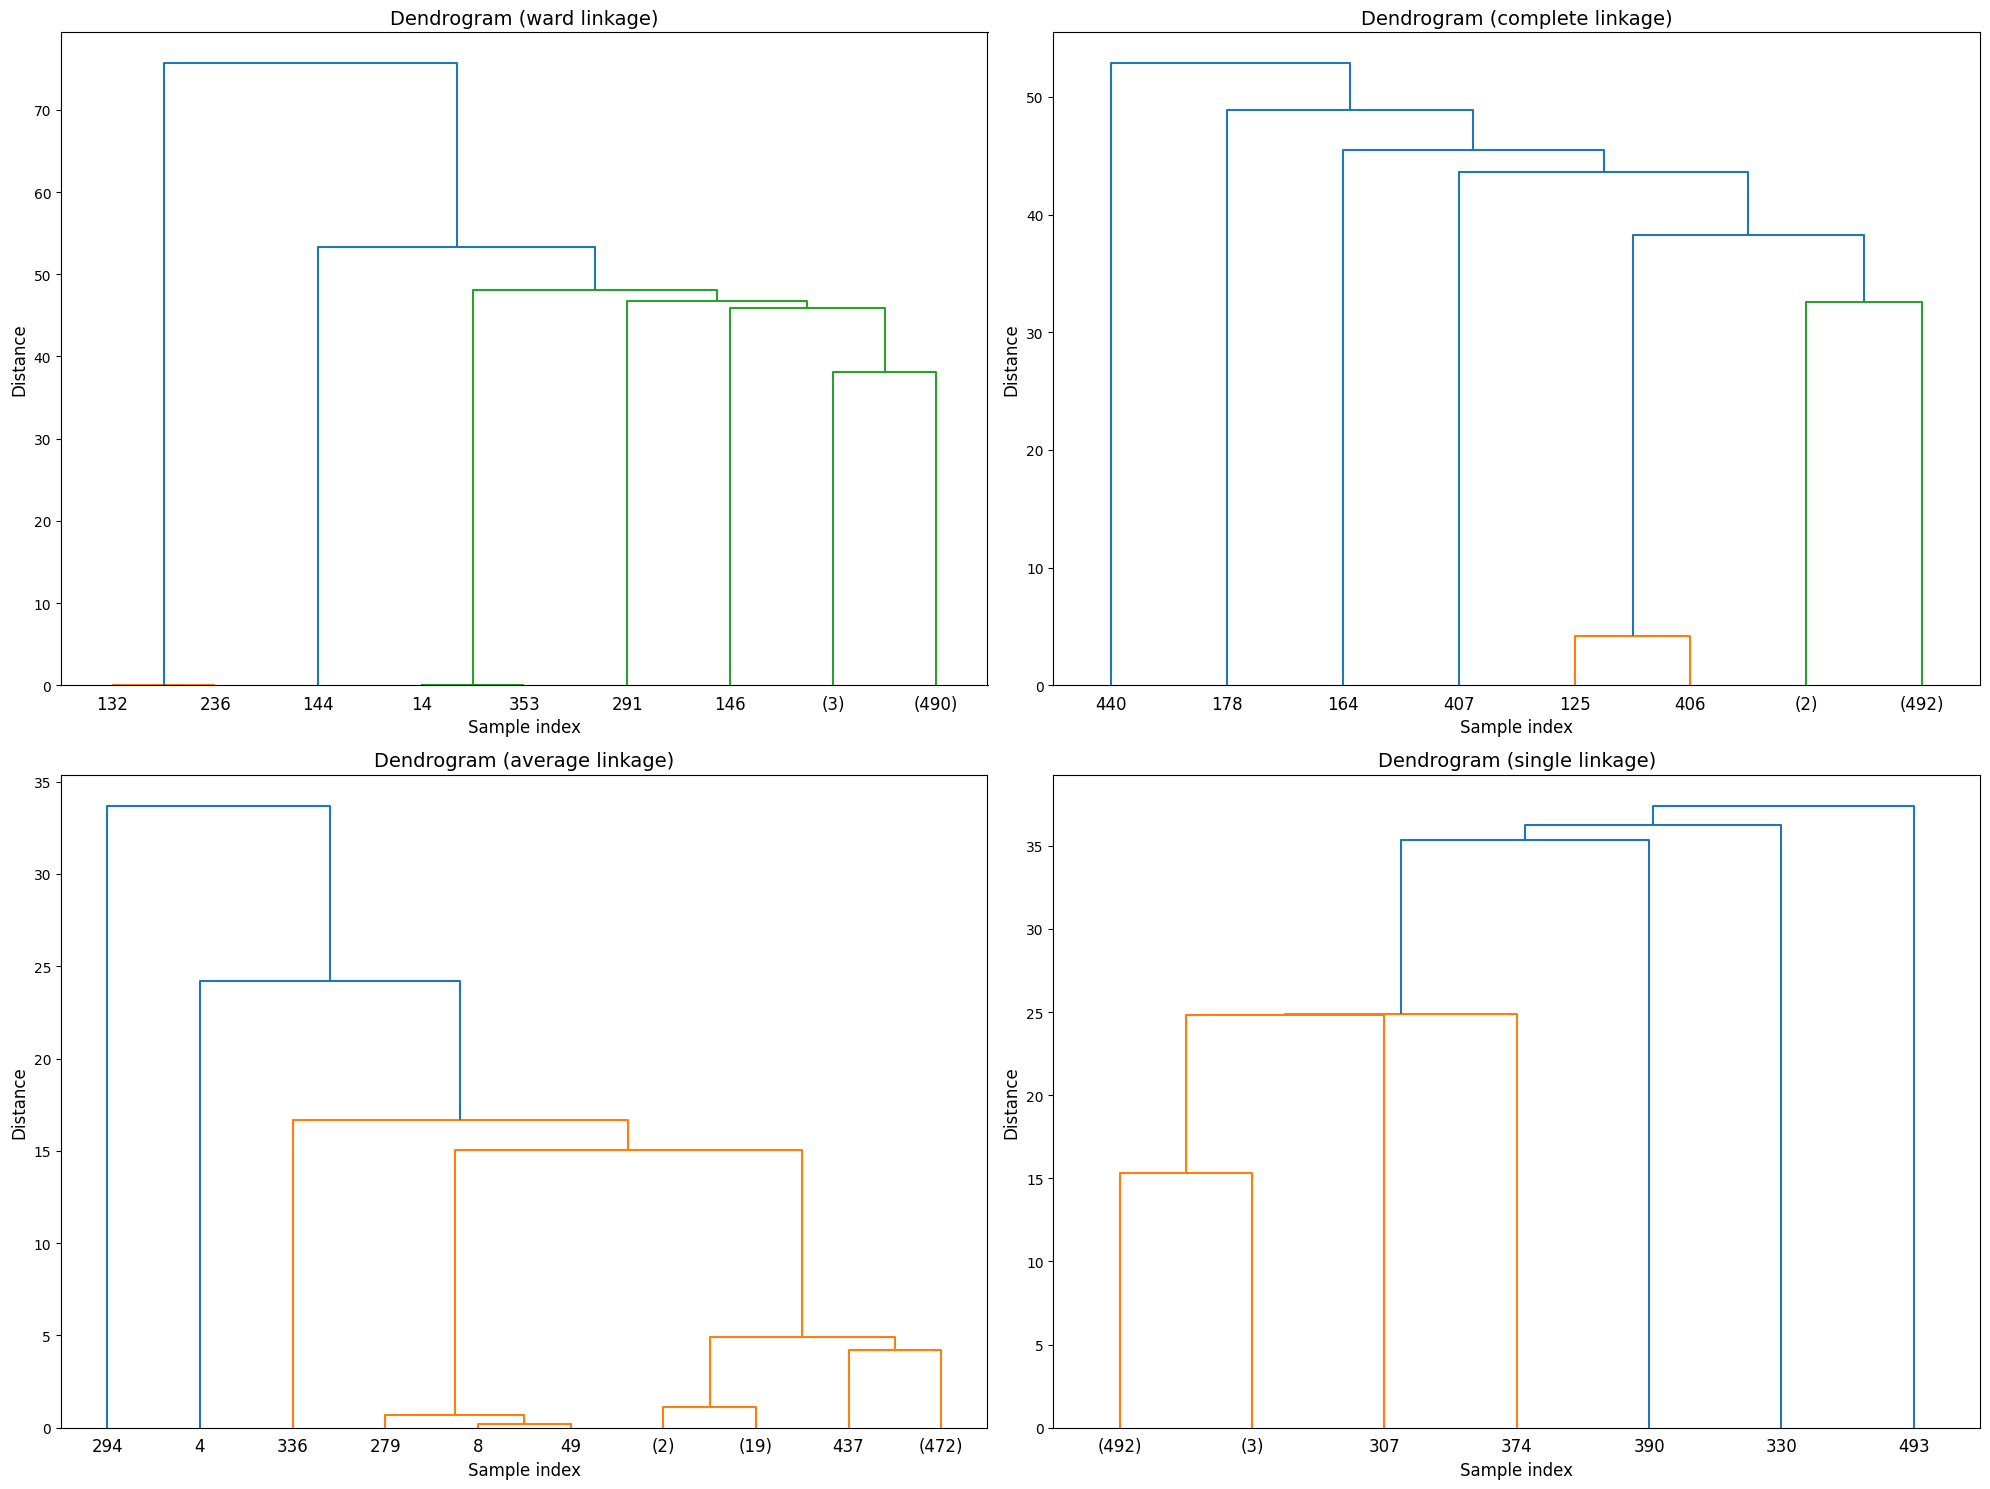

Method: ward, Clusters: 2, Silhouette Score: 0.2209
Method: ward, Clusters: 3, Silhouette Score: 0.2289
Method: ward, Clusters: 4, Silhouette Score: 0.2370
Method: ward, Clusters: 5, Silhouette Score: 0.2453
Method: ward, Clusters: 6, Silhouette Score: 0.2541
Method: ward, Clusters: 7, Silhouette Score: 0.2625
Method: ward, Clusters: 8, Silhouette Score: 0.2740
Method: ward, Clusters: 9, Silhouette Score: 0.2853
Method: ward, Clusters: 10, Silhouette Score: 0.2954
Method: complete, Clusters: 2, Silhouette Score: 0.9199
Method: complete, Clusters: 3, Silhouette Score: 0.9211
Method: complete, Clusters: 4, Silhouette Score: 0.9222
Method: complete, Clusters: 5, Silhouette Score: 0.9232
Method: complete, Clusters: 6, Silhouette Score: 0.9213
Method: complete, Clusters: 7, Silhouette Score: 0.9177
Method: complete, Clusters: 8, Silhouette Score: 0.9187
Method: complete, Clusters: 9, Silhouette Score: 0.9150
Method: complete, Clusters: 10, Silhouette Score: 0.9101
Method: average, Clusters:

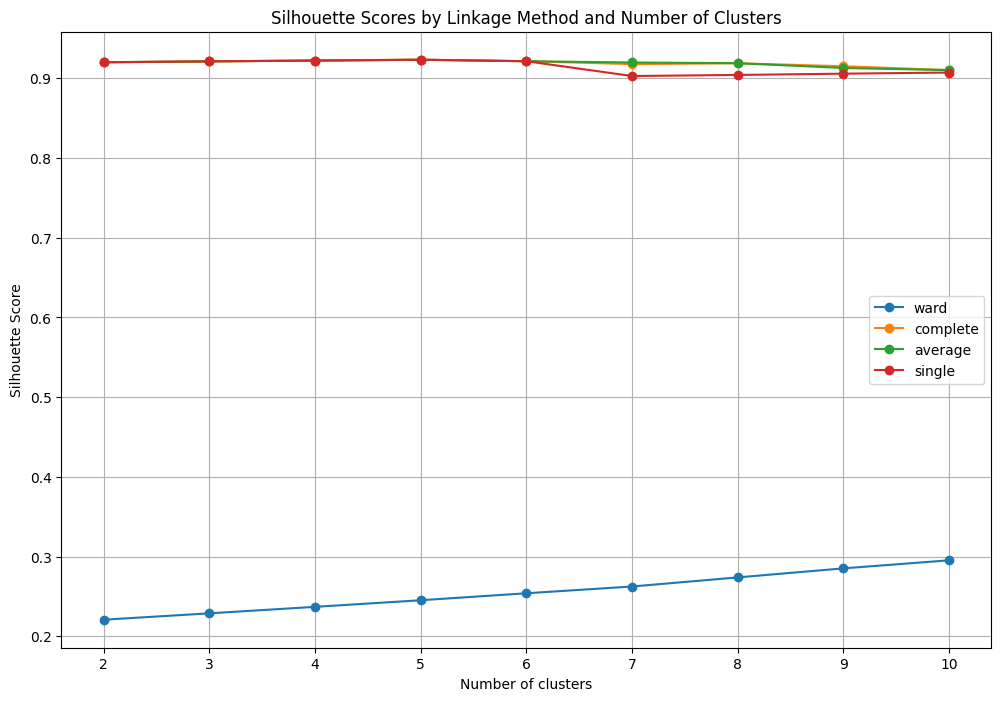

Best linkage method: complete
Best number of clusters: 5


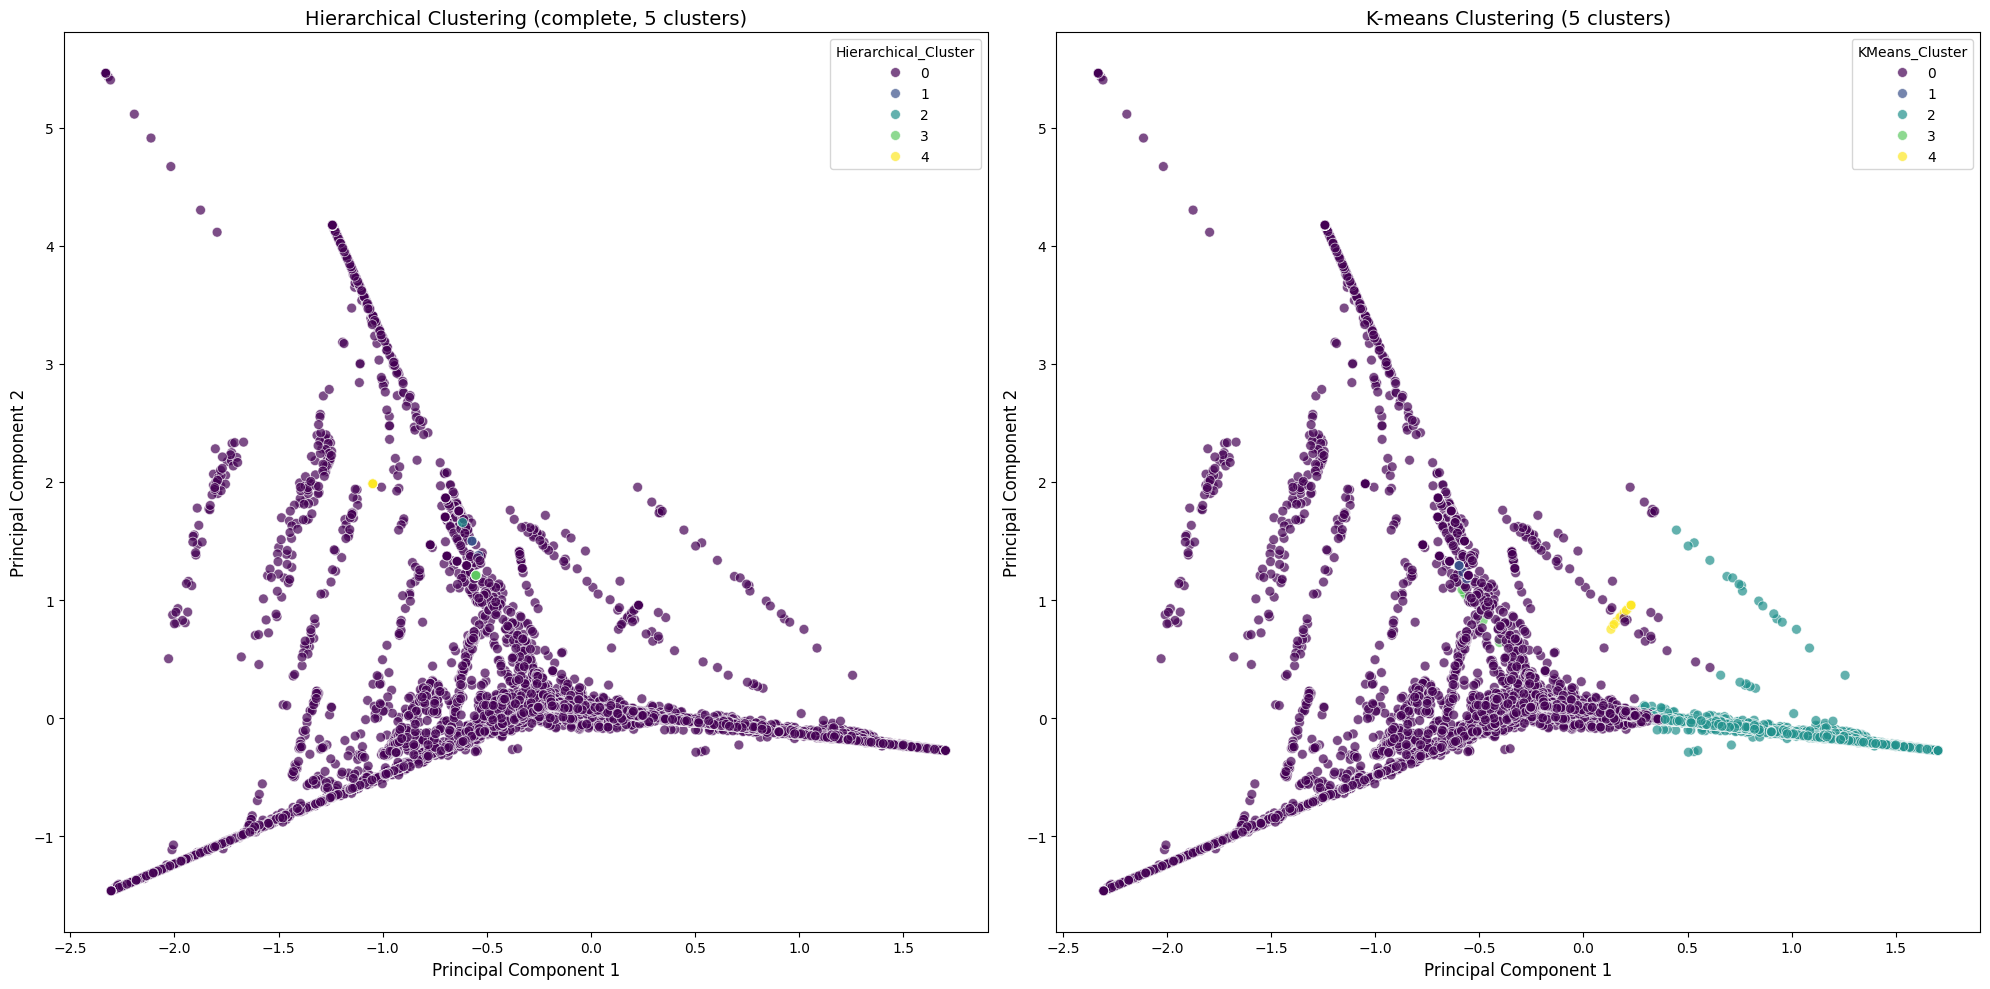

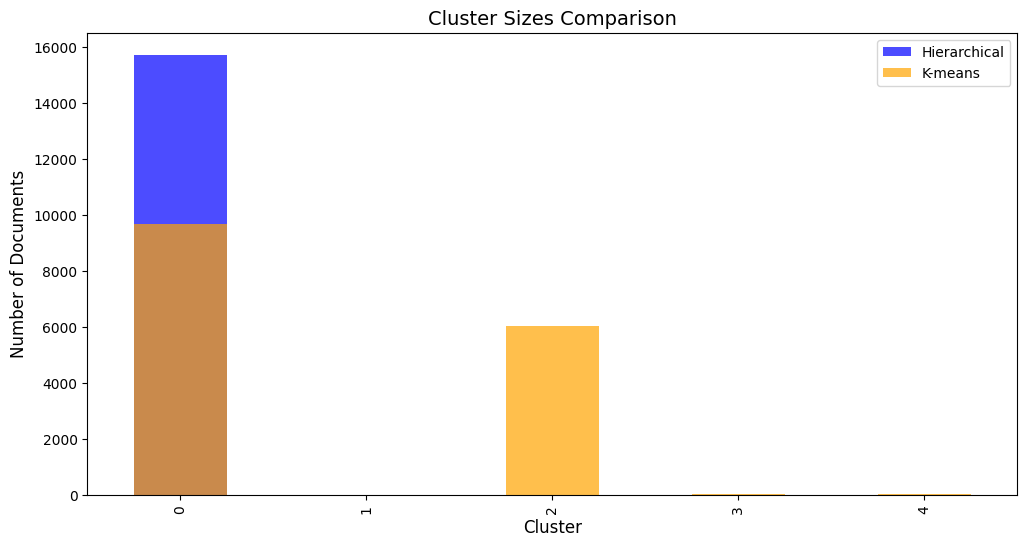


Hierarchical Clustering Analysis:
   Cluster   Size  Percentage                                      Top Topics  \
0        0  15704   99.720599  Topic 0 (7955), Topic 1 (3710), Topic 2 (1601)   
1        1     11    0.069850                                   Topic 16 (11)   
2        2     11    0.069850                                   Topic 17 (11)   
3        3     11    0.069850                                   Topic 18 (11)   
4        4     11    0.069850                                   Topic 12 (11)   

                                      Top Emotions  \
0  neutral (9349), approval (848), amusement (769)   
1   neutral (7), confusion (1), disappointment (1)   
2      neutral (6), disapproval (2), gratitude (1)   
3                        neutral (10), remorse (1)   
4            neutral (8), amusement (1), anger (1)   

                            Sentiment  
0  Pos: 14.9%, Neg: 12.8%, Amb: 12.8%  
1    Pos: 9.1%, Neg: 18.2%, Amb: 9.1%  
2   Pos: 18.2%, Neg: 18.2%, Amb: 

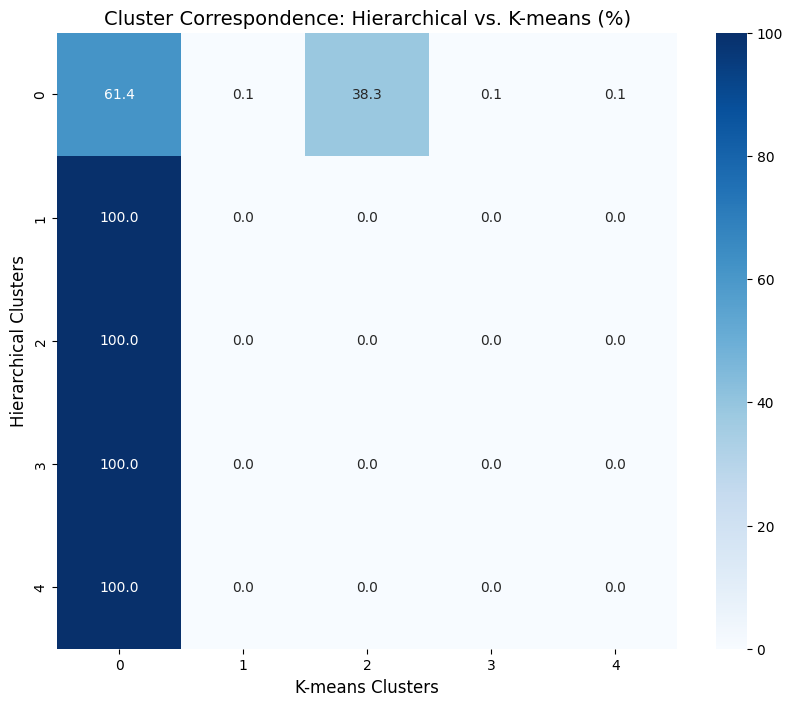

Clustering analysis complete. Results saved to CSV files.


In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, silhouette_samples
import seaborn as sns

# Load your data
df = pd.read_csv('/content/drive/MyDrive/training_for_cluster_deepseek.csv')

# Extract topic probabilities to use as features for clustering
topic_prob_cols = [col for col in df.columns if col.startswith('topic_prob_')]
X = df[topic_prob_cols].values

# Standardize features for better clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1. Compare different linkage methods for hierarchical clustering
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix from model
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the dendrogram
    dendrogram(linkage_matrix, **kwargs)

# We'll test different linkage methods
linkage_methods = ['ward', 'complete', 'average', 'single']
silhouette_scores_by_method = {}

plt.figure(figsize=(20, 15))
for i, method in enumerate(linkage_methods):
    # Sample a subset of data for visualization (dendrograms can be cluttered with too many points)
    if len(X_scaled) > 500:
        sample_indices = np.random.choice(len(X_scaled), 500, replace=False)
        X_sample = X_scaled[sample_indices]
    else:
        X_sample = X_scaled
        sample_indices = np.arange(len(X_scaled))

    # Create AgglomerativeClustering model with 4 clusters as default
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=method)
    model = model.fit(X_sample)

    # Plot dendrogram
    plt.subplot(2, 2, i+1)
    plt.title(f'Dendrogram ({method} linkage)', fontsize=14)
    plot_dendrogram(model, truncate_mode='level', p=5)
    plt.xlabel('Sample index', fontsize=12)
    plt.ylabel('Distance', fontsize=12)

plt.tight_layout()
plt.savefig('hierarchical_dendrograms.png')
plt.show()

# 2. Determine optimal number of clusters for each linkage method
max_clusters = 10
silhouette_scores = {}

plt.figure(figsize=(12, 8))
for method in linkage_methods:
    scores = []
    for n_clusters in range(2, max_clusters + 1):
        # Create clustering model
        model = AgglomerativeClustering(n_clusters=n_clusters, linkage=method)
        labels = model.fit_predict(X_scaled)

        # Calculate silhouette score
        try:
            score = silhouette_score(X_scaled, labels)
            scores.append(score)
            print(f"Method: {method}, Clusters: {n_clusters}, Silhouette Score: {score:.4f}")
        except:
            scores.append(0)
            print(f"Method: {method}, Clusters: {n_clusters}, Error calculating silhouette")

    silhouette_scores[method] = scores
    plt.plot(range(2, max_clusters + 1), scores, marker='o', label=method)

plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores by Linkage Method and Number of Clusters')
plt.legend()
plt.grid(True)
plt.savefig('hierarchical_silhouette_comparison.png')
plt.show()

# Find best method and number of clusters
best_method = max(silhouette_scores.items(), key=lambda x: max(x[1]))[0]
best_n_clusters = silhouette_scores[best_method].index(max(silhouette_scores[best_method])) + 2
print(f"Best linkage method: {best_method}")
print(f"Best number of clusters: {best_n_clusters}")

# 3. Apply best hierarchical clustering model
final_model = AgglomerativeClustering(n_clusters=best_n_clusters, linkage=best_method)
hierarchical_labels = final_model.fit_predict(X_scaled)

# Add cluster assignments to dataframe
df['hierarchical_cluster'] = hierarchical_labels

# 4. Compare with K-means (if you want to run k-means too)
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=best_n_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)
df['kmeans_cluster'] = kmeans_labels

# 5. Visualize clusters with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create PCA visualization dataframe
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Hierarchical_Cluster': hierarchical_labels,
    'KMeans_Cluster': kmeans_labels
})

# Plot hierarchical clusters
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.scatterplot(x='PC1', y='PC2', hue='Hierarchical_Cluster', data=pca_df, palette='viridis', s=50, alpha=0.7)
plt.title(f'Hierarchical Clustering ({best_method}, {best_n_clusters} clusters)', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)

# Plot k-means clusters
plt.subplot(1, 2, 2)
sns.scatterplot(x='PC1', y='PC2', hue='KMeans_Cluster', data=pca_df, palette='viridis', s=50, alpha=0.7)
plt.title(f'K-means Clustering ({best_n_clusters} clusters)', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)

plt.tight_layout()
plt.savefig('cluster_comparison_pca.png')
plt.show()

# 6. Analyze clusters
# Cluster sizes
hierarchical_sizes = df['hierarchical_cluster'].value_counts().sort_index()
kmeans_sizes = df['kmeans_cluster'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
hierarchical_sizes.plot(kind='bar', color='blue', alpha=0.7, label='Hierarchical')
kmeans_sizes.plot(kind='bar', color='orange', alpha=0.7, label='K-means')
plt.title('Cluster Sizes Comparison', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Number of Documents', fontsize=12)
plt.legend()
plt.savefig('cluster_sizes_comparison.png')
plt.show()

# 7. Compare cluster themes and topics
def analyze_cluster_content(df, cluster_col):
    results = []

    for cluster in sorted(df[cluster_col].unique()):
        cluster_docs = df[df[cluster_col] == cluster]

        # Get top topics
        if 'topics' in df.columns:
            top_topics = cluster_docs['topics'].value_counts().head(3)
            topic_str = ', '.join([f"Topic {t} ({c})" for t, c in top_topics.items()])
        else:
            topic_str = "No topic data"

        # Get top emotions
        if 'emotion_labels' in df.columns:
            top_emotions = cluster_docs['emotion_labels'].value_counts().head(3)
            emotion_str = ', '.join([f"{e} ({c})" for e, c in top_emotions.items()])
        else:
            emotion_str = "No emotion data"

        # Get sentiment distribution
        if 'sentiment_category' in df.columns:
            sentiment_counts = cluster_docs['sentiment_category'].value_counts(normalize=True) * 100
            pos = sentiment_counts.get('positive', 0)
            neg = sentiment_counts.get('negative', 0)
            amb = sentiment_counts.get('ambiguous', 0)
            sentiment_str = f"Pos: {pos:.1f}%, Neg: {neg:.1f}%, Amb: {amb:.1f}%"
        else:
            sentiment_str = "No sentiment data"

        results.append({
            'Cluster': cluster,
            'Size': len(cluster_docs),
            'Percentage': len(cluster_docs) / len(df) * 100,
            'Top Topics': topic_str,
            'Top Emotions': emotion_str,
            'Sentiment': sentiment_str
        })

    return pd.DataFrame(results)

# Analyze hierarchical clusters
hierarchical_analysis = analyze_cluster_content(df, 'hierarchical_cluster')
print("\nHierarchical Clustering Analysis:")
print(hierarchical_analysis)

# Analyze k-means clusters
kmeans_analysis = analyze_cluster_content(df, 'kmeans_cluster')
print("\nK-means Clustering Analysis:")
print(kmeans_analysis)

# 8. Compare cluster agreement
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

ari = adjusted_rand_score(df['hierarchical_cluster'], df['kmeans_cluster'])
ami = adjusted_mutual_info_score(df['hierarchical_cluster'], df['kmeans_cluster'])

print(f"\nCluster Agreement Metrics:")
print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Adjusted Mutual Information: {ami:.4f}")

# 9. Create heatmap showing correspondence between hierarchical and k-means clusters
confusion_matrix = pd.crosstab(df['hierarchical_cluster'], df['kmeans_cluster'],
                              normalize='index') * 100

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='.1f')
plt.title('Cluster Correspondence: Hierarchical vs. K-means (%)', fontsize=14)
plt.xlabel('K-means Clusters', fontsize=12)
plt.ylabel('Hierarchical Clusters', fontsize=12)
plt.savefig('cluster_correspondence.png')
plt.show()

# 10. Save results
df.to_csv('/content/drive/MyDrive/deepseek_with_clusters.csv', index=False)
hierarchical_analysis.to_csv('/content/drive/MyDrive/hierarchical_cluster_analysis.csv', index=False)
kmeans_analysis.to_csv('/content/drive/MyDrive/kmeans_cluster_analysis.csv', index=False)

print("Clustering analysis complete. Results saved to CSV files.")

In [77]:
df = pd.read_csv('/content/drive/MyDrive/deepseek_with_clusters.csv')

##### Visualizting Clusters

In [82]:
df.columns

Index(['Unnamed: 0', 'subreddit', 'author', 'date', 'text', 'type',
       'emotions_txt', 'emotion_labels', 'emotion_prob', 'sentiment_category',
       'topics', 'theme', 'topic_prob_0', 'topic_prob_1', 'topic_prob_2',
       'topic_prob_3', 'topic_prob_4', 'topic_prob_5', 'topic_prob_6',
       'topic_prob_7', 'topic_prob_8', 'topic_prob_9', 'topic_prob_10',
       'topic_prob_11', 'topic_prob_12', 'topic_prob_13', 'topic_prob_14',
       'topic_prob_15', 'topic_prob_16', 'topic_prob_17', 'topic_prob_18',
       'hierarchical_cluster', 'kmeans_cluster'],
      dtype='object')

#### Cluster Size

In [83]:
def visualize_cluster_sizes(df_with_clusters, n_clusters):
    """
    Visualize the distribution of documents across clusters
    """
    # Count documents in each cluster
    cluster_counts = df_with_clusters['hierarchical_cluster'].value_counts().sort_index()

    # Calculate percentages
    total_docs = len(df_with_clusters)
    percentages = (cluster_counts / total_docs * 100).round(1)

    # Create visualization
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(n_clusters), cluster_counts)

    # Add percentage labels on top of each bar
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                f"{percentages[i]}%", ha='center')

    plt.xlabel('Cluster ID', fontsize=12)
    plt.ylabel('Number of Documents', fontsize=12)
    plt.title('Document Distribution Across Clusters', fontsize=14)
    plt.xticks(range(n_clusters))
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

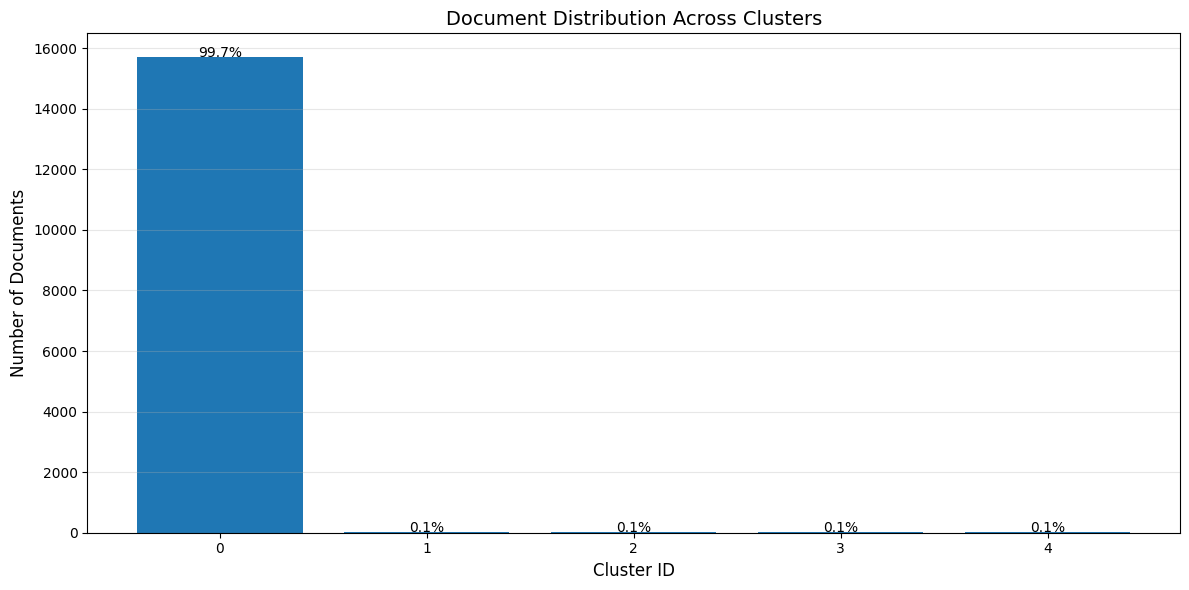

In [84]:
visualize_cluster_sizes(df, 5)

#### Cluster Topic Profile

In [87]:
def visualize_cluster_topic_profiles(df_with_clusters, n_clusters):
    """
    Visualize the topic distribution profiles for each cluster
    """
    # Extract topic columns
    topic_cols = [col for col in df_with_clusters.columns if re.match(r'^topic_prob_\d+$', col)]

    # Create heatmap of topic distributions across clusters
    cluster_topic_means = df_with_clusters.groupby('hierarchical_cluster')[topic_cols].mean()

    # Rename columns to make them more readable
    readable_cols = [f"Topic {col.split('_')[-1]}" for col in topic_cols]
    cluster_topic_means.columns = readable_cols

    plt.figure(figsize=(14, 10))
    ax = sns.heatmap(cluster_topic_means, cmap="YlGnBu", annot=True, fmt=".3f",
                     linewidths=.5, cbar_kws={"label": "Average Topic Probability"})
    plt.title('Topic Distribution Across Clusters', fontsize=14)
    plt.xlabel('Topics', fontsize=12)
    plt.ylabel('Cluster ID', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Create individual topic profile bar charts for each cluster
    fig, axes = plt.subplots(n_clusters, 1, figsize=(12, n_clusters * 4))

    for i in range(n_clusters):
        # Get topic distribution for this cluster
        topic_distribution = cluster_topic_means.iloc[i]
        # Sort by probability for better visualization
        topic_distribution = topic_distribution.sort_values(ascending=False)

        # Plot horizontal bar chart
        ax = axes[i] if n_clusters > 1 else axes
        ax.barh(topic_distribution.index, topic_distribution.values)
        ax.set_title(f'Cluster {i} Topic Profile')
        ax.set_xlim(0, max(topic_distribution.values) * 1.1)
        ax.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

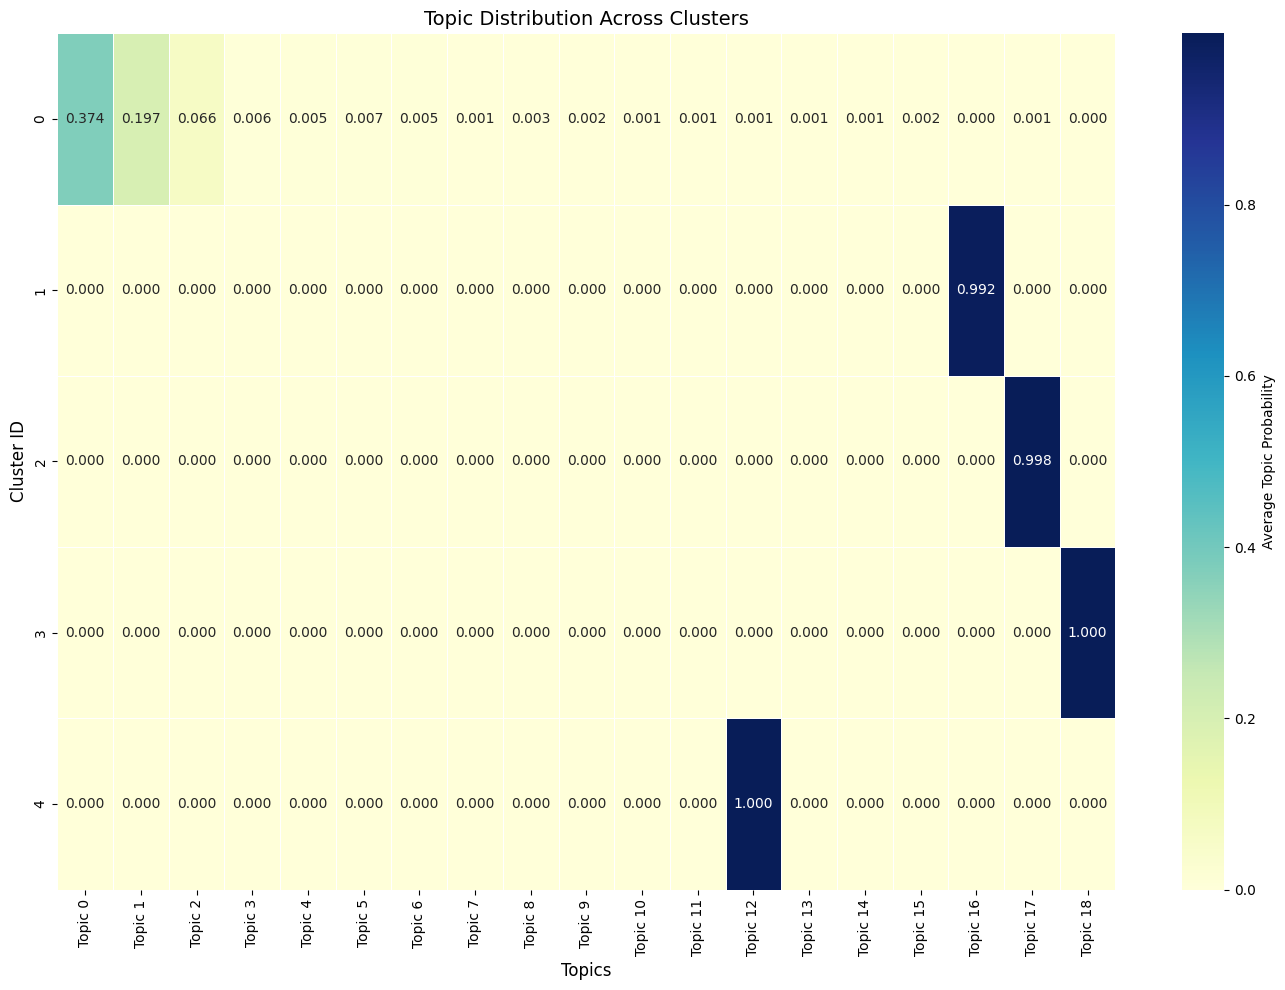

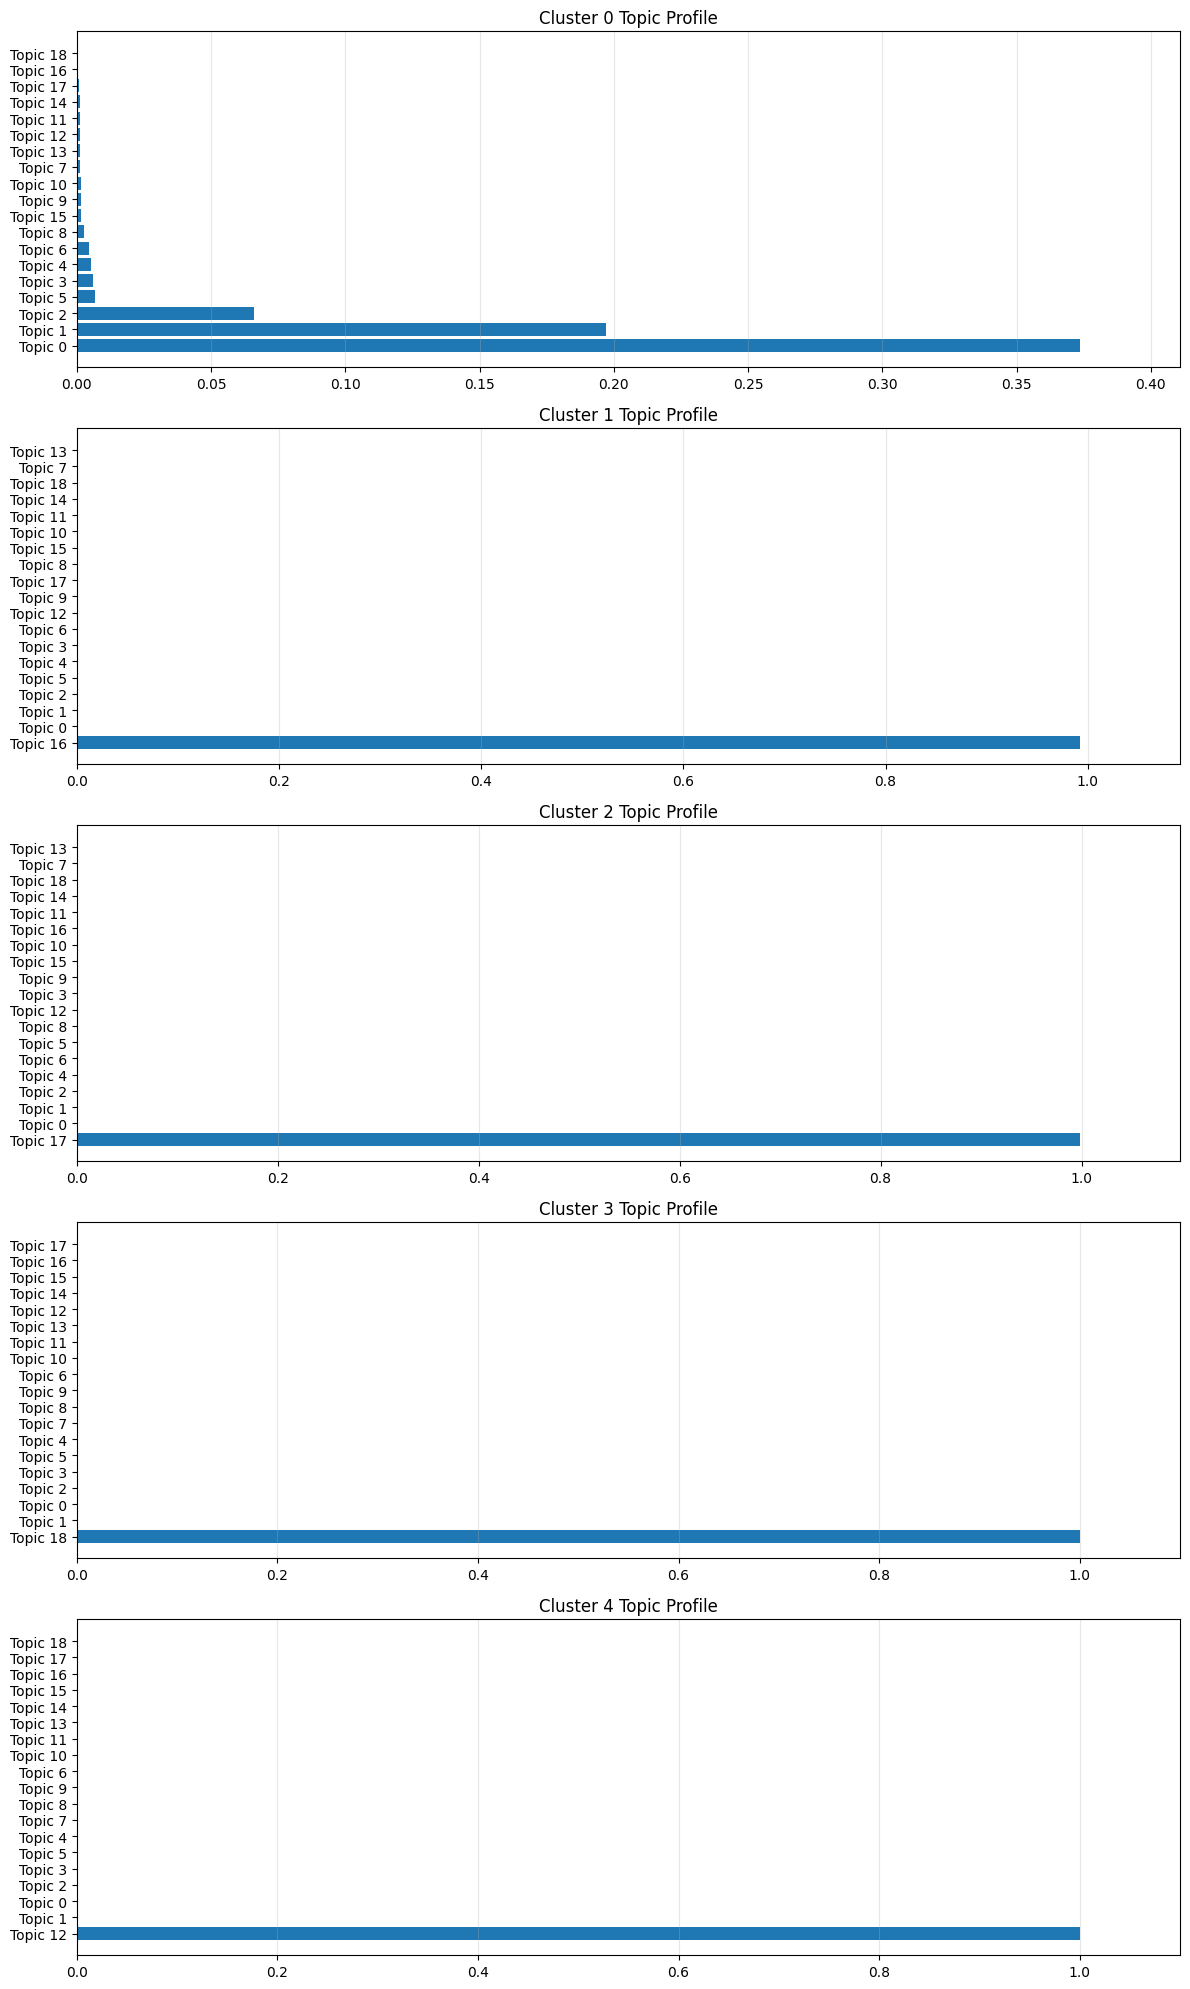

In [88]:
visualize_cluster_topic_profiles(df, 5)

#### Radar Chart (Topic Distribution Comparision)

In [89]:
def create_radar_chart(df_with_clusters, n_clusters):
    """
    Create radar charts to compare topic distributions across clusters
    """
    # Extract topic columns
    topic_cols = [col for col in df_with_clusters.columns if re.match(r'^topic_prob_\d+$', col)]

    # Get top 5 topics overall
    top_topics = df_with_clusters[topic_cols].mean().nlargest(5).index.tolist()

    # Create cluster profiles for these topics
    cluster_profiles = df_with_clusters.groupby('hierarchical_cluster')[top_topics].mean()

    # Radar chart
    angles = np.linspace(0, 2*np.pi, len(top_topics), endpoint=False).tolist()
    angles += angles[:1]  # Close the loop

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    for i in range(n_clusters):
        values = cluster_profiles.iloc[i].values.tolist()
        values += values[:1]  # Close the loop

        ax.plot(angles, values, linewidth=2, label=f'Cluster {i}')
        ax.fill(angles, values, alpha=0.1)

    # Set labels and title
    labels = [f"Topic {t.split('_')[-1]}" for t in top_topics]
    labels += labels[:1]  # Close the loop
    ax.set_xticks(angles)
    ax.set_xticklabels(labels)

    plt.title('Topic Distribution Comparison Across Clusters', fontsize=14)
    plt.legend(loc='upper right')
    plt.show()

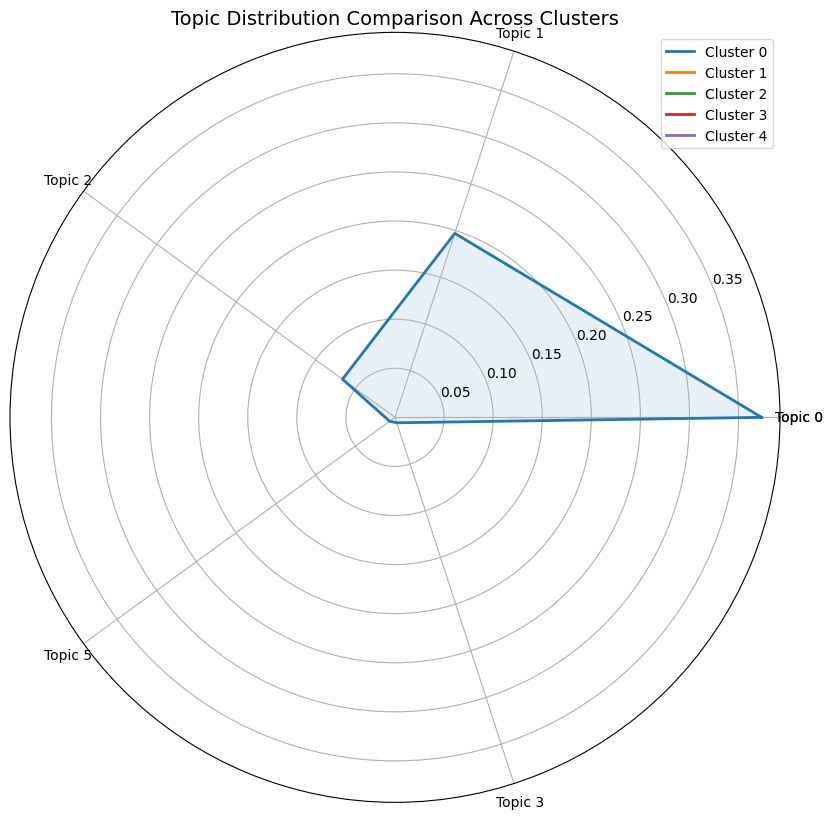

In [90]:
create_radar_chart(df, 5)

###### Cluster Wordclouds

In [78]:
def visualize_cluster_wordclouds(df_with_clusters, n_clusters):
    """
    Create word clouds for the most common words in each cluster
    """
    from wordcloud import WordCloud

    # Check if text column exists
    if 'text' not in df_with_clusters.columns:
        print("No text data available for word clouds")
        return

    # Create a figure with subplots
    fig, axes = plt.subplots(n_clusters, 1, figsize=(12, n_clusters * 10))

    for i in range(n_clusters):
        # Get text from this cluster
        cluster_text = ' '.join(df_with_clusters[df_with_clusters['hierarchical_cluster'] == i]['text'])

        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400,
                             background_color='white',
                             max_words=100,
                             contour_width=3).generate(cluster_text)

        # Plot
        ax = axes[i] if n_clusters > 1 else axes
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'Cluster {i} Word Cloud', fontsize=14)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [79]:
visualize_cluster_wordclouds(df, 5)

Output hidden; open in https://colab.research.google.com to view.